In [36]:
import time
import sys
import multiprocessing
from collections import deque
from pprint import pprint
import matplotlib.pyplot as plt

import gym
from gym import spaces
import numpy as np
import tensorflow as tf

from stable_baselines import logger
from stable_baselines.common import explained_variance, ActorCriticRLModel, tf_util, SetVerbosity, TensorboardWriter
from stable_baselines.common.runners import AbstractEnvRunner
from stable_baselines.common.policies import LstmPolicy, ActorCriticPolicy
from stable_baselines.a2c.utils import total_episode_reward_logger
from stable_baselines.ppo2 import PPO2 as PPO2_0
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import SubprocVecEnv, DummyVecEnv

In [37]:
class Runner(AbstractEnvRunner):
    def __init__(self, *, env, model, n_steps, gamma, lam):
        """
        A runner to learn the policy of an environment for a model
        :param env: (Gym environment) The environment to learn from
        :param model: (Model) The model to learn
        :param n_steps: (int) The number of steps to run for each environment
        :param gamma: (float) Discount factor
        :param lam: (float) Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        """
        super().__init__(env=env, model=model, n_steps=n_steps)
        self.lam = lam
        self.gamma = gamma

    def run(self):
        """
        Run a learning step of the model
        :return:
            - observations: (np.ndarray) the observations
            - rewards: (np.ndarray) the rewards
            - masks: (numpy bool) whether an episode is over or not
            - actions: (np.ndarray) the actions
            - values: (np.ndarray) the value function output
            - negative log probabilities: (np.ndarray)
            - states: (np.ndarray) the internal states of the recurrent policies
            - infos: (dict) the extra information of the model
        """
        # mb stands for minibatch
        mb_obs, mb_rewards, mb_actions, mb_values, mb_dones, mb_neglogpacs = [], [], [], [], [], []
        mb_states = self.states
        ep_infos = []
        for _ in range(self.n_steps):
            actions, values, self.states, neglogpacs = self.model.step(self.obs, self.states, self.dones)
            mb_obs.append(self.obs.copy())
            mb_actions.append(actions)
            mb_values.append(values)
            mb_neglogpacs.append(neglogpacs)
            mb_dones.append(self.dones)
            clipped_actions = actions
            # Clip the actions to avoid out of bound error
            if isinstance(self.env.action_space, gym.spaces.Box):
                clipped_actions = np.clip(actions, self.env.action_space.low, self.env.action_space.high)
            self.obs[:], rewards, self.dones, infos = self.env.step(clipped_actions)
            for info in infos:
                maybeep_info = info.get('episode')
                if maybeep_info:
                    ep_infos.append(maybeep_info)
            mb_rewards.append(rewards)
        # batch of steps to batch of rollouts
        mb_obs = np.asarray(mb_obs, dtype=self.obs.dtype)
        mb_rewards = np.asarray(mb_rewards, dtype=np.float32)
        mb_actions = np.asarray(mb_actions)
        mb_values = np.asarray(mb_values, dtype=np.float32)
        mb_neglogpacs = np.asarray(mb_neglogpacs, dtype=np.float32)
        mb_dones = np.asarray(mb_dones, dtype=np.bool)
        last_values = self.model.value(self.obs, self.states, self.dones)
        # discount/bootstrap off value fn
        mb_advs = np.zeros_like(mb_rewards)
        true_reward = np.copy(mb_rewards)
        last_gae_lam = 0
        for step in reversed(range(self.n_steps)):
            if step == self.n_steps - 1:
                nextnonterminal = 1.0 - self.dones
                nextvalues = last_values
            else:
                nextnonterminal = 1.0 - mb_dones[step + 1]
                nextvalues = mb_values[step + 1]
            delta = mb_rewards[step] + self.gamma * nextvalues * nextnonterminal - mb_values[step]
            mb_advs[step] = last_gae_lam = delta + self.gamma * self.lam * nextnonterminal * last_gae_lam
        mb_returns = mb_advs + mb_values

        mb_obs, mb_returns, mb_dones, mb_actions, mb_values, mb_neglogpacs = \
            map(swap_and_flatten, (mb_obs, mb_returns, mb_dones, mb_actions, mb_values, mb_neglogpacs))

        return mb_obs, mb_returns, mb_dones, mb_actions, mb_values, mb_neglogpacs, mb_states, ep_infos, true_reward


# obs, returns, masks, actions, values, neglogpacs, states = runner.run()
def swap_and_flatten(arr):
    """
    swap and then flatten axes 0 and 1
    :param arr: (np.ndarray)
    :return: (np.ndarray)
    """
    shape = arr.shape
    return arr.swapaxes(0, 1).reshape(shape[0] * shape[1], *shape[2:])


def constfn(val):
    """
    Create a function that returns a constant
    It is useful for learning rate schedule (to avoid code duplication)
    :param val: (float)
    :return: (function)
    """

    def func(_):
        return val

    return func


def safe_mean(arr):
    """
    Compute the mean of an array if there is at least one element.
    For empty array, return zero. It is used for logging only.
    :param arr: (np.ndarray)
    :return: (float)
    """
    return np.nan if len(arr) == 0 else np.mean(arr)

In [38]:
class PPO2(ActorCriticRLModel):
    """
    Proximal Policy Optimization algorithm (GPU version).
    Paper: https://arxiv.org/abs/1707.06347

    :param policy: (ActorCriticPolicy or str) The policy model to use (MlpPolicy, CnnPolicy, CnnLstmPolicy, ...)
    :param env: (Gym environment or str) The environment to learn from (if registered in Gym, can be str)
    :param gamma: (float) Discount factor
    :param n_steps: (int) The number of steps to run for each environment per update
        (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
    :param ent_coef: (float) Entropy coefficient for the loss caculation
    :param learning_rate: (float or callable) The learning rate, it can be a function
    :param vf_coef: (float) Value function coefficient for the loss calculation
    :param max_grad_norm: (float) The maximum value for the gradient clipping
    :param lam: (float) Factor for trade-off of bias vs variance for Generalized Advantage Estimator
    :param nminibatches: (int) Number of training minibatches per update. For recurrent policies,
        the number of environments run in parallel should be a multiple of nminibatches.
    :param noptepochs: (int) Number of epoch when optimizing the surrogate
    :param cliprange: (float or callable) Clipping parameter, it can be a function
    :param verbose: (int) the verbosity level: 0 none, 1 training information, 2 tensorflow debug
    :param tensorboard_log: (str) the log location for tensorboard (if None, no logging)
    :param _init_setup_model: (bool) Whether or not to build the network at the creation of the instance
    """

    def __init__(self, policy, env, gamma=0.99, n_steps=128, ent_coef=0.01, learning_rate=2.5e-4, vf_coef=0.5,
                 max_grad_norm=0.5, lam=0.95, nminibatches=4, noptepochs=4, cliprange=0.2, verbose=0,
                 tensorboard_log=None, _init_setup_model=True):

        super(PPO2, self).__init__(policy=policy, env=env, verbose=verbose, requires_vec_env=True,
                                   _init_setup_model=_init_setup_model)

        if isinstance(learning_rate, float):
            learning_rate = constfn(learning_rate)
        else:
            assert callable(learning_rate)
        if isinstance(cliprange, float):
            cliprange = constfn(cliprange)
        else:
            assert callable(cliprange)

        self.learning_rate = learning_rate
        self.cliprange = cliprange
        self.n_steps = n_steps
        self.ent_coef = ent_coef
        self.vf_coef = vf_coef
        self.max_grad_norm = max_grad_norm
        self.gamma = gamma
        self.lam = lam
        self.nminibatches = nminibatches
        self.noptepochs = noptepochs
        self.tensorboard_log = tensorboard_log

        self.graph = None
        self.sess = None
        self.action_ph = None
        self.advs_ph = None
        self.rewards_ph = None
        self.old_neglog_pac_ph = None
        self.old_vpred_ph = None
        self.learning_rate_ph = None
        self.clip_range_ph = None
        self.entropy = None
        self.vf_loss = None
        self.pg_loss = None
        self.approxkl = None
        self.clipfrac = None
        self.params = None
        self._train = None
        self.loss_names = None
        self.train_model = None
        self.act_model = None
        self.step = None
        self.proba_step = None
        self.value = None
        self.initial_state = None
        self.n_batch = None
        self.summary = None
        self.episode_reward = None

        if _init_setup_model:
            self.setup_model()

    def setup_model(self):
        with SetVerbosity(self.verbose):

            assert issubclass(self.policy, ActorCriticPolicy), "Error: the input policy for the PPO2 model must be " \
                                                               "an instance of common.policies.ActorCriticPolicy."

            self.n_batch = self.n_envs * self.n_steps

            n_cpu = multiprocessing.cpu_count()
            if sys.platform == 'darwin':
                n_cpu //= 2

            self.graph = tf.Graph()
            with self.graph.as_default():
                self.sess = tf_util.make_session(num_cpu=n_cpu, graph=self.graph)

                n_batch_step = None
                n_batch_train = None
                if issubclass(self.policy, LstmPolicy):
                    assert self.n_envs % self.nminibatches == 0, "For recurrent policies, "\
                        "the number of environments run in parallel should be a multiple of nminibatches."
                    n_batch_step = self.n_envs
                    n_batch_train = self.n_batch // self.nminibatches

                act_model = self.policy(self.sess, self.observation_space, self.action_space, self.n_envs, 1,
                                        n_batch_step, reuse=False)
                with tf.variable_scope("train_model", reuse=True,
                                       custom_getter=tf_util.outer_scope_getter("train_model")):
                    train_model = self.policy(self.sess, self.observation_space, self.action_space,
                                              self.n_envs // self.nminibatches, self.n_steps, n_batch_train,
                                              reuse=True)

                with tf.variable_scope("loss", reuse=False):
                    self.action_ph = train_model.pdtype.sample_placeholder([None], name="action_ph")
                    self.advs_ph = tf.placeholder(tf.float32, [None], name="advs_ph")
                    self.rewards_ph = tf.placeholder(tf.float32, [None], name="rewards_ph")
                    self.old_neglog_pac_ph = tf.placeholder(tf.float32, [None], name="old_neglog_pac_ph")
                    self.old_vpred_ph = tf.placeholder(tf.float32, [None], name="old_vpred_ph")
                    self.learning_rate_ph = tf.placeholder(tf.float32, [], name="learning_rate_ph")
                    self.clip_range_ph = tf.placeholder(tf.float32, [], name="clip_range_ph")

                    neglogpac = train_model.proba_distribution.neglogp(self.action_ph)
                    self.entropy = tf.reduce_mean(train_model.proba_distribution.entropy())

                    vpred = train_model._value
                    vpredclipped = self.old_vpred_ph + tf.clip_by_value(
                        train_model._value - self.old_vpred_ph, - self.clip_range_ph, self.clip_range_ph)
                    vf_losses1 = tf.square(vpred - self.rewards_ph)
                    vf_losses2 = tf.square(vpredclipped - self.rewards_ph)
                    self.vf_loss = .5 * tf.reduce_mean(tf.maximum(vf_losses1, vf_losses2))
                    ratio = tf.exp(self.old_neglog_pac_ph - neglogpac)
                    pg_losses = -self.advs_ph * ratio
                    pg_losses2 = -self.advs_ph * tf.clip_by_value(ratio, 1.0 - self.clip_range_ph, 1.0 +
                                                                  self.clip_range_ph)
                    self.pg_loss = tf.reduce_mean(tf.maximum(pg_losses, pg_losses2))
                    self.approxkl = .5 * tf.reduce_mean(tf.square(neglogpac - self.old_neglog_pac_ph))
                    self.clipfrac = tf.reduce_mean(tf.to_float(tf.greater(tf.abs(ratio - 1.0), self.clip_range_ph)))
                    loss = self.pg_loss - self.entropy * self.ent_coef + self.vf_loss * self.vf_coef

                    tf.summary.scalar('entropy_loss', self.entropy)
                    tf.summary.scalar('policy_gradient_loss', self.pg_loss)
                    tf.summary.scalar('value_function_loss', self.vf_loss)
                    tf.summary.scalar('approximate_kullback-leiber', self.approxkl)
                    tf.summary.scalar('clip_factor', self.clipfrac)
                    tf.summary.scalar('loss', loss)

                    with tf.variable_scope('model'):
                        self.params = tf.trainable_variables()
                    grads = tf.gradients(loss, self.params)
                    if self.max_grad_norm is not None:
                        grads, _grad_norm = tf.clip_by_global_norm(grads, self.max_grad_norm)
                    grads = list(zip(grads, self.params))
                trainer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_ph, epsilon=1e-5)
                self._train = trainer.apply_gradients(grads)

                self.loss_names = ['policy_loss', 'value_loss', 'policy_entropy', 'approxkl', 'clipfrac']

                with tf.variable_scope("input_info", reuse=False):
                    tf.summary.scalar('discounted_rewards', tf.reduce_mean(self.rewards_ph))
                    tf.summary.histogram('discounted_rewards', self.rewards_ph)
                    tf.summary.scalar('learning_rate', tf.reduce_mean(self.learning_rate_ph))
                    tf.summary.histogram('learning_rate', self.learning_rate_ph)
                    tf.summary.scalar('advantage', tf.reduce_mean(self.advs_ph))
                    tf.summary.histogram('advantage', self.advs_ph)
                    tf.summary.scalar('clip_range', tf.reduce_mean(self.clip_range_ph))
                    tf.summary.histogram('clip_range', self.clip_range_ph)
                    tf.summary.scalar('old_neglog_action_probabilty', tf.reduce_mean(self.old_neglog_pac_ph))
                    tf.summary.histogram('old_neglog_action_probabilty', self.old_neglog_pac_ph)
                    tf.summary.scalar('old_value_pred', tf.reduce_mean(self.old_vpred_ph))
                    tf.summary.histogram('old_value_pred', self.old_vpred_ph)
                    if len(self.observation_space.shape) == 3:
                        tf.summary.image('observation', train_model.obs_ph)
                    else:
                        tf.summary.histogram('observation', train_model.obs_ph)

                self.train_model = train_model
                self.act_model = act_model
                self.step = act_model.step
                self.proba_step = act_model.proba_step
                self.value = act_model.value
                self.initial_state = act_model.initial_state
                tf.global_variables_initializer().run(session=self.sess)  # pylint: disable=E1101

                self.summary = tf.summary.merge_all()

    def _train_step(self, learning_rate, cliprange, obs, returns, masks, actions, values, neglogpacs, update,
                    writer, states=None):
        """
        Training of PPO2 Algorithm

        :param learning_rate: (float) learning rate
        :param cliprange: (float) Clipping factor
        :param obs: (np.ndarray) The current observation of the environment
        :param returns: (np.ndarray) the rewards
        :param masks: (np.ndarray) The last masks for done episodes (used in recurent policies)
        :param actions: (np.ndarray) the actions
        :param values: (np.ndarray) the values
        :param neglogpacs: (np.ndarray) Negative Log-likelihood probability of Actions
        :param update: (int) the current step iteration
        :param writer: (TensorFlow Summary.writer) the writer for tensorboard
        :param states: (np.ndarray) For recurrent policies, the internal state of the recurrent model
        :return: policy gradient loss, value function loss, policy entropy,
                approximation of kl divergence, updated clipping range, training update operation
        """
        advs = returns - values
        advs = (advs - advs.mean()) / (advs.std() + 1e-8)
        td_map = {self.train_model.obs_ph: obs, self.action_ph: actions, self.advs_ph: advs, self.rewards_ph: returns,
                  self.learning_rate_ph: learning_rate, self.clip_range_ph: cliprange,
                  self.old_neglog_pac_ph: neglogpacs, self.old_vpred_ph: values}
        if states is not None:
            td_map[self.train_model.states_ph] = states
            td_map[self.train_model.masks_ph] = masks

        if states is None:
            update_fac = self.n_batch // self.nminibatches // self.noptepochs
        else:
            update_fac = self.n_batch // self.nminibatches // self.noptepochs // self.n_steps

        if writer is not None:
            # run loss backprop with summary, but once every 10 runs save the metadata (memory, compute time, ...)
            if (1 + update) % 10 == 0:
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
                summary, policy_loss, value_loss, policy_entropy, approxkl, clipfrac, _ = self.sess.run(
                    [self.summary, self.pg_loss, self.vf_loss, self.entropy, self.approxkl, self.clipfrac, self._train],
                    td_map, options=run_options, run_metadata=run_metadata)
                writer.add_run_metadata(run_metadata, 'step%d' % (update * update_fac))
            else:
                summary, policy_loss, value_loss, policy_entropy, approxkl, clipfrac, _ = self.sess.run(
                    [self.summary, self.pg_loss, self.vf_loss, self.entropy, self.approxkl, self.clipfrac, self._train],
                    td_map)
            writer.add_summary(summary, (update * update_fac))
        else:
            policy_loss, value_loss, policy_entropy, approxkl, clipfrac, _ = self.sess.run(
                [self.pg_loss, self.vf_loss, self.entropy, self.approxkl, self.clipfrac, self._train], td_map)

        return policy_loss, value_loss, policy_entropy, approxkl, clipfrac
    
    def learn_setup(self, total_timesteps):
        self.runner = Runner(env=self.env, model=self, n_steps=self.n_steps, gamma=self.gamma, lam=self.lam)
        self.episode_reward = np.zeros((self.n_envs,))
        self.ep_info_buf = deque(maxlen=100)
        self.t_first_start = time.time()
        self.total_timesteps = total_timesteps
        self.nupdates = self.total_timesteps // self.n_batch
        self.update = 0
        
        return self.runner
    
    def learn_setup_runnerless(self, total_timesteps):
        self.episode_reward = np.zeros((self.n_envs,))
        self.ep_info_buf = deque(maxlen=100)
        self.t_first_start = time.time()
        self.total_timesteps = total_timesteps
        self.nupdates = self.total_timesteps // self.n_batch
        self.update = 0
        
    def learn_step(self, run):
        tb_log_name="PPO2"
        log_interval = 1
        with SetVerbosity(self.verbose), TensorboardWriter(self.graph, self.tensorboard_log, tb_log_name) as writer:
            assert self.n_batch % self.nminibatches == 0
            n_batch_train = self.n_batch // self.nminibatches
            t_start = time.time()
            frac = 1.0 - (self.update - 1.0) / self.nupdates
            lr_now = self.learning_rate(frac)
            cliprangenow = self.cliprange(frac)
            # true_reward is the reward without discount
            obs, returns, masks, actions, values, neglogpacs, states, ep_infos, true_reward = run
            self.ep_info_buf.extend(ep_infos)
            mb_loss_vals = []

            inds = np.arange(self.n_batch)
            for epoch_num in range(self.noptepochs):
                np.random.shuffle(inds)
                for start in range(0, self.n_batch, n_batch_train):
                    timestep = ((self.update * self.noptepochs * self.n_batch + epoch_num * self.n_batch + start) //
                                n_batch_train)
                    end = start + n_batch_train
                    mbinds = inds[start:end]
                    slices = (arr[mbinds] for arr in (obs, returns, masks, actions, values, neglogpacs))
                    mb_loss_vals.append(self._train_step(lr_now, cliprangenow, *slices, writer=writer,
                                                         update=timestep))

            loss_vals = np.mean(mb_loss_vals, axis=0)
            t_now = time.time()
            fps = int(self.n_batch / (t_now - t_start))

            if writer is not None:
                self.episode_reward = total_episode_reward_logger(self.episode_reward,
                                                                  true_reward.reshape((self.n_envs, self.n_steps)),
                                                                  masks.reshape((self.n_envs, self.n_steps)),
                                                                  writer, self.update * (self.n_batch + 1))

            if self.verbose >= 1 and (self.update % log_interval == 0 or self.update == 1):
                explained_var = explained_variance(values, returns)
                logger.logkv("serial_timesteps", (self.update + 1) * self.n_steps)
                logger.logkv("nupdates", (self.update + 1))
                logger.logkv("total_timesteps", (self.update + 1) * self.n_batch)
                logger.logkv("fps", fps)
                logger.logkv("explained_variance", float(explained_var))
                logger.logkv('ep_rewmean', safe_mean([ep_info['r'] for ep_info in self.ep_info_buf]))
                logger.logkv('eplenmean', safe_mean([ep_info['l'] for ep_info in self.ep_info_buf]))
                logger.logkv('time_elapsed', t_start - self.t_first_start)
                for (loss_val, loss_name) in zip(loss_vals, self.loss_names):
                    logger.logkv(loss_name, loss_val)
                logger.dumpkvs()
                
            self.update += 1
        

    def learn(self, total_timesteps, callback=None, seed=None, log_interval=1, tb_log_name="PPO2"):
        with SetVerbosity(self.verbose), TensorboardWriter(self.graph, self.tensorboard_log, tb_log_name) as writer:
            self._setup_learn(seed)

            runner = Runner(env=self.env, model=self, n_steps=self.n_steps, gamma=self.gamma, lam=self.lam)
            self.episode_reward = np.zeros((self.n_envs,))

            ep_info_buf = deque(maxlen=100)
            t_first_start = time.time()

            nupdates = total_timesteps // self.n_batch
            for update in range(1, nupdates + 1):
                assert self.n_batch % self.nminibatches == 0
                n_batch_train = self.n_batch // self.nminibatches
                t_start = time.time()
                frac = 1.0 - (update - 1.0) / nupdates
                lr_now = self.learning_rate(frac)
                cliprangenow = self.cliprange(frac)
                # true_reward is the reward without discount
                obs, returns, masks, actions, values, neglogpacs, states, ep_infos, true_reward = runner.run([])
                ep_info_buf.extend(ep_infos)
                mb_loss_vals = []
                if states is None:  # nonrecurrent version
                    inds = np.arange(self.n_batch)
                    for epoch_num in range(self.noptepochs):
                        np.random.shuffle(inds)
                        for start in range(0, self.n_batch, n_batch_train):
                            timestep = ((update * self.noptepochs * self.n_batch + epoch_num * self.n_batch + start) //
                                        n_batch_train)
                            end = start + n_batch_train
                            mbinds = inds[start:end]
                            slices = (arr[mbinds] for arr in (obs, returns, masks, actions, values, neglogpacs))
                            mb_loss_vals.append(self._train_step(lr_now, cliprangenow, *slices, writer=writer,
                                                                 update=timestep))
                else:  # recurrent version
                    assert self.n_envs % self.nminibatches == 0
                    envinds = np.arange(self.n_envs)
                    flatinds = np.arange(self.n_envs * self.n_steps).reshape(self.n_envs, self.n_steps)
                    envsperbatch = n_batch_train // self.n_steps
                    for epoch_num in range(self.noptepochs):
                        np.random.shuffle(envinds)
                        for start in range(0, self.n_envs, envsperbatch):
                            timestep = ((update * self.noptepochs * self.n_envs + epoch_num * self.n_envs + start) //
                                        envsperbatch)
                            end = start + envsperbatch
                            mb_env_inds = envinds[start:end]
                            mb_flat_inds = flatinds[mb_env_inds].ravel()
                            slices = (arr[mb_flat_inds] for arr in (obs, returns, masks, actions, values, neglogpacs))
                            mb_states = states[mb_env_inds]
                            mb_loss_vals.append(self._train_step(lr_now, cliprangenow, *slices, update=timestep,
                                                                 writer=writer, states=mb_states))

                loss_vals = np.mean(mb_loss_vals, axis=0)
                t_now = time.time()
                fps = int(self.n_batch / (t_now - t_start))

                if writer is not None:
                    self.episode_reward = total_episode_reward_logger(self.episode_reward,
                                                                      true_reward.reshape((self.n_envs, self.n_steps)),
                                                                      masks.reshape((self.n_envs, self.n_steps)),
                                                                      writer, update * (self.n_batch + 1))

                if callback is not None:
                    callback(locals(), globals())

                if self.verbose >= 1 and (update % log_interval == 0 or update == 1):
                    explained_var = explained_variance(values, returns)
                    logger.logkv("serial_timesteps", (update + 1) * self.n_steps)
                    logger.logkv("nupdates", (update + 1))
                    logger.logkv("total_timesteps", (update + 1) * self.n_batch)
                    logger.logkv("fps", fps)
                    logger.logkv("explained_variance", float(explained_var))
                    logger.logkv('ep_rewmean', safe_mean([ep_info['r'] for ep_info in ep_info_buf]))
                    logger.logkv('eplenmean', safe_mean([ep_info['l'] for ep_info in ep_info_buf]))
                    logger.logkv('time_elapsed', t_start - t_first_start)
                    for (loss_val, loss_name) in zip(loss_vals, self.loss_names):
                        logger.logkv(loss_name, loss_val)
                    logger.dumpkvs()

            return self

    def save(self, save_path):
        data = {
            "gamma": self.gamma,
            "n_steps": self.n_steps,
            "vf_coef": self.vf_coef,
            "ent_coef": self.ent_coef,
            "max_grad_norm": self.max_grad_norm,
            "learning_rate": self.learning_rate,
            "lam": self.lam,
            "nminibatches": self.nminibatches,
            "noptepochs": self.noptepochs,
            "cliprange": self.cliprange,
            "verbose": self.verbose,
            "policy": self.policy,
            "observation_space": self.observation_space,
            "action_space": self.action_space,
            "n_envs": self.n_envs,
            "_vectorize_action": self._vectorize_action
        }

        params = self.sess.run(self.params)

        self._save_to_file(save_path, data=data, params=params)

In [93]:
class Environment(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, num_obs=2):
        self.episode = 0
        self.num_obs = num_obs
        self.action_space = spaces.MultiBinary(self.num_obs)
        self.observation_space = spaces.MultiBinary(self.num_obs)
    
    def reset(self):
        self.episode += 1
        self.reward = 0
        self.count = 0
        self.state = np.random.randint(0,2, (self.num_obs, ))
        #self.state = np.array([1])
        return np.array(self.state)
    
    def step(self, action):
        reward = 0.
        for n in range(self.num_obs):
            print("Env S,A:", self.state[n], action[n])
            if action[n] == self.state[n]:
                reward += 1./self.num_obs
            else:
                reward -= 1./self.num_obs
        
        print("Env R:", reward)
        self.reward += reward
            
        self.state = np.array(np.random.randint(0,2, (self.num_obs, )))
        self.count += 1
        done = False
        
        if self.count > 10:
            done = True
            
        return self.state, reward, done, {'episode': {'r': self.reward, 'l': self.count}}
    
    def render(self, mode='human', close=False):
        pass
    
    
class SubEnvironment:
    metadata = {'render.modes': ['human']}
    
    def __init__(self, num_obs=2):
        self.num_obs = num_obs
        self.action_space = spaces.MultiBinary(1)
        self.observation_space = spaces.MultiBinary(self.num_obs)
    
    def reset(self):
        self.count = 0
        self.reward = 0.
        return np.array(self.state)
    
    def step(self, state, reward, done):
        self.reward += reward
        self.count += 1
        
        return state, reward, done, [{'episode': {'r': self.reward, 'l': self.count}}]
    
    def render(self, mode='human', close=False):
        pass

# Procedure

- We first initialize each submodel with the subenvironment
- We then initialize the main environment and reset it
- Then, for `train_steps`, loop through each submodel
    - Pass the current observation to the runner
    - Capture the actions, rewards, etc.

In [ ]:
def swap_and_flatten(arr):
    shape = arr.shape
    return arr.swapaxes(0, 1).reshape(shape[0] * shape[1], *shape[2:])

def constfn(val):
    def func(_):
        return val

    return func

num_subs = 4
submodels = []

for _ in range(num_subs):
    sm = PPO2(MlpPolicy, DummyVecEnv([lambda: SubEnvironment(num_subs)]), verbose=0)
    sm.learn_setup_runnerless(10000)
    submodels.append(sm)
    
env = Environment(num_subs)
gamma = 0.99
lam = 0.95

train_steps = 10000
n_steps = 128
average_rewards = []
for train_step in range(train_steps):
    print("Train Step:", train_step)
    
    ###
    # Create a Run
    ###
    
    # minibatches
    mbs = []
    for n in range(num_subs):
        mbs.append({
            'obs': [],
            'rewards': [],
            'actions': [],
            'values': [],
            'dones': [],
            'neglogpacs': [],
            'ep_infos': []
        })
    
    mb_states = None
    ep_infos = []
    dones = False
    train_step_rewards = []
    
    obs = np.zeros((1,) + env.observation_space.shape, dtype=env.observation_space.dtype.name)
    obs[:] = env.reset()
    
    # for each step
    for mb_step in range(n_steps):
        augmented_actions = []
        # for each submodel
        for n, submodel in enumerate(submodels):
            # make an action
            actions, values, states, neglogpacs = submodel.step(obs)
            print("AP", submodel.action_probability(obs))
            
            # append data
            mbs[n]['obs'].append(obs.copy())
            mbs[n]['actions'].append(actions)
            mbs[n]['values'].append(values)
            mbs[n]['neglogpacs'].append(neglogpacs)
            mbs[n]['dones'].append([dones])
            
            # collection the actions
            clipped_actions = actions
            if isinstance(env.action_space, gym.spaces.Box):
                clipped_actions = np.clip(actions, env.action_space.low, env.action_space.high)
            augmented_actions.append(clipped_actions)
        
        # combine the actions
        augmented_actions = np.array(augmented_actions).reshape((num_subs, ))
        
        print("O, A:", obs, augmented_actions)
        
        # step in the environment
        obs[:], rewards, dones, infos = env.step(augmented_actions)
        
        print("R:", rewards)
        print("----")
        
        train_step_rewards.append(rewards)
        
        # for each submodel
        for n, submodel in enumerate(submodels):
            # append info
            for info in [infos]:
                maybeep_info = info.get('episode')
                if maybeep_info:
                    mbs[n]['ep_infos'].append(maybeep_info)
            # append reward
            mbs[n]['rewards'].append(rewards)
            
    # 413 ppo2.py
    for n, submodel in enumerate(submodels):
        mb_obs = np.asarray(mbs[n]['obs'], dtype=obs.dtype)
        mb_rewards = np.asarray(mbs[n]['rewards'], dtype=np.float32)
        mb_actions = np.asarray(mbs[n]['actions'])
        mb_values = np.asarray(mbs[n]['values'], dtype=np.float32)
        mb_neglogpacs = np.asarray(mbs[n]['neglogpacs'], dtype=np.float32)
        mb_dones = np.asarray(mbs[n]['dones'], dtype=np.bool)
        last_values = submodel.value(obs, None, dones)
        
        mb_advs = np.zeros_like(mb_rewards)
        true_reward = np.copy(mb_rewards)
        last_gae_lam = 0
        
        for step in reversed(range(n_steps)):
            if step == n_steps - 1:
                nextnonterminal = 1.0 - dones
                nextvalues = last_values
            else:
                nextnonterminal = 1.0 - mb_dones[step + 1]
                nextvalues = mb_values[step + 1]
            delta = mb_rewards[step] + gamma * nextvalues * nextnonterminal - mb_values[step]
            mb_advs[step] = last_gae_lam = delta + gamma * lam * nextnonterminal * last_gae_lam
        mb_returns = mb_advs + mb_values
        
        mb_obs, mb_returns, mb_dones, mb_actions, mb_values, mb_neglogpacs = \
            map(swap_and_flatten, (mb_obs, mb_returns, mb_dones, mb_actions, mb_values, mb_neglogpacs))

        run = mb_obs, mb_returns, mb_dones, mb_actions, mb_values, mb_neglogpacs, mb_states, ep_infos, true_reward
        submodel.learn_step(run)
        
    average_rewards.append(np.mean(train_step_rewards))
    print("R", np.mean(train_step_rewards))

Train Step: 0
AP [[0.0023878]]
AP [[0.00068985]]
AP [[0.00210179]]
AP [[0.00461001]]
O, A: [[0 1 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.00078779]]
AP [[0.00015214]]
AP [[0.00286269]]
AP [[0.00258701]]
O, A: [[0 0 0 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.]]
AP [[0.]]
AP [[0.]]
AP [[0.]]
O, A: [[0 0 0 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.00159395]]
AP [[-0.00319706]]
AP [[0.00374075]]
AP [[0.00512938]]
O, A: [[1 0 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.00159395]]
AP [[-0.00319706]]
AP [[0.00374075]]
AP [[0.00512938]]
O, A: [[1 0 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.00201482]]
AP [[-0.00150961]]
AP [[-0.00011481]]
AP [[-0.0038284]]
O,

AP [[-0.00102963]]
AP [[0.00361681]]
AP [[0.00877106]]
O, A: [[0 0 1 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-9.947235e-05]]
AP [[0.0018519]]
AP [[0.00340241]]
AP [[0.00046936]]
O, A: [[0 1 0 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.00201482]]
AP [[-0.00150961]]
AP [[-0.00011481]]
AP [[-0.0038284]]
O, A: [[1 0 0 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.00113728]]
AP [[0.00060383]]
AP [[0.0042167]]
AP [[0.00679122]]
O, A: [[0 1 1 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.00212298]]
AP [[0.00021607]]
AP [[0.00289914]]
AP [[-0.00237593]]
O, A: [[1 1 0 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-9.947235e-05]]
AP [[0.0018519]]
AP [[0.00340241]]
AP [[0.00046936]]


AP [[-0.00130886]]
AP [[0.0039646]]
AP [[0.00359516]]
O, A: [[1 1 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.]]
AP [[0.]]
AP [[0.]]
AP [[0.]]
O, A: [[0 0 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.00201482]]
AP [[-0.00150961]]
AP [[-0.00011481]]
AP [[-0.0038284]]
O, A: [[1 0 0 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.00159395]]
AP [[-0.00319706]]
AP [[0.00374075]]
AP [[0.00512938]]
O, A: [[1 0 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.00201482]]
AP [[-0.00150961]]
AP [[-0.00011481]]
AP [[-0.0038284]]
O, A: [[1 0 0 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.0023878]]
AP [[0.00068985]]
AP [[0.00210179]]
AP [[0.00461001]]
O, A: [[0 1 1 0]] [0. 1. 1. 1.]
En

AP [[-0.00145899]]
AP [[-0.01266589]]
AP [[-0.01051671]]
AP [[0.00476805]]
O, A: [[1 0 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00238689]]
AP [[0.01450773]]
AP [[-0.01793068]]
AP [[0.00430178]]
O, A: [[0 1 1 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.00078867]]
AP [[0.01063437]]
AP [[0.00074735]]
AP [[-0.00479774]]
O, A: [[1 1 0 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[-3.194341e-05]]
AP [[0.01616899]]
AP [[-0.01154788]]
AP [[0.00025843]]
O, A: [[0 1 0 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[-0.00071364]]
AP [[-0.00225172]]
AP [[-0.0055329]]
AP [[0.00238108]]
O, A: [[0 0 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.00071364]]
AP [[-0.00225172]]
AP [[-0.00553

AP [[7.72079e-05]]
AP [[0.00761642]]
AP [[-0.01172486]]
AP [[0.00106435]]
O, A: [[1 1 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00118788]]
AP [[0.01270521]]
AP [[-0.02243394]]
AP [[0.00635302]]
O, A: [[0 1 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00238689]]
AP [[0.01450773]]
AP [[-0.01793068]]
AP [[0.00430178]]
O, A: [[0 1 1 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.00118788]]
AP [[0.01270521]]
AP [[-0.02243394]]
AP [[0.00635302]]
O, A: [[0 1 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[-0.00071364]]
AP [[-0.00225172]]
AP [[-0.0055329]]
AP [[0.00238108]]
O, A: [[0 0 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00025007]]
AP [[-0.00524136]]
AP [[-0.01744524]

R 0.0703125
Train Step: 2
AP [[-0.00119353]]
AP [[-0.0021967]]
AP [[0.00136148]]
AP [[-0.00014748]]
O, A: [[0 0 0 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.01512032]]
AP [[-0.0111531]]
AP [[0.02043202]]
AP [[-0.00385099]]
O, A: [[1 0 0 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.01454036]]
AP [[0.01998224]]
AP [[0.01616085]]
AP [[-0.00490784]]
O, A: [[1 1 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.01512032]]
AP [[-0.0111531]]
AP [[0.02043202]]
AP [[-0.00385099]]
O, A: [[1 0 0 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[-0.00091209]]
AP [[0.0295058]]
AP [[-0.00206194]]
AP [[-0.00209515]]
O, A: [[0 1 0 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.01512032]]
AP [[-

AP [[-0.020752]]
AP [[0.01582137]]
AP [[0.01176017]]
AP [[-0.00291881]]
O, A: [[1 1 0 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.00819577]]
AP [[-0.00503558]]
AP [[-0.00137746]]
AP [[0.00195532]]
O, A: [[0 0 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.01454036]]
AP [[0.01998224]]
AP [[0.01616085]]
AP [[-0.00490784]]
O, A: [[1 1 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.00819577]]
AP [[-0.00503558]]
AP [[-0.00137746]]
AP [[0.00195532]]
O, A: [[0 0 0 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.01454036]]
AP [[0.01998224]]
AP [[0.01616085]]
AP [[-0.00490784]]
O, A: [[1 1 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00670638]]
AP [[-0.01165968]]
AP [[-0.01

AP [[-0.00019155]]
AP [[0.01489093]]
AP [[-0.01940654]]
AP [[0.00545875]]
O, A: [[0 1 1 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.00119353]]
AP [[-0.0021967]]
AP [[0.00136148]]
AP [[-0.00014748]]
O, A: [[0 0 0 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.01512032]]
AP [[-0.0111531]]
AP [[0.02043202]]
AP [[-0.00385099]]
O, A: [[1 0 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00694793]]
AP [[0.01928128]]
AP [[-0.01755737]]
AP [[0.00366483]]
O, A: [[0 1 1 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[-0.00019155]]
AP [[0.01489093]]
AP [[-0.01940654]]
AP [[0.00545875]]
O, A: [[0 1 1 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[-0.00038522]]
AP [[-0.01412467]]
AP [[-0.01704454

AP [[0.0266151]]
AP [[-0.02422583]]
AP [[0.04910485]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00973537]]
AP [[0.03351857]]
AP [[-0.03061472]]
AP [[0.03978911]]
O, A: [[0 1 0 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.02868134]]
AP [[0.02768913]]
AP [[-0.03404127]]
AP [[0.03942327]]
O, A: [[0 1 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.02799044]]
AP [[0.02813236]]
AP [[-0.04551746]]
AP [[0.05672391]]
O, A: [[0 1 1 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.01833187]]
AP [[0.02679161]]
AP [[-0.03586389]]
AP [[0.06655978]]
O, A: [[1 1 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.01126888]]
AP [[-0.00321774]]
AP [[-0.01976836]]
AP [[0.05517849]]
O, A:

AP [[0.01063319]]
AP [[-0.00530649]]
AP [[-0.00873106]]
AP [[0.03606804]]
O, A: [[1 0 1 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00025852]]
AP [[0.0320462]]
AP [[-0.02067556]]
AP [[0.05068082]]
O, A: [[1 1 0 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.00973537]]
AP [[0.03351857]]
AP [[-0.03061472]]
AP [[0.03978911]]
O, A: [[0 1 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.02799044]]
AP [[0.02813236]]
AP [[-0.04551746]]
AP [[0.05672391]]
O, A: [[0 1 1 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.01126888]]
AP [[-0.00321774]]
AP [[-0.01976836]]
AP [[0.05517849]]
O, A: [[1 0 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.02060716]]
AP [[-0.00478029]]
AP [[-0.01881992]]
A

AP [[0.0097748]]
AP [[0.03266314]]
AP [[-0.01732183]]
AP [[0.02127834]]
O, A: [[0 1 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01833033]]
AP [[0.0266151]]
AP [[-0.02422583]]
AP [[0.04910485]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.01126888]]
AP [[-0.00321774]]
AP [[-0.01976836]]
AP [[0.05517849]]
O, A: [[1 0 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.00923623]]
AP [[-0.00125616]]
AP [[0.01048012]]
AP [[0.01724739]]
O, A: [[1 0 0 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00973537]]
AP [[0.03351857]]
AP [[-0.03061472]]
AP [[0.03978911]]
O, A: [[0 1 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.01063319]]
AP [[-0.00530649]]
AP [[-0.00873106]]
AP

AP [[0.06056738]]
O, A: [[0 1 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.0202371]]
AP [[0.04132632]]
AP [[-0.04877231]]
AP [[0.0654898]]
O, A: [[0 1 0 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00159995]]
AP [[-6.664757e-05]]
AP [[-0.00060703]]
AP [[0.00673334]]
O, A: [[0 0 0 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.02903723]]
AP [[0.00486315]]
AP [[-0.02074604]]
AP [[0.03682329]]
O, A: [[0 0 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.04087422]]
AP [[0.04582446]]
AP [[-0.06084612]]
AP [[0.10889641]]
O, A: [[1 1 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.01004228]]
AP [[0.01127385]]
AP [[-0.02204174]]
AP [[0.04240964]]
O, A: [[0 0 0 1]] [0. 1. 0. 1.]
Env S,A

AP [[0.032602]]
O, A: [[1 0 0 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.02903723]]
AP [[0.00486315]]
AP [[-0.02074604]]
AP [[0.03682329]]
O, A: [[0 0 1 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00723049]]
AP [[0.01566814]]
AP [[-0.01920917]]
AP [[0.06557634]]
O, A: [[1 0 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.01353044]]
AP [[0.03363186]]
AP [[-0.02897683]]
AP [[0.03444839]]
O, A: [[0 1 0 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.02571512]]
AP [[0.00953015]]
AP [[-0.01848215]]
AP [[0.05969388]]
O, A: [[1 0 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.04462291]]
AP [[0.04290132]]
AP [[-0.06370137]]
AP [[0.08946723]]
O, A: [[0 1 1 1]] [0. 1. 0. 0.]
Env 

R 0.02734375
Train Step: 5
AP [[0.04886048]]
AP [[0.04975286]]
AP [[-0.05900152]]
AP [[0.11790165]]
O, A: [[1 1 1 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.04056029]]
AP [[0.02171182]]
AP [[-0.0274539]]
AP [[0.09893741]]
O, A: [[1 0 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00240647]]
AP [[0.00014861]]
AP [[0.00048254]]
AP [[0.00739938]]
O, A: [[0 0 0 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.02916462]]
AP [[0.0126225]]
AP [[-0.01149832]]
AP [[0.06475148]]
O, A: [[1 0 1 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.01194369]]
AP [[0.03964618]]
AP [[-0.02801416]]
AP [[0.06199851]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.02337657]]
AP [[0.0474441]]

AP [[0.02171182]]
AP [[-0.0274539]]
AP [[0.09893741]]
O, A: [[1 0 1 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.00062682]]
AP [[0.00756324]]
AP [[0.00517387]]
AP [[0.03592141]]
O, A: [[1 0 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.04421828]]
AP [[0.01770765]]
AP [[-0.03290129]]
AP [[0.0748764]]
O, A: [[0 0 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01349773]]
AP [[0.01856329]]
AP [[-0.0140427]]
AP [[0.07164167]]
O, A: [[1 0 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.02337657]]
AP [[0.0474441]]
AP [[-0.04654624]]
AP [[0.09410351]]
O, A: [[1 1 0 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.02635977]]
AP [[0.04292258]]
AP [[-0.05235273]]
AP [[0.07098624]]
O, A: 

AP [[0.03592141]]
O, A: [[1 0 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.05282395]]
AP [[0.04594704]]
AP [[-0.06439023]]
AP [[0.09643355]]
O, A: [[0 1 1 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04886048]]
AP [[0.04975286]]
AP [[-0.05900152]]
AP [[0.11790165]]
O, A: [[1 1 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.02635977]]
AP [[0.04292258]]
AP [[-0.05235273]]
AP [[0.07098624]]
O, A: [[0 1 0 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.03842593]]
AP [[0.04329302]]
AP [[-0.04245618]]
AP [[0.08651429]]
O, A: [[1 1 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.0143558]]
AP [[0.03380211]]
AP [[-0.03434803]]
AP [[0.0372931]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0

AP [[0.03151166]]
AP [[0.01037509]]
AP [[-0.01922487]]
AP [[0.0467942]]
O, A: [[0 0 0 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.06377469]]
AP [[0.0421954]]
AP [[-0.05062445]]
AP [[0.11957441]]
O, A: [[1 1 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.04107474]]
AP [[0.00189756]]
AP [[-0.01283189]]
AP [[0.03996366]]
O, A: [[0 0 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00452726]]
AP [[-0.00023734]]
AP [[0.0014361]]
AP [[0.00752307]]
O, A: [[0 0 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03301407]]
AP [[0.04367866]]
AP [[-0.0400766]]
AP [[0.09553461]]
O, A: [[1 1 0 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03996802]]
AP [[0.0373891]]
AP [[-0.05169417]]


AP [[0.04972133]]
AP [[0.03061243]]
AP [[-0.04415545]]
AP [[0.06591529]]
O, A: [[0 1 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03405536]]
AP [[0.00946404]]
AP [[-0.00204961]]
AP [[0.06568269]]
O, A: [[1 0 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.01568965]]
AP [[0.03010673]]
AP [[-0.03298439]]
AP [[0.03782214]]
O, A: [[0 1 0 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00991151]]
AP [[0.03761204]]
AP [[-0.02056324]]
AP [[0.06295917]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03996802]]
AP [[0.0373891]]
AP [[-0.05169417]]
AP [[0.07201457]]
O, A: [[0 1 0 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.03301407]]
AP [[0.04367866]]
AP [[-0.0400766]]

AP [[-0.01910409]]
AP [[0.10036516]]
O, A: [[1 0 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04107474]]
AP [[0.00189756]]
AP [[-0.01283189]]
AP [[0.03996366]]
O, A: [[0 0 1 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04972133]]
AP [[0.03061243]]
AP [[-0.04415545]]
AP [[0.06591529]]
O, A: [[0 1 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.07167141]]
AP [[0.03647567]]
AP [[-0.06164948]]
AP [[0.09772321]]
O, A: [[0 1 1 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04107474]]
AP [[0.00189756]]
AP [[-0.01283189]]
AP [[0.03996366]]
O, A: [[0 0 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.01568965]]
AP [[0.03010673]]
AP [[-0.03298439]]
AP [[0.03782214]]
O, A: [[0 1 0 0]] [

AP [[0.01558657]]
AP [[-0.00649953]]
AP [[0.07291764]]
O, A: [[1 0 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00560424]]
AP [[-0.00067696]]
AP [[0.00162836]]
AP [[0.00753644]]
O, A: [[0 0 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.07394619]]
AP [[0.0042105]]
AP [[-0.02990151]]
AP [[0.07599366]]
O, A: [[0 0 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.01283108]]
AP [[0.03486107]]
AP [[-0.01903923]]
AP [[0.06307523]]
O, A: [[1 1 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03675532]]
AP [[0.0069442]]
AP [[-0.01917388]]
AP [[0.04687759]]
O, A: [[0 0 0 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.03955489]]
AP [[0.03861309]]
AP [[-0.03874345]]
AP [[0.09570939]]

AP [[0.03432453]]
AP [[-0.04889809]]
AP [[0.11977156]]
O, A: [[1 1 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04025535]]
AP [[0.00686063]]
AP [[-0.00012924]]
AP [[0.06578717]]
O, A: [[1 0 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.06652815]]
AP [[0.01169019]]
AP [[-0.01739765]]
AP [[0.10053204]]
O, A: [[1 0 1 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04912165]]
AP [[0.03151166]]
AP [[-0.03107389]]
AP [[0.08786865]]
O, A: [[1 1 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.07394619]]
AP [[0.0042105]]
AP [[-0.02990151]]
AP [[0.07599366]]
O, A: [[0 0 1 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04590001]]
AP [[0.03087492]]
AP [[-0.0515404]]
AP [[0.07213856]]
O, A:

R 0.08203125
Train Step: 8
AP [[0.05979729]]
AP [[0.02140527]]
AP [[-0.03065064]]
AP [[0.11146978]]
O, A: [[1 1 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.01686573]]
AP [[0.04006578]]
AP [[-0.01870721]]
AP [[0.07218459]]
O, A: [[1 1 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.05391807]]
AP [[0.02385006]]
AP [[-0.05147519]]
AP [[0.08402725]]
O, A: [[0 1 0 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.04791422]]
AP [[-0.01352614]]
AP [[0.00027278]]
AP [[0.08833984]]
O, A: [[1 0 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.04162157]]
AP [[-0.01047297]]
AP [[-0.01914823]]
AP [[0.0563122]]
O, A: [[0 0 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.06768048]]
AP [[0.01414943

AP [[-0.01197242]]
AP [[0.05968563]]
O, A: [[0 0 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04791422]]
AP [[-0.01352614]]
AP [[0.00027278]]
AP [[0.08833984]]
O, A: [[1 0 1 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.09564143]]
AP [[0.00478133]]
AP [[-0.06091033]]
AP [[0.12439567]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04162157]]
AP [[-0.01047297]]
AP [[-0.01914823]]
AP [[0.0563122]]
O, A: [[0 0 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.09564143]]
AP [[0.00478133]]
AP [[-0.06091033]]
AP [[0.12439567]]
O, A: [[0 1 1 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.08711598]]
AP [[0.01234175]]
AP [[-0.04850612]]
AP [[0.14825399]]
O, A: [[1 1 1 1]] [

AP [[0.00478133]]
AP [[-0.06091033]]
AP [[0.12439567]]
O, A: [[0 1 1 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.05979729]]
AP [[0.02140527]]
AP [[-0.03065064]]
AP [[0.11146978]]
O, A: [[1 1 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04652705]]
AP [[0.03075426]]
AP [[-0.03843817]]
AP [[0.11058244]]
O, A: [[1 1 0 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.0855718]]
AP [[-0.02893432]]
AP [[-0.02977415]]
AP [[0.10114559]]
O, A: [[0 0 1 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.02269792]]
AP [[0.03360561]]
AP [[-0.03261455]]
AP [[0.04356956]]
O, A: [[0 1 0 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.05391807]]
AP [[0.02385006]]
AP [[-0.05147519]]
AP [[0.08402725]]
O

AP [[0.03673673]]
AP [[-0.03257861]]
AP [[0.04832277]]
O, A: [[0 1 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.02646423]]
AP [[-0.02229749]]
AP [[-0.00615183]]
AP [[0.09604436]]
O, A: [[1 0 0 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05400632]]
AP [[0.01477515]]
AP [[-0.05143236]]
AP [[0.09446657]]
O, A: [[0 1 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04747978]]
AP [[-0.03513828]]
AP [[0.00036865]]
AP [[0.1044188]]
O, A: [[1 0 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05932505]]
AP [[0.00657803]]
AP [[-0.03053472]]
AP [[0.12871428]]
O, A: [[1 1 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06265182]]
AP [[-0.03959169]]
AP [[-0.01192967]]
AP [[0.0746557]]
O, A:

O, A: [[1 1 0 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.09277413]]
AP [[-0.05779279]]
AP [[-0.02972734]]
AP [[0.1212238]]
O, A: [[0 0 1 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04192399]]
AP [[-0.0262655]]
AP [[-0.01912989]]
AP [[0.06461238]]
O, A: [[0 0 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.05932505]]
AP [[0.00657803]]
AP [[-0.03053472]]
AP [[0.12871428]]
O, A: [[1 1 1 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04747978]]
AP [[-0.03513828]]
AP [[0.00036865]]
AP [[0.1044188]]
O, A: [[1 0 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04192399]]
AP [[-0.0262655]]
AP [[-0.01912989]]
AP [[0.06461238]]
O, A: [[0 0 0 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1

AP [[0.03803508]]
AP [[-0.01861791]]
AP [[0.07844676]]
O, A: [[1 1 0 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00895157]]
AP [[0.03803508]]
AP [[-0.01861791]]
AP [[0.07844676]]
O, A: [[1 1 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.07693309]]
AP [[-0.05331694]]
AP [[-0.01692913]]
AP [[0.14932851]]
O, A: [[1 0 1 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00689033]]
AP [[-0.00581744]]
AP [[0.00167893]]
AP [[0.01207624]]
O, A: [[0 0 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.02646423]]
AP [[-0.02229749]]
AP [[-0.00615183]]
AP [[0.09604436]]
O, A: [[1 0 0 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.07448374]]
AP [[0.00309512]]
AP [[-0.04312941]]
AP [[0.10409217]]
O

AP [[-0.02628623]]
AP [[-0.00611294]]
AP [[0.09782969]]
O, A: [[1 0 0 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.00687126]]
AP [[-0.00766077]]
AP [[0.0016837]]
AP [[0.01245215]]
O, A: [[0 0 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.04717122]]
AP [[-0.04201952]]
AP [[0.00040952]]
AP [[0.10742389]]
O, A: [[1 0 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[-0.01546249]]
AP [[-0.0027366]]
AP [[0.01442347]]
AP [[0.04802742]]
O, A: [[1 0 0 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.00687126]]
AP [[-0.00766077]]
AP [[0.0016837]]
AP [[0.01245215]]
O, A: [[0 0 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.045885]]
AP [[-0.03216857]]
AP [[-0.01910643]]
AP [[0.0661463]]
O,

AP [[-0.03254391]]
AP [[0.04917643]]
O, A: [[0 1 0 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.05685909]]
AP [[0.00910979]]
AP [[-0.05138127]]
AP [[0.09636492]]
O, A: [[0 1 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.08029766]]
AP [[-0.06352346]]
AP [[-0.01687402]]
AP [[0.15322158]]
O, A: [[1 0 1 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.11277279]]
AP [[-0.02910344]]
AP [[-0.06077491]]
AP [[0.14979781]]
O, A: [[0 1 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04717122]]
AP [[-0.04201952]]
AP [[0.00040952]]
AP [[0.10742389]]
O, A: [[1 0 1 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.08029766]]
AP [[-0.06352346]]
AP [[-0.01687402]]
AP [[0.15322158]]
O, A: [[1 0 1 

R 0.0
Train Step: 11
AP [[0.04193479]]
AP [[-0.01699627]]
AP [[-0.04295502]]
AP [[0.24248013]]
O, A: [[1 1 1 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01864824]]
AP [[0.03418439]]
AP [[-0.03125657]]
AP [[0.08806843]]
O, A: [[0 1 0 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.1069387]]
AP [[-0.07716643]]
AP [[-0.04275969]]
AP [[0.21950449]]
O, A: [[0 0 1 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.03709442]]
AP [[0.01918438]]
AP [[-0.03159789]]
AP [[0.23101747]]
O, A: [[1 1 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.01864824]]
AP [[0.03418439]]
AP [[-0.03125657]]
AP [[0.08806843]]
O, A: [[0 1 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05866829]]
AP [[-0.02521189

AP [[0.03418439]]
AP [[-0.03125657]]
AP [[0.08806843]]
O, A: [[0 1 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.0840685]]
AP [[-0.0302768]]
AP [[-0.05649519]]
AP [[0.3138221]]
O, A: [[1 1 1 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.0840685]]
AP [[-0.0302768]]
AP [[-0.05649519]]
AP [[0.3138221]]
O, A: [[1 1 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.02912837]]
AP [[-0.022825]]
AP [[-0.00080452]]
AP [[0.18592222]]
O, A: [[1 0 0 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.06209654]]
AP [[-0.06543551]]
AP [[-0.03004031]]
AP [[0.13710506]]
O, A: [[0 0 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.02912837]]
AP [[-0.022825]]
AP [[-0.00080452]]
AP [[0.18592222]]
O, A: [[1 

AP [[0.04193479]]
AP [[-0.01699627]]
AP [[-0.04295502]]
AP [[0.24248013]]
O, A: [[1 1 1 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.06209654]]
AP [[-0.06543551]]
AP [[-0.03004031]]
AP [[0.13710506]]
O, A: [[0 0 1 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.00799737]]
AP [[0.03389984]]
AP [[-0.01505086]]
AP [[0.15361583]]
O, A: [[1 1 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[-0.00799737]]
AP [[0.03389984]]
AP [[-0.01505086]]
AP [[0.15361583]]
O, A: [[1 1 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[-0.01943421]]
AP [[-0.00886695]]
AP [[0.01595702]]
AP [[0.09988851]]
O, A: [[1 0 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.02912837]]
AP [[-0.022825]]
AP [[-0.00080452]]

AP [[0.27047056]]
O, A: [[1 0 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.05335533]]
AP [[-0.075318]]
AP [[-0.04119353]]
AP [[0.18151695]]
O, A: [[0 0 1 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.02265665]]
AP [[-0.01566605]]
AP [[0.01483342]]
AP [[0.13982123]]
O, A: [[1 0 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.06090924]]
AP [[-0.02834688]]
AP [[-0.06854052]]
AP [[0.24763407]]
O, A: [[0 1 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.01123684]]
AP [[0.02841813]]
AP [[-0.01634097]]
AP [[0.21000867]]
O, A: [[1 1 0 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.05335533]]
AP [[-0.075318]]
AP [[-0.04119353]]
AP [[0.18151695]]
O, A: [[0 0 1 0]] [0. 0. 0. 0.]
Env S,A

R: 0.0
----
AP [[0.08035295]]
AP [[-0.03531196]]
AP [[-0.0657126]]
AP [[0.41589466]]
O, A: [[1 1 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.07480811]]
AP [[-0.07924962]]
AP [[-0.03688788]]
AP [[0.37137026]]
O, A: [[1 0 1 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.05335533]]
AP [[-0.075318]]
AP [[-0.04119353]]
AP [[0.18151695]]
O, A: [[0 0 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.07480811]]
AP [[-0.07924962]]
AP [[-0.03688788]]
AP [[0.37137026]]
O, A: [[1 0 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[-0.01123684]]
AP [[0.02841813]]
AP [[-0.01634097]]
AP [[0.21000867]]
O, A: [[1 1 0 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.11183807]]
AP [[-0.03502183]]
AP [[-0

AP [[-0.00079023]]
AP [[0.25283042]]
O, A: [[1 0 0 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.11183807]]
AP [[-0.03502183]]
AP [[-0.07963504]]
AP [[0.34374037]]
O, A: [[0 1 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04203206]]
AP [[0.02164846]]
AP [[-0.03204079]]
AP [[0.31123668]]
O, A: [[1 1 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.02165049]]
AP [[-0.07596488]]
AP [[-0.02575552]]
AP [[0.27047056]]
O, A: [[1 0 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.07436114]]
AP [[0.02493597]]
AP [[-0.04667552]]
AP [[0.22856173]]
O, A: [[0 1 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.11183807]]
AP [[-0.03502183]]
AP [[-0.07963504]]
AP [[0.34374037]]
O, A: [[0 1 1 1]] 

AP [[-0.0694425]]
AP [[0.27627248]]
O, A: [[0 1 1 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.01739481]]
AP [[-0.04613996]]
AP [[-0.04470557]]
AP [[0.35588855]]
O, A: [[1 1 1 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.01739481]]
AP [[-0.04613996]]
AP [[-0.04470557]]
AP [[0.35588855]]
O, A: [[1 1 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.01699851]]
AP [[0.02449183]]
AP [[-0.02809173]]
AP [[0.13294019]]
O, A: [[0 1 0 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.05899465]]
AP [[-0.01656936]]
AP [[-0.00398866]]
AP [[0.16132858]]
O, A: [[0 0 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.09156465]]
AP [[-0.08303481]]
AP [[-0.04619762]]
AP [[0.3064085]]
O, A: [[0 0 1 1]] [1.

AP [[-0.00186741]]
AP [[0.22955216]]
O, A: [[1 1 0 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00749066]]
AP [[-0.01333332]]
AP [[0.00126708]]
AP [[0.03916857]]
O, A: [[0 0 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.04493922]]
AP [[-0.08297888]]
AP [[-0.04502053]]
AP [[0.20244807]]
O, A: [[0 0 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[-0.01781484]]
AP [[0.01760474]]
AP [[-0.00186741]]
AP [[0.22955216]]
O, A: [[1 1 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.09156465]]
AP [[-0.08303481]]
AP [[-0.04619762]]
AP [[0.3064085]]
O, A: [[0 0 1 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.01699851]]
AP [[0.02449183]]
AP [[-0.02809173]]
AP [[0.13294019]]
O, A: [[0 1 0 0]]

R -0.0078125
Train Step: 14
AP [[0.05367657]]
AP [[0.00725646]]
AP [[-0.04484662]]
AP [[0.24223924]]
O, A: [[0 1 0 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01512343]]
AP [[-0.00100331]]
AP [[-0.01251834]]
AP [[0.3309661]]
O, A: [[1 1 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.03974102]]
AP [[-0.09400672]]
AP [[-0.02988946]]
AP [[0.39872646]]
O, A: [[1 0 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.03300204]]
AP [[-0.02454109]]
AP [[0.03433961]]
AP [[0.15400997]]
O, A: [[1 0 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01365208]]
AP [[0.01253317]]
AP [[-0.03241268]]
AP [[0.14038935]]
O, A: [[0 1 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.02388371]]
AP [[0.0023

AP [[0.25999284]]
O, A: [[1 0 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.08124969]]
AP [[-0.06140647]]
AP [[-0.08988202]]
AP [[0.3770443]]
O, A: [[0 1 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05367657]]
AP [[0.00725646]]
AP [[-0.04484662]]
AP [[0.24223924]]
O, A: [[0 1 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.02388371]]
AP [[0.00236311]]
AP [[0.00227321]]
AP [[0.23746905]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.02388371]]
AP [[0.00236311]]
AP [[0.00227321]]
AP [[0.23746905]]
O, A: [[1 1 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.03974102]]
AP [[-0.09400672]]
AP [[-0.02988946]]
AP [[0.39872646]]
O, A: [[1 0 1 1]] [1. 1. 0. 1.]
Env S

AP [[0.03817914]]
AP [[-0.08834621]]
AP [[-0.05540704]]
AP [[0.21323988]]
O, A: [[0 0 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.08124969]]
AP [[-0.06140647]]
AP [[-0.08988202]]
AP [[0.3770443]]
O, A: [[0 1 1 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.04408028]]
AP [[-0.06612746]]
AP [[-0.05893255]]
AP [[0.45250618]]
O, A: [[1 1 1 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03817914]]
AP [[-0.08834621]]
AP [[-0.05540704]]
AP [[0.21323988]]
O, A: [[0 0 1 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.07765032]]
AP [[-0.08892976]]
AP [[-0.06308656]]
AP [[0.31189904]]
O, A: [[0 0 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.03817914]]
AP [[-0.08834621]]
AP [[-0.05540704]

AP [[0.024627]]
AP [[-0.09558974]]
AP [[-0.01951829]]
AP [[0.3709569]]
O, A: [[1 0 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.03231187]]
AP [[0.00496416]]
AP [[-0.04284016]]
AP [[0.21349962]]
O, A: [[0 1 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.03868647]]
AP [[-0.06114345]]
AP [[-0.05711951]]
AP [[0.2589213]]
O, A: [[0 1 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.01353437]]
AP [[-0.00389253]]
AP [[0.00301147]]
AP [[0.317677]]
O, A: [[1 1 0 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.06957541]]
AP [[-0.08995309]]
AP [[-0.06651746]]
AP [[0.26790297]]
O, A: [[0 0 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00362687]]
AP [[-0.01499624]]
AP [[0.00103087]]
AP [[

AP [[-0.04455099]]
AP [[0.18667774]]
O, A: [[0 0 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.024627]]
AP [[-0.09558974]]
AP [[-0.01951829]]
AP [[0.3709569]]
O, A: [[1 0 1 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.06957541]]
AP [[-0.08995309]]
AP [[-0.06651746]]
AP [[0.26790297]]
O, A: [[0 0 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.02175982]]
AP [[-0.06946898]]
AP [[-0.03551769]]
AP [[0.42098138]]
O, A: [[1 1 1 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.01191301]]
AP [[-0.02848653]]
AP [[0.02129266]]
AP [[0.2521613]]
O, A: [[1 0 0 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.04269914]]
AP [[-0.00053763]]
AP [[0.03242011]]
AP [[0.24391887]]
O, A: [[1 1 0 0]] 

AP [[-0.02554243]]
AP [[0.05049872]]
AP [[0.16835396]]
O, A: [[1 0 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.01191301]]
AP [[-0.02848653]]
AP [[0.02129266]]
AP [[0.2521613]]
O, A: [[1 0 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00362687]]
AP [[-0.01499624]]
AP [[0.00103087]]
AP [[0.04001698]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[-0.04269914]]
AP [[-0.00053763]]
AP [[0.03242011]]
AP [[0.24391887]]
O, A: [[1 1 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.02175982]]
AP [[-0.06946898]]
AP [[-0.03551769]]
AP [[0.42098138]]
O, A: [[1 1 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.01191301]]
AP [[-0.02848653]]
AP [[0.02129266]]
AP [[0.2521613

AP [[-0.01300115]]
AP [[0.02636761]]
AP [[0.26458094]]
O, A: [[1 1 0 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.02227347]]
AP [[-0.00520532]]
AP [[-0.02900396]]
AP [[0.17505711]]
O, A: [[0 1 0 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.00825614]]
AP [[-0.04247306]]
AP [[0.0314176]]
AP [[0.2002478]]
O, A: [[1 0 0 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00275281]]
AP [[-0.01817924]]
AP [[0.00305378]]
AP [[0.03262668]]
O, A: [[0 0 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.01821797]]
AP [[-0.01300115]]
AP [[0.02636761]]
AP [[0.26458094]]
O, A: [[1 1 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.03181295]]
AP [[-0.1069348]]
AP [[-0.03339878]]
AP [[0.15645494]]
O,

AP [[0.2255341]]
O, A: [[0 1 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.01821797]]
AP [[-0.01300115]]
AP [[0.02636761]]
AP [[0.26458094]]
O, A: [[1 1 0 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.01764309]]
AP [[-0.0790646]]
AP [[0.02209073]]
AP [[0.3062753]]
O, A: [[1 1 1 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00971192]]
AP [[-0.09078728]]
AP [[-0.00498628]]
AP [[0.3534734]]
O, A: [[1 1 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.00825614]]
AP [[-0.04247306]]
AP [[0.0314176]]
AP [[0.2002478]]
O, A: [[1 0 0 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.05983843]]
AP [[-0.11807415]]
AP [[-0.05828882]]
AP [[0.21343076]]
O, A: [[0 0 1 1]] [0. 0. 1. 1.]
Env S,A

R 0.00390625
Train Step: 17
AP [[-0.00644916]]
AP [[0.01758698]]
AP [[0.00014639]]
AP [[0.11824322]]
O, A: [[0 1 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.01054838]]
AP [[-0.05981501]]
AP [[0.02944443]]
AP [[0.17647943]]
O, A: [[1 0 0 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01966623]]
AP [[-0.07630592]]
AP [[-0.03529878]]
AP [[0.22328615]]
O, A: [[0 1 1 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.02532542]]
AP [[-0.03681229]]
AP [[0.06607655]]
AP [[0.12396669]]
O, A: [[1 0 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.01966623]]
AP [[-0.07630592]]
AP [[-0.03529878]]
AP [[0.22328615]]
O, A: [[0 1 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.02532542]]
AP [[-0.03

AP [[-0.03494618]]
AP [[0.1520168]]
O, A: [[0 0 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.0246319]]
AP [[-0.10627847]]
AP [[-0.00964074]]
AP [[0.3319159]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.0034503]]
AP [[-0.020778]]
AP [[0.00356444]]
AP [[0.03050966]]
O, A: [[0 0 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.0034503]]
AP [[-0.020778]]
AP [[0.00356444]]
AP [[0.03050966]]
O, A: [[0 0 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.01966623]]
AP [[-0.07630592]]
AP [[-0.03529878]]
AP [[0.22328615]]
O, A: [[0 1 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.02835736]]
AP [[-0.00903408]]
AP [[-0.03423461]]
AP [[0.16753606]]
O, A: [[0 1 0 1]] [1. 0. 

AP [[-0.00644916]]
AP [[0.01758698]]
AP [[0.00014639]]
AP [[0.11824322]]
O, A: [[0 1 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.06332999]]
AP [[-0.13751]]
AP [[-0.06422986]]
AP [[0.2016125]]
O, A: [[0 0 1 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.06332999]]
AP [[-0.13751]]
AP [[-0.06422986]]
AP [[0.2016125]]
O, A: [[0 0 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00194]]
AP [[-0.12753549]]
AP [[0.02571777]]
AP [[0.23084915]]
O, A: [[1 0 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.01054838]]
AP [[-0.05981501]]
AP [[0.02944443]]
AP [[0.17647943]]
O, A: [[1 0 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00194]]
AP [[-0.12753549]]
AP [[0.02571777]]
AP [[0.23084915

AP [[-0.06233164]]
AP [[0.02533416]]
AP [[0.17968513]]
O, A: [[1 0 0 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00802244]]
AP [[-0.13182089]]
AP [[0.02389738]]
AP [[0.2327528]]
O, A: [[1 0 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.01993423]]
AP [[-0.0744178]]
AP [[-0.03835591]]
AP [[0.2325737]]
O, A: [[0 1 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.00279377]]
AP [[-0.08418161]]
AP [[0.01935928]]
AP [[0.2996351]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.05614785]]
AP [[-0.09893041]]
AP [[-0.07260481]]
AP [[0.2750383]]
O, A: [[0 1 1 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00722841]]
AP [[-0.01769748]]
AP [[0.01878826]]
AP [[0.25450596]]
O, A:

AP [[0.02389738]]
AP [[0.2327528]]
O, A: [[1 0 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00353778]]
AP [[-0.02164623]]
AP [[0.00380054]]
AP [[0.03215676]]
O, A: [[0 0 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.01915711]]
AP [[-0.06233164]]
AP [[0.02533416]]
AP [[0.17968513]]
O, A: [[1 0 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.01993423]]
AP [[-0.0744178]]
AP [[-0.03835591]]
AP [[0.2325737]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.00769781]]
AP [[0.02391111]]
AP [[-0.00035826]]
AP [[0.12881868]]
O, A: [[0 1 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.00769781]]
AP [[0.02391111]]
AP [[-0.00035826]]
AP [[0.12881868]]
O, A: [[0 1 0 0]] [1. 

AP [[-0.08418161]]
AP [[0.01935928]]
AP [[0.2996351]]
O, A: [[1 1 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.0327028]]
AP [[-0.10597488]]
AP [[-0.01657033]]
AP [[0.3409851]]
O, A: [[1 1 1 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.02986345]]
AP [[0.00741957]]
AP [[0.06035506]]
AP [[0.2092558]]
O, A: [[1 1 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.04485454]]
AP [[-0.15181692]]
AP [[-0.01138291]]
AP [[0.28065896]]
O, A: [[1 0 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.00722841]]
AP [[-0.01769748]]
AP [[0.01878826]]
AP [[0.25450596]]
O, A: [[1 1 0 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00802244]]
AP [[-0.13182089]]
AP [[0.02389738]]
AP [[0.2327528]]
O, A: 

AP [[0.03309186]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.02197071]]
AP [[-0.05599261]]
AP [[0.02453581]]
AP [[0.18207493]]
O, A: [[1 0 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.02107621]]
AP [[-0.07997072]]
AP [[-0.01788298]]
AP [[0.3456293]]
O, A: [[1 1 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.01914878]]
AP [[-0.06231524]]
AP [[0.01888889]]
AP [[0.3049946]]
O, A: [[1 1 1 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.01704965]]
AP [[-0.10132256]]
AP [[-0.03790185]]
AP [[0.15285061]]
O, A: [[0 0 1 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.03550027]]
AP [[-0.12874874]]
AP [[-0.01258095]]
AP [[0.2815517]]
O, A: [[1 0 1 1]] [1. 0. 0. 1.]
Env S,A

AP [[0.23668222]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.03435167]]
AP [[0.01203223]]
AP [[0.06035889]]
AP [[0.21669134]]
O, A: [[1 1 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.00724997]]
AP [[-0.00835387]]
AP [[0.01788754]]
AP [[0.26109046]]
O, A: [[1 1 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04757493]]
AP [[-0.04187223]]
AP [[-0.03685164]]
AP [[0.09231295]]
O, A: [[0 0 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.0063555]]
AP [[-0.11271943]]
AP [[0.02354391]]
AP [[0.23405467]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[-0.01914878]]
AP [[-0.06231524]]
AP [[0.01888889]]
AP [[0.3049946]]
O, A: [[1 1 1 0]] [1. 0. 1. 1.]
Env S,A: 

R 0.10546875
Train Step: 20
AP [[-0.0054713]]
AP [[-0.03344403]]
AP [[-0.03442203]]
AP [[0.23703334]]
O, A: [[0 1 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.03481719]]
AP [[0.0125911]]
AP [[-0.04102932]]
AP [[0.18421492]]
O, A: [[0 1 0 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.056302]]
AP [[-0.10088336]]
AP [[-0.06987974]]
AP [[0.20251289]]
O, A: [[0 0 1 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.01750213]]
AP [[-0.06406136]]
AP [[-0.01196145]]
AP [[0.3458643]]
O, A: [[1 1 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.02724162]]
AP [[-0.04894347]]
AP [[0.02551673]]
AP [[0.30546513]]
O, A: [[1 1 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04077873]]
AP [[-0.05

AP [[-0.10088336]]
AP [[-0.06987974]]
AP [[0.20251289]]
O, A: [[0 0 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.0054713]]
AP [[-0.03344403]]
AP [[-0.03442203]]
AP [[0.23703334]]
O, A: [[0 1 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.03278692]]
AP [[-0.11421315]]
AP [[-0.00764798]]
AP [[0.2811676]]
O, A: [[1 0 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.0054713]]
AP [[-0.03344403]]
AP [[-0.03442203]]
AP [[0.23703334]]
O, A: [[0 1 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.05192723]]
AP [[-0.03673722]]
AP [[-0.03855618]]
AP [[0.09217691]]
O, A: [[0 0 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.03481719]]
AP [[0.0125911]]
AP [[-0.04102932]]
AP [[0.18421492]

AP [[0.03481719]]
AP [[0.0125911]]
AP [[-0.04102932]]
AP [[0.18421492]]
O, A: [[0 1 0 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01059017]]
AP [[-0.00484584]]
AP [[0.01977597]]
AP [[0.26182494]]
O, A: [[1 1 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.01750213]]
AP [[-0.06406136]]
AP [[-0.01196145]]
AP [[0.3458643]]
O, A: [[1 1 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.01338701]]
AP [[0.03370384]]
AP [[-0.00035929]]
AP [[0.13579129]]
O, A: [[0 1 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03278692]]
AP [[-0.11421315]]
AP [[-0.00764798]]
AP [[0.2811676]]
O, A: [[1 0 1 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.01385079]]
AP [[-0.10063643]]
AP [[0.02927536]]
AP

AP [[0.00156663]]
AP [[-0.01849409]]
AP [[0.00668749]]
AP [[0.03306892]]
O, A: [[0 0 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.00715393]]
AP [[-0.03570115]]
AP [[-0.00612643]]
AP [[0.23632102]]
O, A: [[0 1 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.05272234]]
AP [[-0.03895124]]
AP [[-0.01884087]]
AP [[0.09171812]]
O, A: [[0 0 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.05272234]]
AP [[-0.03895124]]
AP [[-0.01884087]]
AP [[0.09171812]]
O, A: [[0 0 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00156663]]
AP [[-0.01849409]]
AP [[0.00668749]]
AP [[0.03306892]]
O, A: [[0 0 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.011204]]
AP [[0.00322203]]
AP [[0.07172906]]
AP

AP [[-0.04978456]]
AP [[0.08518019]]
AP [[0.30454767]]
O, A: [[1 1 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03540131]]
AP [[0.01950023]]
AP [[-0.02105052]]
AP [[0.18359588]]
O, A: [[0 1 0 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.05567407]]
AP [[-0.11310985]]
AP [[-0.02899004]]
AP [[0.20165835]]
O, A: [[0 0 1 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.01529296]]
AP [[-0.11055516]]
AP [[0.09003777]]
AP [[0.23305227]]
O, A: [[1 0 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.03568727]]
AP [[0.02176053]]
AP [[0.10091687]]
AP [[0.21711797]]
O, A: [[1 1 0 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.03568727]]
AP [[0.02176053]]
AP [[0.10091687]]
AP [[0.21711797]]

AP [[-0.06577127]]
AP [[0.05971598]]
AP [[0.3447074]]
O, A: [[1 1 1 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.05567407]]
AP [[-0.11310985]]
AP [[-0.02899004]]
AP [[0.20165835]]
O, A: [[0 0 1 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.05567407]]
AP [[-0.11310985]]
AP [[-0.02899004]]
AP [[0.20165835]]
O, A: [[0 0 1 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.05272234]]
AP [[-0.03895124]]
AP [[-0.01884087]]
AP [[0.09171812]]
O, A: [[0 0 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.02879396]]
AP [[-0.04978456]]
AP [[0.08518019]]
AP [[0.30454767]]
O, A: [[1 1 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03222838]]
AP [[-0.12468329]]
AP [[0.06500719]]
AP [[0.28009075]

AP [[0.03386083]]
AP [[0.13888088]]
AP [[0.21558237]]
O, A: [[1 1 0 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.00890486]]
AP [[-0.03840006]]
AP [[0.13576517]]
AP [[0.12830415]]
O, A: [[1 0 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.00890486]]
AP [[-0.03840006]]
AP [[0.13576517]]
AP [[0.12830415]]
O, A: [[1 0 0 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06746706]]
AP [[-0.19380164]]
AP [[0.00834905]]
AP [[0.2001766]]
O, A: [[0 0 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00605873]]
AP [[-0.14003995]]
AP [[0.01894077]]
AP [[0.15085737]]
O, A: [[0 0 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.0014248]]
AP [[-0.06327011]]
AP [[0.02782569]]
AP [[0.23473741]]
O, A

AP [[-0.02500596]]
AP [[0.12298614]]
AP [[0.259041]]
O, A: [[1 1 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.05946923]]
AP [[-0.0194557]]
AP [[0.00885116]]
AP [[0.18217789]]
O, A: [[0 1 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.00890486]]
AP [[-0.03840006]]
AP [[0.13576517]]
AP [[0.12830415]]
O, A: [[1 0 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.04738249]]
AP [[-0.120563]]
AP [[0.12680592]]
AP [[0.34232444]]
O, A: [[1 1 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06050346]]
AP [[-0.12108891]]
AP [[0.01617062]]
AP [[0.27577066]]
O, A: [[0 1 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04607938]]
AP [[-0.02500596]]
AP [[0.12298614]]
AP [[0.259041]]
O, A: [[1

R -0.03125
Train Step: 23
AP [[0.08121562]]
AP [[-0.0736505]]
AP [[0.19695164]]
AP [[0.20528707]]
O, A: [[1 1 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.07300327]]
AP [[-0.19811004]]
AP [[0.04756676]]
AP [[0.24577127]]
O, A: [[0 1 1 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.05634357]]
AP [[-0.2516128]]
AP [[0.18715388]]
AP [[0.25565836]]
O, A: [[1 0 1 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.02350741]]
AP [[0.01970566]]
AP [[0.04094027]]
AP [[0.10032827]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00485299]]
AP [[-0.04723136]]
AP [[0.19295791]]
AP [[0.1039786]]
O, A: [[1 0 0 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.08335077]]
AP [[-0.074861

AP [[0.02875724]]
AP [[0.15334304]]
O, A: [[0 0 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.0587079]]
AP [[-0.25923756]]
AP [[0.02899525]]
AP [[0.1945768]]
O, A: [[0 0 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.06688398]]
AP [[-0.13591868]]
AP [[0.1856362]]
AP [[0.15005197]]
O, A: [[1 0 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.08121562]]
AP [[-0.0736505]]
AP [[0.19695164]]
AP [[0.20528707]]
O, A: [[1 1 0 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.07300327]]
AP [[-0.19811004]]
AP [[0.04756676]]
AP [[0.24577127]]
O, A: [[0 1 1 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.0040542]]
AP [[-0.04277294]]
AP [[0.02082253]]
AP [[0.02846952]]
O, A: [[0 0 0 0]] [1. 1. 

AP [[-0.1770941]]
AP [[0.19139329]]
AP [[0.21560244]]
O, A: [[1 0 1 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.0146217]]
AP [[-0.11313163]]
AP [[0.20332293]]
AP [[0.2626546]]
O, A: [[1 1 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00485299]]
AP [[-0.04723136]]
AP [[0.19295791]]
AP [[0.1039786]]
O, A: [[1 0 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.0587079]]
AP [[-0.25923756]]
AP [[0.02899525]]
AP [[0.1945768]]
O, A: [[0 0 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.00394756]]
AP [[-0.1810626]]
AP [[0.02875724]]
AP [[0.15334304]]
O, A: [[0 0 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00485299]]
AP [[-0.04723136]]
AP [[0.19295791]]
AP [[0.1039786]]
O, A: [[1 

AP [[0.08162452]]
O, A: [[0 0 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03280708]]
AP [[0.00191805]]
AP [[0.04440402]]
AP [[0.09575211]]
O, A: [[0 1 0 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05091733]]
AP [[-0.26486087]]
AP [[0.22964992]]
AP [[0.2517168]]
O, A: [[1 0 1 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.06725882]]
AP [[-0.14718819]]
AP [[0.02783391]]
AP [[0.08162452]]
O, A: [[0 0 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00817668]]
AP [[-0.05362804]]
AP [[0.23359445]]
AP [[0.08482181]]
O, A: [[1 0 0 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.03280708]]
AP [[0.00191805]]
AP [[0.04440402]]
AP [[0.09575211]]
O, A: [[0 1 0 0]] [0. 1. 0. 0.]
Env S,A: 

AP [[0.22400793]]
AP [[0.13551463]]
O, A: [[1 0 0 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.05029074]]
AP [[-0.2721238]]
AP [[0.0399768]]
AP [[0.20690103]]
O, A: [[0 0 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03619162]]
AP [[-0.00590437]]
AP [[0.24201523]]
AP [[0.14358765]]
O, A: [[1 1 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.07360752]]
AP [[-0.21449879]]
AP [[0.23895593]]
AP [[0.2918667]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.06725882]]
AP [[-0.14718819]]
AP [[0.02783391]]
AP [[0.08162452]]
O, A: [[0 0 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.03619162]]
AP [[-0.00590437]]
AP [[0.24201523]]
AP [[0.14358765]]
O, A: [[1 1 0 0]] [1. 0. 

Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.08956631]]
AP [[-0.09563162]]
AP [[0.04345771]]
AP [[0.1418899]]
O, A: [[0 1 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03280708]]
AP [[0.00191805]]
AP [[0.04440402]]
AP [[0.09575211]]
O, A: [[0 1 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00817668]]
AP [[-0.05362804]]
AP [[0.23359445]]
AP [[0.08482181]]
O, A: [[1 0 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.03280708]]
AP [[0.00191805]]
AP [[0.04440402]]
AP [[0.09575211]]
O, A: [[0 1 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.03619162]]
AP [[-0.00590437]]
AP [[0.24201523]]
AP [[0.14358765]]
O, A: [[1 1 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0


Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03145679]]
AP [[-0.00138623]]
AP [[0.05220413]]
AP [[0.15489112]]
O, A: [[0 1 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.09069948]]
AP [[-0.09861263]]
AP [[0.2555977]]
AP [[0.27454358]]
O, A: [[1 1 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.08794161]]
AP [[-0.09931688]]
AP [[0.06368913]]
AP [[0.21270545]]
O, A: [[0 1 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00290469]]
AP [[-0.14165668]]
AP [[0.08031565]]
AP [[0.28892082]]
O, A: [[0 1 1 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03674346]]
AP [[-0.00926898]]
AP [[0.25405082]]
AP [[0.2192254]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0


AP [[0.03855832]]
O, A: [[0 0 0 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.08794161]]
AP [[-0.09931688]]
AP [[0.06368913]]
AP [[0.21270545]]
O, A: [[0 1 0 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.06552616]]
AP [[-0.14860927]]
AP [[0.04252015]]
AP [[0.10886244]]
O, A: [[0 0 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.00274637]]
AP [[-0.04847559]]
AP [[0.02829734]]
AP [[0.03855832]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.05928881]]
AP [[-0.22611383]]
AP [[0.08906147]]
AP [[0.33672953]]
O, A: [[0 1 1 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00822101]]
AP [[-0.13970836]]
AP [[0.26897365]]
AP [[0.33879408]]
O, A: [[1 1 1 0]] [1. 0. 0. 0.]
Env S,A: 1

R 0.06640625
Train Step: 26
AP [[0.02870693]]
AP [[-0.2669135]]
AP [[0.28762272]]
AP [[0.36157507]]
O, A: [[1 0 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[-0.00738341]]
AP [[-0.14219932]]
AP [[0.10678155]]
AP [[0.33621943]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.00195105]]
AP [[-0.1402111]]
AP [[0.299093]]
AP [[0.39762866]]
O, A: [[1 1 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.06464225]]
AP [[-0.148729]]
AP [[0.0590852]]
AP [[0.1328983]]
O, A: [[0 0 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.06710569]]
AP [[-0.14728104]]
AP [[0.26312196]]
AP [[0.22384591]]
O, A: [[1 0 0 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.02561275]]
AP [[-0.2742016]]


AP [[0.09003945]]
AP [[-0.09911603]]
AP [[0.2882799]]
AP [[0.3401729]]
O, A: [[1 1 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.05276698]]
AP [[-0.21899752]]
AP [[0.31277114]]
AP [[0.45391035]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04977571]]
AP [[-0.22661152]]
AP [[0.1268944]]
AP [[0.3937055]]
O, A: [[0 1 1 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.03007784]]
AP [[-0.19021776]]
AP [[0.27456567]]
AP [[0.29431498]]
O, A: [[1 0 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00152212]]
AP [[-0.0485855]]
AP [[0.03144371]]
AP [[0.04748711]]
O, A: [[0 0 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03563241]]
AP [[-0.00979628]]
AP [[0.27621022]]
AP [[0.27

AP [[0.27456567]]
AP [[0.29431498]]
O, A: [[1 0 1 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.02561275]]
AP [[-0.2742016]]
AP [[0.0932598]]
AP [[0.28665066]]
O, A: [[0 0 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00152212]]
AP [[-0.0485855]]
AP [[0.03144371]]
AP [[0.04748711]]
O, A: [[0 0 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.00195105]]
AP [[-0.1402111]]
AP [[0.299093]]
AP [[0.39762866]]
O, A: [[1 1 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.09003945]]
AP [[-0.09911603]]
AP [[0.2882799]]
AP [[0.3401729]]
O, A: [[1 1 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.00738341]]
AP [[-0.14219932]]
AP [[0.10678155]]
AP [[0.33621943]]
O, A: [[0 1 1 0]] [0. 1.

AP [[-0.03218391]]
AP [[-0.17747957]]
AP [[0.26823646]]
AP [[0.33813646]]
O, A: [[1 0 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00128098]]
AP [[-0.04453643]]
AP [[0.02868143]]
AP [[0.05366029]]
O, A: [[0 0 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06687438]]
AP [[-0.1267471]]
AP [[0.25164855]]
AP [[0.25910687]]
O, A: [[1 0 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.00392953]]
AP [[-0.13100444]]
AP [[0.29058254]]
AP [[0.4423568]]
O, A: [[1 1 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.02672072]]
AP [[-0.24616331]]
AP [[0.27697578]]
AP [[0.40808353]]
O, A: [[1 0 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.06687438]]
AP [[-0.1267471]]
AP [[0.25164855]]
AP [

AP [[0.1163926]]
AP [[0.42295963]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03538717]]
AP [[-0.00288957]]
AP [[0.26722935]]
AP [[0.30985355]]
O, A: [[1 1 0 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00128098]]
AP [[-0.04453643]]
AP [[0.02868143]]
AP [[0.05366029]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.00128098]]
AP [[-0.04453643]]
AP [[0.02868143]]
AP [[0.05366029]]
O, A: [[0 0 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03538717]]
AP [[-0.00288957]]
AP [[0.26722935]]
AP [[0.30985355]]
O, A: [[1 1 0 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06444024]]
AP [[-0.13376772]]
AP [[0.050248]]
AP [[0.14456332]]
O, A: [[0 0 0 1]] [1. 1. 0.

Env R: -0.5
R: -0.5
----
AP [[-0.00937326]]
AP [[-0.13858373]]
AP [[0.1017094]]
AP [[0.3620293]]
O, A: [[0 1 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[-0.03829346]]
AP [[-0.1862929]]
AP [[0.06838755]]
AP [[0.23854238]]
O, A: [[0 0 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03041739]]
AP [[-0.00156003]]
AP [[0.06399371]]
AP [[0.20842588]]
O, A: [[0 1 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.06687438]]
AP [[-0.1267471]]
AP [[0.25164855]]
AP [[0.25910687]]
O, A: [[1 0 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.08725557]]
AP [[-0.08859074]]
AP [[0.08217752]]
AP [[0.28249243]]
O, A: [[0 1 0 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.00689142]]
AP [[-0.04400206]

O, A: [[0 1 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.02733463]]
AP [[-0.16777614]]
AP [[0.24822305]]
AP [[0.44803503]]
O, A: [[1 1 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.07089538]]
AP [[-0.00110577]]
AP [[0.23927768]]
AP [[0.31855512]]
O, A: [[1 1 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00572599]]
AP [[-0.04886962]]
AP [[0.02064458]]
AP [[0.05370131]]
O, A: [[0 0 0 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.10978138]]
AP [[-0.1030373]]
AP [[0.04547399]]
AP [[0.26951298]]
O, A: [[0 1 0 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.06720561]]
AP [[-0.28400922]]
AP [[0.21532042]]
AP [[0.41130975]]
O, A: [[1 0 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0

AP [[0.21532042]]
AP [[0.41130975]]
O, A: [[1 0 1 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.11119077]]
AP [[-0.12804842]]
AP [[0.2027902]]
AP [[0.2640882]]
O, A: [[1 0 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.07089538]]
AP [[-0.00110577]]
AP [[0.23927768]]
AP [[0.31855512]]
O, A: [[1 1 0 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.07089538]]
AP [[-0.00110577]]
AP [[0.23927768]]
AP [[0.31855512]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00572599]]
AP [[-0.04886962]]
AP [[0.02064458]]
AP [[0.05370131]]
O, A: [[0 0 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.07089538]]
AP [[-0.00110577]]
AP [[0.23927768]]
AP [[0.31855512]]
O, A: [[1 1 0 0]] 

R 0.01953125
Train Step: 29
AP [[0.11339807]]
AP [[-0.15141933]]
AP [[0.04375602]]
AP [[0.24481937]]
O, A: [[0 1 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.01775324]]
AP [[-0.2259381]]
AP [[0.21653551]]
AP [[0.3475359]]
O, A: [[1 0 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.07305364]]
AP [[-0.34156898]]
AP [[0.05382035]]
AP [[0.3881529]]
O, A: [[0 1 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.08416006]]
AP [[-0.00076802]]
AP [[0.25723895]]
AP [[0.3060672]]
O, A: [[1 1 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[-0.00615777]]
AP [[-0.25321314]]
AP [[0.08153788]]
AP [[0.34212983]]
O, A: [[0 1 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.11339807]]
AP [[-0.151

AP [[0.06124023]]
AP [[-0.01196101]]
AP [[0.21605948]]
AP [[0.18957303]]
O, A: [[1 0 0 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04088519]]
AP [[-0.20454314]]
AP [[0.25694388]]
AP [[0.43713242]]
O, A: [[1 1 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.09632758]]
AP [[-0.312495]]
AP [[0.18735656]]
AP [[0.39983368]]
O, A: [[1 0 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.11453643]]
AP [[-0.29183695]]
AP [[0.22962391]]
AP [[0.4808822]]
O, A: [[1 1 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.03438278]]
AP [[-0.04340626]]
AP [[0.07206421]]
AP [[0.18778655]]
O, A: [[0 1 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04088519]]
AP [[-0.20454314]]
AP [[0.25694388]]
AP [

Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.05301863]]
AP [[-0.3625296]]
AP [[0.00174733]]
AP [[0.2901756]]
O, A: [[0 0 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.07305364]]
AP [[-0.34156898]]
AP [[0.05382035]]
AP [[0.3881529]]
O, A: [[0 1 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03438278]]
AP [[-0.04340626]]
AP [[0.07206421]]
AP [[0.18778655]]
O, A: [[0 1 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04088519]]
AP [[-0.20454314]]
AP [[0.25694388]]
AP [[0.43713242]]
O, A: [[1 1 1 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.08416006]]
AP [[-0.00076802]]
AP [[0.25723895]]
AP [[0.3060672]]
O, A: [[1 1 0 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.031

AP [[-0.05654845]]
AP [[0.01543305]]
AP [[0.04533765]]
O, A: [[0 0 0 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.01640394]]
AP [[-0.04206289]]
AP [[0.09684416]]
AP [[0.16996136]]
O, A: [[0 1 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06460012]]
AP [[0.02227619]]
AP [[0.28228775]]
AP [[0.2834945]]
O, A: [[1 1 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.09756375]]
AP [[-0.2805547]]
AP [[0.22344191]]
AP [[0.45234504]]
O, A: [[1 1 1 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.03247674]]
AP [[-0.28418848]]
AP [[0.01102219]]
AP [[0.22741586]]
O, A: [[0 0 1 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.09767529]]
AP [[-0.15051332]]
AP [[0.04654069]]
AP [[0.21879312]]
O, A:

AP [[0.09537641]]
AP [[-0.16997044]]
AP [[-0.03235842]]
AP [[0.10596853]]
O, A: [[0 0 0 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.0219734]]
AP [[-0.19159451]]
AP [[0.26859254]]
AP [[0.4155359]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.0219734]]
AP [[-0.19159451]]
AP [[0.26859254]]
AP [[0.4155359]]
O, A: [[1 1 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.05783118]]
AP [[-0.34833804]]
AP [[0.04338032]]
AP [[0.36329642]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.02308307]]
AP [[-0.25990683]]
AP [[0.09091108]]
AP [[0.32466495]]
O, A: [[0 1 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00816693]]
AP [[-0.05654845]]
AP [[0.01543305]]
AP 

AP [[0.2834945]]
O, A: [[1 1 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.03247674]]
AP [[-0.28418848]]
AP [[0.01102219]]
AP [[0.22741586]]
O, A: [[0 0 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.0219734]]
AP [[-0.19159451]]
AP [[0.26859254]]
AP [[0.4155359]]
O, A: [[1 1 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.13918953]]
AP [[-0.08099984]]
AP [[0.23093063]]
AP [[0.32705313]]
O, A: [[1 1 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00816693]]
AP [[-0.05654845]]
AP [[0.01543305]]
AP [[0.04533765]]
O, A: [[0 0 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.0219734]]
AP [[-0.19159451]]
AP [[0.26859254]]
AP [[0.4155359]]
O, A: [[1 1 1 0]] [0. 0. 1. 1.]
Env S,A: 1

AP [[0.3521421]]
O, A: [[1 0 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00212001]]
AP [[-0.05232933]]
AP [[0.02575126]]
AP [[0.0495418]]
O, A: [[0 0 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.09110854]]
AP [[-0.17276515]]
AP [[-0.01711052]]
AP [[0.11403161]]
O, A: [[0 0 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.06047823]]
AP [[-0.28003353]]
AP [[0.26957208]]
AP [[0.47691038]]
O, A: [[1 1 1 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.06076469]]
AP [[-0.25855502]]
AP [[0.11091945]]
AP [[0.35873485]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00358402]]
AP [[-0.19688092]]
AP [[0.23015946]]
AP [[0.3521421]]
O, A: [[1 0 1 0]] [0. 1. 1. 1.]
Env S,A: 

Env R: 0.0
R: 0.0
----
AP [[0.02340989]]
AP [[0.0222447]]
AP [[0.33380446]]
AP [[0.2881967]]
O, A: [[1 1 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.10302757]]
AP [[-0.08753821]]
AP [[0.28621367]]
AP [[0.3345845]]
O, A: [[1 1 0 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.09110854]]
AP [[-0.17276515]]
AP [[-0.01711052]]
AP [[0.11403161]]
O, A: [[0 0 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.06047823]]
AP [[-0.28003353]]
AP [[0.26957208]]
AP [[0.47691038]]
O, A: [[1 1 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.01900135]]
AP [[-0.18509458]]
AP [[0.310452]]
AP [[0.4394868]]
O, A: [[1 1 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[-0.06076469]]
AP [[-0.25855502]]


AP [[0.26957208]]
AP [[0.47691038]]
O, A: [[1 1 1 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.06047823]]
AP [[-0.28003353]]
AP [[0.26957208]]
AP [[0.47691038]]
O, A: [[1 1 1 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
R 0.01953125
Train Step: 32
AP [[0.04426214]]
AP [[0.02064034]]
AP [[0.28783035]]
AP [[0.16974181]]
O, A: [[1 0 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.04850129]]
AP [[-0.1957035]]
AP [[0.3467041]]
AP [[0.45696935]]
O, A: [[1 1 1 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.0022786]]
AP [[-0.05029698]]
AP [[0.03332422]]
AP [[0.05294642]]
O, A: [[0 0 0 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.09098553]]
AP [[-0.26628727]]
AP [[0.12456398]]
AP [[0.38

AP [[-0.271274]]
AP [[0.01385096]]
AP [[0.2737432]]
O, A: [[0 0 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.12922744]]
AP [[-0.10812392]]
AP [[0.24501818]]
AP [[0.23043329]]
O, A: [[1 0 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.0022786]]
AP [[-0.05029698]]
AP [[0.03332422]]
AP [[0.05294642]]
O, A: [[0 0 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.00015567]]
AP [[0.01086664]]
AP [[0.37465015]]
AP [[0.29345378]]
O, A: [[1 1 0 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.03787589]]
AP [[-0.37289792]]
AP [[-0.0188079]]
AP [[0.3249275]]
O, A: [[0 0 1 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.05169155]]
AP [[-0.271274]]
AP [[0.01385096]]
AP [[0.2737432]]
O, A:

AP [[0.08938108]]
AP [[-0.18254055]]
AP [[-0.0005183]]
AP [[0.12100869]]
O, A: [[0 0 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.0022786]]
AP [[-0.05029698]]
AP [[0.03332422]]
AP [[0.05294642]]
O, A: [[0 0 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.04850129]]
AP [[-0.1957035]]
AP [[0.3467041]]
AP [[0.45696935]]
O, A: [[1 1 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.12922744]]
AP [[-0.10812392]]
AP [[0.24501818]]
AP [[0.23043329]]
O, A: [[1 0 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.00015567]]
AP [[0.01086664]]
AP [[0.37465015]]
AP [[0.29345378]]
O, A: [[1 1 0 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.00015567]]
AP [[0.01086664]]
AP [[0.37465015]]


AP [[-0.2720454]]
AP [[0.12952973]]
AP [[0.38706222]]
O, A: [[0 1 1 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.01122681]]
AP [[-0.37819785]]
AP [[0.09903158]]
AP [[0.42812398]]
O, A: [[0 1 1 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[-0.00583345]]
AP [[0.00390948]]
AP [[0.3835076]]
AP [[0.2937871]]
O, A: [[1 1 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.01224356]]
AP [[-0.20350084]]
AP [[0.2633634]]
AP [[0.36478707]]
O, A: [[1 0 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.05783987]]
AP [[-0.20477521]]
AP [[0.35389853]]
AP [[0.45939204]]
O, A: [[1 1 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.13012195]]
AP [[-0.11644271]]
AP [[0.25511178]]
AP [[0.2298505]]
O, 

AP [[0.01504209]]
AP [[0.27676746]]
O, A: [[0 0 1 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.01224356]]
AP [[-0.20350084]]
AP [[0.2633634]]
AP [[0.36478707]]
O, A: [[1 0 1 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.08968763]]
AP [[-0.18758161]]
AP [[0.00691803]]
AP [[0.12192174]]
O, A: [[0 0 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.0385435]]
AP [[-0.1904638]]
AP [[0.11766575]]
AP [[0.25185993]]
O, A: [[0 1 0 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.03407306]]
AP [[-0.3794806]]
AP [[-0.01324179]]
AP [[0.32810792]]
O, A: [[0 0 1 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.07412838]]
AP [[-0.3126969]]
AP [[0.23071368]]
AP [[0.41236666]]
O, A: [[1 0 1 1]] [1. 1

AP [[-0.05368788]]
AP [[-0.06069671]]
AP [[0.15183856]]
AP [[0.19744582]]
O, A: [[0 1 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[-0.05783987]]
AP [[-0.20477521]]
AP [[0.35389853]]
AP [[0.45939204]]
O, A: [[1 1 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.13012195]]
AP [[-0.11644271]]
AP [[0.25511178]]
AP [[0.2298505]]
O, A: [[1 0 0 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.05783987]]
AP [[-0.20477521]]
AP [[0.35389853]]
AP [[0.45939204]]
O, A: [[1 1 1 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.07998118]]
AP [[-0.12111065]]
AP [[0.34701017]]
AP [[0.34312686]]
O, A: [[1 1 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.08968763]]
AP [[-0.18758161]]
AP [[0.00691803]]

AP [[0.0031494]]
AP [[0.3617257]]
AP [[0.2705187]]
O, A: [[1 1 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.03844726]]
AP [[-0.19093065]]
AP [[0.0969585]]
AP [[0.21412644]]
O, A: [[0 1 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.11729605]]
AP [[-0.11698026]]
AP [[0.23484473]]
AP [[0.19596004]]
O, A: [[1 0 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.05174476]]
AP [[-0.06093147]]
AP [[0.13775541]]
AP [[0.17879169]]
O, A: [[0 1 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.01361179]]
AP [[-0.2033579]]
AP [[0.24998374]]
AP [[0.32785577]]
O, A: [[1 0 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.04823289]]
AP [[-0.27336222]]
AP [[0.01131418]]
AP [[0.2429035]]
O, A: [[0

AP [[-0.27336222]]
AP [[0.01131418]]
AP [[0.2429035]]
O, A: [[0 0 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03197239]]
AP [[0.01650565]]
AP [[0.279891]]
AP [[0.15480047]]
O, A: [[1 0 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.0411158]]
AP [[-0.3790792]]
AP [[-0.02390663]]
AP [[0.2764892]]
O, A: [[0 0 1 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.01454617]]
AP [[0.0031494]]
AP [[0.3617257]]
AP [[0.2705187]]
O, A: [[1 1 0 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.0411158]]
AP [[-0.3790792]]
AP [[-0.02390663]]
AP [[0.2764892]]
O, A: [[0 0 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.0411158]]
AP [[-0.3790792]]
AP [[-0.02390663]]
AP [[0.2764892]]
O, A: [[0 0 

R 0.01171875
Train Step: 35
AP [[-0.08336351]]
AP [[-0.2793451]]
AP [[0.10741488]]
AP [[0.31934783]]
O, A: [[0 1 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.06748467]]
AP [[-0.10838863]]
AP [[0.3020633]]
AP [[0.27495018]]
O, A: [[1 1 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.04542235]]
AP [[-0.06344192]]
AP [[0.12907052]]
AP [[0.16559623]]
O, A: [[0 1 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.0891385]]
AP [[-0.17795004]]
AP [[-0.01244758]]
AP [[0.07392487]]
O, A: [[0 0 0 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[-0.04542235]]
AP [[-0.06344192]]
AP [[0.12907052]]
AP [[0.16559623]]
O, A: [[0 1 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.00376725]]
AP [

Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.04670403]]
AP [[-0.27648175]]
AP [[0.00858997]]
AP [[0.22112048]]
O, A: [[0 0 1 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.02105967]]
AP [[-0.19716528]]
AP [[0.24173288]]
AP [[0.30401778]]
O, A: [[1 0 1 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.0175399]]
AP [[0.01082899]]
AP [[0.3485988]]
AP [[0.25441188]]
O, A: [[1 1 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06748467]]
AP [[-0.10838863]]
AP [[0.3020633]]
AP [[0.27495018]]
O, A: [[1 1 0 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.02105967]]
AP [[-0.19716528]]
AP [[0.24173288]]
AP [[0.30401778]]
O, A: [[1 0 1 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.

AP [[-0.04542235]]
AP [[-0.06344192]]
AP [[0.12907052]]
AP [[0.16559623]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00551693]]
AP [[-0.37966064]]
AP [[0.06544876]]
AP [[0.33489448]]
O, A: [[0 1 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.0891385]]
AP [[-0.17795004]]
AP [[-0.01244758]]
AP [[0.07392487]]
O, A: [[0 0 0 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.02256488]]
AP [[0.02960441]]
AP [[0.27141163]]
AP [[0.14591387]]
O, A: [[1 0 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.08336351]]
AP [[-0.2793451]]
AP [[0.10741488]]
AP [[0.31934783]]
O, A: [[0 1 1 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.08336351]]
AP [[-0.2793451]]
AP [[0.10741488]]

AP [[-0.07332527]]
AP [[0.21899278]]
AP [[0.20240523]]
O, A: [[1 0 0 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.02108957]]
AP [[0.02080198]]
AP [[0.34570023]]
AP [[0.2946105]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.04372174]]
AP [[-0.06176627]]
AP [[0.1272224]]
AP [[0.19125447]]
O, A: [[0 1 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.08966027]]
AP [[-0.16115463]]
AP [[-0.01400965]]
AP [[0.08505705]]
O, A: [[0 0 0 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00464172]]
AP [[-0.37307373]]
AP [[0.06268086]]
AP [[0.36738178]]
O, A: [[0 1 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00464172]]
AP [[-0.37307373]]
AP [[0.06268086]]
AP [[0.36738178]]

AP [[0.21899278]]
AP [[0.20240523]]
O, A: [[1 0 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.05009905]]
AP [[-0.2794596]]
AP [[0.00798759]]
AP [[0.23417935]]
O, A: [[0 0 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.08482253]]
AP [[-0.28369495]]
AP [[0.1055571]]
AP [[0.34859318]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.02007672]]
AP [[-0.29310805]]
AP [[0.27652124]]
AP [[0.4471545]]
O, A: [[1 1 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.05744908]]
AP [[-0.28543356]]
AP [[0.19563223]]
AP [[0.35662752]]
O, A: [[1 0 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.01687823]]
AP [[0.04136206]]
AP [[0.2695155]]
AP [[0.16978638]]
O, A: [[1 0 0 0]] [1. 0

R -0.04296875
Train Step: 37
AP [[-0.02175309]]
AP [[0.02692913]]
AP [[0.3618834]]
AP [[0.33092788]]
O, A: [[1 1 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.05602164]]
AP [[-0.28223768]]
AP [[0.21682087]]
AP [[0.38822296]]
O, A: [[1 0 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.10402676]]
AP [[-0.06518653]]
AP [[0.23271061]]
AP [[0.22852027]]
O, A: [[1 0 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.08507111]]
AP [[-0.2858416]]
AP [[0.12130249]]
AP [[0.37759203]]
O, A: [[0 1 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.04338936]]
AP [[-0.05930317]]
AP [[0.13486233]]
AP [[0.21482916]]
O, A: [[0 1 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.06560186]]
AP [[-

AP [[-0.00996165]]
AP [[0.09630089]]
O, A: [[0 0 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.00400103]]
AP [[-0.04438005]]
AP [[0.0313827]]
AP [[0.05220757]]
O, A: [[0 0 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.03099596]]
AP [[-0.19329397]]
AP [[0.26007912]]
AP [[0.35990578]]
O, A: [[1 0 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.05602164]]
AP [[-0.28223768]]
AP [[0.21682087]]
AP [[0.38822296]]
O, A: [[1 0 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.10402676]]
AP [[-0.06518653]]
AP [[0.23271061]]
AP [[0.22852027]]
O, A: [[1 0 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04827245]]
AP [[-0.16527574]]
AP [[0.08986077]]
AP [[0.24634948]]
O, A: [[0 1 0 1]] [1

AP [[-0.28397098]]
AP [[0.01907999]]
AP [[0.24889047]]
O, A: [[0 0 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.05602164]]
AP [[-0.28223768]]
AP [[0.21682087]]
AP [[0.38822296]]
O, A: [[1 0 1 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.00445926]]
AP [[-0.37155896]]
AP [[0.07957311]]
AP [[0.39980608]]
O, A: [[0 1 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01900285]]
AP [[-0.28790215]]
AP [[0.30106544]]
AP [[0.48925066]]
O, A: [[1 1 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.01579909]]
AP [[0.04513916]]
AP [[0.28215376]]
AP [[0.19157341]]
O, A: [[1 0 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.08507111]]
AP [[-0.2858416]]
AP [[0.12130249]]
AP [[0.37759203]]
O, A

AP [[0.24383327]]
AP [[0.23220164]]
O, A: [[1 0 0 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.1223141]]
AP [[-0.08790719]]
AP [[0.24383327]]
AP [[0.23220164]]
O, A: [[1 0 0 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.0030217]]
AP [[-0.05441711]]
AP [[0.03393167]]
AP [[0.05301404]]
O, A: [[0 0 0 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.1223141]]
AP [[-0.08790719]]
AP [[0.24383327]]
AP [[0.23220164]]
O, A: [[1 0 0 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.07813279]]
AP [[-0.08133975]]
AP [[0.32981342]]
AP [[0.36405754]]
O, A: [[1 1 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.07986236]]
AP [[-0.31743187]]
AP [[0.13726796]]
AP [[0.38163307]]
O, A: [[0 1 1 0]] [1. 0. 

AP [[0.36368632]]
O, A: [[1 0 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.02948997]]
AP [[0.04048437]]
AP [[0.37497795]]
AP [[0.33648568]]
O, A: [[1 1 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.06503911]]
AP [[-0.22495683]]
AP [[0.36152554]]
AP [[0.47421202]]
O, A: [[1 1 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.07813279]]
AP [[-0.08133975]]
AP [[0.32981342]]
AP [[0.36405754]]
O, A: [[1 1 0 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[-0.04658702]]
AP [[-0.0510325]]
AP [[0.14128485]]
AP [[0.21846384]]
O, A: [[0 1 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1223141]]
AP [[-0.08790719]]
AP [[0.24383327]]
AP [[0.23220164]]
O, A: [[1 0 0 1]] [0. 0. 1. 1.]
Env S,

R -0.0546875
Train Step: 39
AP [[-0.02880753]]
AP [[-0.04319686]]
AP [[0.15875478]]
AP [[0.20609982]]
O, A: [[0 1 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.12306604]]
AP [[-0.34038904]]
AP [[0.37505248]]
AP [[0.42938814]]
O, A: [[1 1 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.02880753]]
AP [[-0.04319686]]
AP [[0.15875478]]
AP [[0.20609982]]
O, A: [[0 1 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.09385283]]
AP [[-0.4402137]]
AP [[0.13046281]]
AP [[0.36393014]]
O, A: [[0 1 1 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.12306604]]
AP [[-0.34038904]]
AP [[0.37505248]]
AP [[0.42938814]]
O, A: [[1 1 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04574014]]
AP [[0.05

AP [[0.32470778]]
O, A: [[1 0 1 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.09992202]]
AP [[-0.18559963]]
AP [[0.12222181]]
AP [[0.25779733]]
O, A: [[0 1 0 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01268397]]
AP [[0.06100169]]
AP [[0.411867]]
AP [[0.29069823]]
O, A: [[1 1 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.12306604]]
AP [[-0.34038904]]
AP [[0.37505248]]
AP [[0.42938814]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.13226935]]
AP [[-0.07647055]]
AP [[0.373574]]
AP [[0.33784473]]
O, A: [[1 1 0 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.01268397]]
AP [[0.06100169]]
AP [[0.411867]]
AP [[0.29069823]]
O, A: [[1 1 0 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0

AP [[-0.08768706]]
AP [[0.28052542]]
AP [[0.2105026]]
O, A: [[1 0 0 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.01268397]]
AP [[0.06100169]]
AP [[0.411867]]
AP [[0.29069823]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00583792]]
AP [[-0.22004777]]
AP [[0.40647948]]
AP [[0.38953185]]
O, A: [[1 1 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00114129]]
AP [[-0.3453576]]
AP [[0.04982537]]
AP [[0.18862303]]
O, A: [[0 0 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.09992202]]
AP [[-0.18559963]]
AP [[0.12222181]]
AP [[0.25779733]]
O, A: [[0 1 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00583792]]
AP [[-0.22004777]]
AP [[0.40647948]]
AP [[0.38953185]]
O, A: [[

AP [[0.13660428]]
AP [[-0.2403652]]
AP [[0.40701723]]
AP [[0.4081784]]
O, A: [[1 1 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.13660428]]
AP [[-0.2403652]]
AP [[0.40701723]]
AP [[0.4081784]]
O, A: [[1 1 1 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.27335864]]
AP [[-0.36962873]]
AP [[0.2837135]]
AP [[0.33935496]]
O, A: [[1 0 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.13441205]]
AP [[-0.24653609]]
AP [[0.32066146]]
AP [[0.2634728]]
O, A: [[1 0 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04741821]]
AP [[-0.34388143]]
AP [[0.05816347]]
AP [[0.19109035]]
O, A: [[0 0 1 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.05159553]]
AP [[-0.33262473]]
AP [[0.17079914]]
AP [[0.35

AP [[0.04502207]]
AP [[0.32039016]]
AP [[0.14259328]]
O, A: [[1 0 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.27335864]]
AP [[-0.36962873]]
AP [[0.2837135]]
AP [[0.33935496]]
O, A: [[1 0 1 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.26419005]]
AP [[-0.10554452]]
AP [[0.27778614]]
AP [[0.22964819]]
O, A: [[1 0 0 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05159553]]
AP [[-0.33262473]]
AP [[0.17079914]]
AP [[0.35379797]]
O, A: [[0 1 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.20369777]]
AP [[-0.46000496]]
AP [[0.02413553]]
AP [[0.27248874]]
O, A: [[0 0 1 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.26419005]]
AP [[-0.10554452]]
AP [[0.27778614]]
AP [[0.22964819]]
O

AP [[0.27248874]]
O, A: [[0 0 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.12148289]]
AP [[0.03915672]]
AP [[0.40790662]]
AP [[0.3134831]]
O, A: [[1 1 0 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1861632]]
AP [[-0.20033449]]
AP [[0.12285938]]
AP [[0.31773108]]
O, A: [[0 1 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.02157833]]
AP [[-0.05049313]]
AP [[0.04423785]]
AP [[0.05243717]]
O, A: [[0 0 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.05159553]]
AP [[-0.33262473]]
AP [[0.17079914]]
AP [[0.35379797]]
O, A: [[0 1 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.27285418]]
AP [[-0.36514094]]
AP [[0.37487876]]
AP [[0.46712196]]
O, A: [[1 1 1 1]] [1. 0. 0. 1.]
Env S,A: 1 

AP [[0.16146092]]
AP [[0.3970439]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.24680436]]
AP [[-0.21330519]]
AP [[0.10323707]]
AP [[0.34859547]]
O, A: [[0 1 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.03226686]]
AP [[-0.05120265]]
AP [[0.04209499]]
AP [[0.05628596]]
O, A: [[0 0 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.06800959]]
AP [[-0.34637532]]
AP [[0.06066985]]
AP [[0.21154726]]
O, A: [[0 0 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.16808341]]
AP [[0.03287309]]
AP [[0.3005926]]
AP [[0.13913983]]
O, A: [[1 0 0 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.06800959]]
AP [[-0.34637532]]
AP [[0.06066985]]
AP [[0.21154726]]
O, A: [[0 0 1 0]] [1. 0. 1.

AP [[0.3970439]]
O, A: [[0 1 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.06752082]]
AP [[-0.06027556]]
AP [[0.1458203]]
AP [[0.27623427]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.19008644]]
AP [[-0.25899947]]
AP [[0.30570784]]
AP [[0.2757063]]
O, A: [[1 0 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.03226686]]
AP [[-0.05120265]]
AP [[0.04209499]]
AP [[0.05628596]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.36486068]]
AP [[-0.3867175]]
AP [[0.34553075]]
AP [[0.50002426]]
O, A: [[1 1 1 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.3511185]]
AP [[-0.12703742]]
AP [[0.33588094]]
AP [[0.4048034]]
O, A: [[1 1 0 1]] [0. 1. 1. 0.]
Env S,A: 1

R 0.078125
Train Step: 42
AP [[0.25421113]]
AP [[-0.46693906]]
AP [[0.02113693]]
AP [[0.29204944]]
O, A: [[0 0 1 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.23348929]]
AP [[-0.26178345]]
AP [[0.37884882]]
AP [[0.43890083]]
O, A: [[1 1 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.25823945]]
AP [[-0.21512133]]
AP [[0.09576217]]
AP [[0.34381798]]
O, A: [[0 1 0 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.3566146]]
AP [[-0.38728297]]
AP [[0.26139453]]
AP [[0.34621263]]
O, A: [[1 0 1 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03436273]]
AP [[-0.05117993]]
AP [[0.04228263]]
AP [[0.05469172]]
O, A: [[0 0 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.23012389]]
AP [[-0.21151

Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03436273]]
AP [[-0.05117993]]
AP [[0.04228263]]
AP [[0.05469172]]
O, A: [[0 0 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.34254223]]
AP [[-0.12490814]]
AP [[0.24798062]]
AP [[0.21806514]]
O, A: [[1 0 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.38195103]]
AP [[-0.3896892]]
AP [[0.33894295]]
AP [[0.49357185]]
O, A: [[1 1 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.0719061]]
AP [[-0.34613982]]
AP [[0.06408014]]
AP [[0.2139702]]
O, A: [[0 0 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.38195103]]
AP [[-0.3896892]]
AP [[0.33894295]]
AP [[0.49357185]]
O, A: [[1 1 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0

AP [[0.25823945]]
AP [[-0.21512133]]
AP [[0.09576217]]
AP [[0.34381798]]
O, A: [[0 1 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.28243273]]
AP [[-0.4663607]]
AP [[0.1154685]]
AP [[0.45633507]]
O, A: [[0 1 1 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.3676526]]
AP [[-0.13076717]]
AP [[0.32666448]]
AP [[0.3946447]]
O, A: [[1 1 0 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.38195103]]
AP [[-0.3896892]]
AP [[0.33894295]]
AP [[0.49357185]]
O, A: [[1 1 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.25421113]]
AP [[-0.46693906]]
AP [[0.02113693]]
AP [[0.29204944]]
O, A: [[0 0 1 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.25823945]]
AP [[-0.21512133]]
AP [[0.09576217]]
AP [[0

AP [[0.20820518]]
AP [[-0.25842848]]
AP [[0.35042018]]
AP [[0.47191027]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.18809421]]
AP [[-0.2604165]]
AP [[0.28410485]]
AP [[0.28045705]]
O, A: [[1 0 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.08659165]]
AP [[-0.34707564]]
AP [[0.14793408]]
AP [[0.4356178]]
O, A: [[0 1 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.16739973]]
AP [[0.03921549]]
AP [[0.2734164]]
AP [[0.1321731]]
O, A: [[1 0 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.18809421]]
AP [[-0.2604165]]
AP [[0.28410485]]
AP [[0.28045705]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.18809421]]
AP [[-0.2604165]]
AP [[0.28410485]]
AP [[0.280

O, A: [[1 0 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.24151486]]
AP [[-0.47191972]]
AP [[0.09951086]]
AP [[0.49435365]]
O, A: [[0 1 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.16739973]]
AP [[0.03921549]]
AP [[0.2734164]]
AP [[0.1321731]]
O, A: [[1 0 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.20820518]]
AP [[-0.25842848]]
AP [[0.35042018]]
AP [[0.47191027]]
O, A: [[1 1 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.08659165]]
AP [[-0.34707564]]
AP [[0.14793408]]
AP [[0.4356178]]
O, A: [[0 1 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.3414671]]
AP [[-0.38759935]]
AP [[0.30637157]]
AP [[0.52921444]]
O, A: [[1 1 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0

R: 0.5
----
AP [[0.3414671]]
AP [[-0.38759935]]
AP [[0.30637157]]
AP [[0.52921444]]
O, A: [[1 1 1 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.20820518]]
AP [[-0.25842848]]
AP [[0.35042018]]
AP [[0.47191027]]
O, A: [[1 1 1 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.21862784]]
AP [[-0.21323171]]
AP [[0.0780341]]
AP [[0.37865767]]
O, A: [[0 1 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.32815874]]
AP [[-0.12025253]]
AP [[0.29191172]]
AP [[0.42732412]]
O, A: [[1 1 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.16739973]]
AP [[0.03921549]]
AP [[0.2734164]]
AP [[0.1321731]]
O, A: [[1 0 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06304957]]
AP [[-0.3541709]]
AP [[0.0615

AP [[-0.38372898]]
AP [[0.22579491]]
AP [[0.37668607]]
O, A: [[1 0 1 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.31118894]]
AP [[-0.38073158]]
AP [[0.29417694]]
AP [[0.563141]]
O, A: [[1 1 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.29855806]]
AP [[-0.11324195]]
AP [[0.27589297]]
AP [[0.45740098]]
O, A: [[1 1 0 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.1909278]]
AP [[-0.2081675]]
AP [[0.07238532]]
AP [[0.40497616]]
O, A: [[0 1 0 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.29021326]]
AP [[-0.1132682]]
AP [[0.20574372]]
AP [[0.23469502]]
O, A: [[1 0 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.29021326]]
AP [[-0.1132682]]
AP [[0.20574372]]
AP [[0.23469502]]
O, A:

AP [[-0.01162277]]
AP [[0.15838742]]
O, A: [[0 0 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.04116351]]
AP [[-0.05554636]]
AP [[0.12193315]]
AP [[0.33494866]]
O, A: [[0 1 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.20296468]]
AP [[-0.47264498]]
AP [[0.01559991]]
AP [[0.3185492]]
O, A: [[0 0 1 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.05674542]]
AP [[-0.3532134]]
AP [[0.0640229]]
AP [[0.23479992]]
O, A: [[0 0 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.21277149]]
AP [[-0.4671051]]
AP [[0.09767531]]
AP [[0.5255192]]
O, A: [[0 1 1 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04116351]]
AP [[-0.05554636]]
AP [[0.12193315]]
AP [[0.33494866]]
O, A: [[0 1 0 0]] [1. 0. 1

R 0.0546875
Train Step: 45
AP [[0.19871186]]
AP [[-0.48128894]]
AP [[-0.00044055]]
AP [[0.32599887]]
O, A: [[0 0 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.18486594]]
AP [[-0.27375656]]
AP [[0.3180143]]
AP [[0.5268842]]
O, A: [[1 1 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.024062]]
AP [[-0.05554085]]
AP [[0.03326429]]
AP [[0.06060501]]
O, A: [[0 0 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.29264036]]
AP [[-0.12694123]]
AP [[0.2579568]]
AP [[0.47268495]]
O, A: [[1 1 0 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.3050936]]
AP [[-0.39895755]]
AP [[0.2693613]]
AP [[0.5814951]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.3050936]]
AP [[-0.39895755]

AP [[0.18552408]]
AP [[-0.21887971]]
AP [[0.06350614]]
AP [[0.4168172]]
O, A: [[0 1 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.18552408]]
AP [[-0.21887971]]
AP [[0.06350614]]
AP [[0.4168172]]
O, A: [[0 1 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.3050936]]
AP [[-0.39895755]]
AP [[0.2693613]]
AP [[0.5814951]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.29713896]]
AP [[-0.39496753]]
AP [[0.2009723]]
AP [[0.3879411]]
O, A: [[1 0 1 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.3050936]]
AP [[-0.39895755]]
AP [[0.2693613]]
AP [[0.5814951]]
O, A: [[1 1 1 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.17491904]]
AP [[-0.27093232]]
AP [[0.25389755]]
AP [[0.309286

AP [[-0.21329074]]
AP [[-0.01931442]]
AP [[0.15994355]]
O, A: [[0 0 0 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.17836551]]
AP [[-0.21329074]]
AP [[-0.01931442]]
AP [[0.15994355]]
O, A: [[0 0 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.29713896]]
AP [[-0.39496753]]
AP [[0.2009723]]
AP [[0.3879411]]
O, A: [[1 0 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.05544214]]
AP [[-0.36369187]]
AP [[0.05207707]]
AP [[0.24310225]]
O, A: [[0 0 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.19871186]]
AP [[-0.48128894]]
AP [[-0.00044055]]
AP [[0.32599887]]
O, A: [[0 0 1 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.29264036]]
AP [[-0.12694123]]
AP [[0.2579568]]
AP [[0.47268495]]
O

AP [[0.09890556]]
AP [[0.32959798]]
O, A: [[0 1 0 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.07226329]]
AP [[-0.34160787]]
AP [[0.09611851]]
AP [[0.4598254]]
O, A: [[0 1 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.19577897]]
AP [[-0.19163163]]
AP [[-0.03052433]]
AP [[0.14189455]]
O, A: [[0 0 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05134873]]
AP [[-0.3426657]]
AP [[0.02435447]]
AP [[0.22757444]]
O, A: [[0 0 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.2089777]]
AP [[-0.44853625]]
AP [[-0.03052439]]
AP [[0.3001525]]
O, A: [[0 0 1 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.30884784]]
AP [[-0.09895779]]
AP [[0.15015313]]
AP [[0.20469946]]
O, A: [[1 0 0 1]] [1. 1.

AP [[0.02683873]]
AP [[-0.05026263]]
AP [[0.02612593]]
AP [[0.05443237]]
O, A: [[0 0 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.0500469]]
AP [[-0.0634058]]
AP [[0.09890556]]
AP [[0.32959798]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.19577897]]
AP [[-0.19163163]]
AP [[-0.03052433]]
AP [[0.14189455]]
O, A: [[0 0 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.31346864]]
AP [[-0.3626357]]
AP [[0.14588961]]
AP [[0.34589967]]
O, A: [[1 0 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.1861998]]
AP [[0.02214315]]
AP [[0.2680719]]
AP [[0.37091723]]
O, A: [[1 1 0 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.0500469]]
AP [[-0.0634058]]
AP [[0.09890556]]
AP [[0.329

AP [[-0.03052433]]
AP [[0.14189455]]
O, A: [[0 0 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.07226329]]
AP [[-0.34160787]]
AP [[0.09611851]]
AP [[0.4598254]]
O, A: [[0 1 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.3222903]]
AP [[-0.10757864]]
AP [[0.21087278]]
AP [[0.42933416]]
O, A: [[1 1 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.32776403]]
AP [[-0.36737522]]
AP [[0.20617644]]
AP [[0.5347775]]
O, A: [[1 1 1 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.19665618]]
AP [[-0.25474873]]
AP [[0.25816283]]
AP [[0.48728076]]
O, A: [[1 1 1 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.02683873]]
AP [[-0.05026263]]
AP [[0.02612593]]
AP [[0.05443237]]
O, A: [[0 0 0 0]] [1

AP [[0.10452851]]
AP [[0.37728867]]
O, A: [[0 1 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.21182212]]
AP [[-0.25810438]]
AP [[0.2681607]]
AP [[0.3846621]]
O, A: [[1 1 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.08528791]]
AP [[-0.34233668]]
AP [[0.10452851]]
AP [[0.37728867]]
O, A: [[0 1 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1826812]]
AP [[-0.2620572]]
AP [[0.20548467]]
AP [[0.20138453]]
O, A: [[1 0 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.3223177]]
AP [[-0.10397492]]
AP [[0.1581905]]
AP [[0.12440626]]
O, A: [[1 0 0 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.32540348]]
AP [[-0.37285218]]
AP [[0.15519333]]
AP [[0.24131174]]
O, A: [[1 0 1 1]] [1. 0. 0. 1.

O, A: [[1 1 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.3223177]]
AP [[-0.10397492]]
AP [[0.1581905]]
AP [[0.12440626]]
O, A: [[1 0 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.21182212]]
AP [[-0.25810438]]
AP [[0.2681607]]
AP [[0.3846621]]
O, A: [[1 1 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.21182212]]
AP [[-0.25810438]]
AP [[0.2681607]]
AP [[0.3846621]]
O, A: [[1 1 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.17226824]]
AP [[0.03295586]]
AP [[0.21387729]]
AP [[0.07555872]]
O, A: [[1 0 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.3223177]]
AP [[-0.10397492]]
AP [[0.1581905]]
AP [[0.12440626]]
O, A: [[1 0 0 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S

R -0.0390625
Train Step: 48
AP [[0.05602292]]
AP [[-0.370255]]
AP [[0.03685141]]
AP [[0.14375205]]
O, A: [[0 0 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.34826964]]
AP [[-0.10365272]]
AP [[0.25287646]]
AP [[0.2618986]]
O, A: [[1 1 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.09856334]]
AP [[-0.35125464]]
AP [[0.12305886]]
AP [[0.32658046]]
O, A: [[0 1 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.3246321]]
AP [[-0.39516416]]
AP [[0.18295494]]
AP [[0.17995702]]
O, A: [[1 0 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.21782608]]
AP [[-0.4802839]]
AP [[-0.00829734]]
AP [[0.1693159]]
O, A: [[0 0 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.22584961]]
AP [[-0.26437026]

AP [[-0.05064172]]
AP [[0.11694634]]
AP [[0.24097566]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.07338342]]
AP [[-0.05064172]]
AP [[0.11694634]]
AP [[0.24097566]]
O, A: [[0 1 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.31720567]]
AP [[-0.11362671]]
AP [[0.17967717]]
AP [[0.08363783]]
O, A: [[1 0 0 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.05602292]]
AP [[-0.370255]]
AP [[0.03685141]]
AP [[0.14375205]]
O, A: [[0 0 1 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.18768483]]
AP [[-0.2791383]]
AP [[0.22912793]]
AP [[0.153224]]
O, A: [[1 0 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.23485795]]
AP [[-0.19364232]]
AP [[0.06886414]]
AP [[0.25592536]]
O, A: 

O, A: [[0 0 1 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.17270206]]
AP [[0.03006758]]
AP [[0.23114026]]
AP [[0.05009363]]
O, A: [[1 0 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.3561606]]
AP [[-0.38328674]]
AP [[0.25546926]]
AP [[0.33431974]]
O, A: [[1 1 1 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.07338342]]
AP [[-0.05064172]]
AP [[0.11694634]]
AP [[0.24097566]]
O, A: [[0 1 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.09856334]]
AP [[-0.35125464]]
AP [[0.12305886]]
AP [[0.32658046]]
O, A: [[0 1 1 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.02723961]]
AP [[-0.05772206]]
AP [[0.02858505]]
AP [[0.02963004]]
O, A: [[0 0 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.

AP [[-0.4817185]]
AP [[0.2718306]]
AP [[0.32242897]]
O, A: [[1 1 1 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.18960035]]
AP [[-0.37697047]]
AP [[0.24524422]]
AP [[0.14411524]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.05746502]]
AP [[-0.45771003]]
AP [[0.03809687]]
AP [[0.14838523]]
O, A: [[0 0 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.02699887]]
AP [[-0.07994467]]
AP [[0.02946521]]
AP [[0.02965965]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.252323]]
AP [[-0.5554522]]
AP [[0.07903692]]
AP [[0.33685154]]
O, A: [[0 1 1 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.18960035]]
AP [[-0.37697047]]
AP [[0.24524422]]
AP [[0.14411524]]
O, A: 

AP [[0.23358925]]
AP [[-0.22486514]]
AP [[0.07066028]]
AP [[0.25144777]]
O, A: [[0 1 0 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.22951137]]
AP [[-0.34881848]]
AP [[0.31961346]]
AP [[0.30795613]]
O, A: [[1 1 1 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.23358925]]
AP [[-0.22486514]]
AP [[0.07066028]]
AP [[0.25144777]]
O, A: [[0 1 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.18960035]]
AP [[-0.37697047]]
AP [[0.24524422]]
AP [[0.14411524]]
O, A: [[1 0 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.05746502]]
AP [[-0.45771003]]
AP [[0.03809687]]
AP [[0.14838523]]
O, A: [[0 0 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.18960035]]
AP [[-0.37697047]]
AP [[0.24524422]]

O, A: [[0 0 1 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.02699887]]
AP [[-0.07994467]]
AP [[0.02946521]]
AP [[0.02965965]]
O, A: [[0 0 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.1976585]]
AP [[-0.24985316]]
AP [[-0.02329553]]
AP [[0.06465553]]
O, A: [[0 0 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.21639945]]
AP [[-0.5799758]]
AP [[-0.01392368]]
AP [[0.17565401]]
O, A: [[0 0 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.21639945]]
AP [[-0.5799758]]
AP [[-0.01392368]]
AP [[0.17565401]]
O, A: [[0 0 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.32374078]]
AP [[-0.504895]]
AP [[0.19263762]]
AP [[0.17294575]]
O, A: [[1 0 1 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.

Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.15011488]]
AP [[-0.27551314]]
AP [[-0.05326332]]
AP [[0.01902606]]
O, A: [[0 0 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.17515647]]
AP [[0.01257808]]
AP [[0.34553042]]
AP [[0.1463268]]
O, A: [[1 1 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.11175834]]
AP [[-0.42487413]]
AP [[0.25001666]]
AP [[0.08910453]]
O, A: [[1 0 1 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.13359822]]
AP [[-0.02198071]]
AP [[0.24737224]]
AP [[-0.02141284]]
O, A: [[1 0 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04206386]]
AP [[-0.45035428]]
AP [[0.1583867]]
AP [[0.28856134]]
O, A: [[0 1 1 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5

AP [[-0.08758073]]
AP [[0.02518387]]
AP [[0.01825186]]
O, A: [[0 0 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.13359822]]
AP [[-0.02198071]]
AP [[0.24737224]]
AP [[-0.02141284]]
O, A: [[1 0 0 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.04206386]]
AP [[-0.45035428]]
AP [[0.1583867]]
AP [[0.28856134]]
O, A: [[0 1 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.13359822]]
AP [[-0.02198071]]
AP [[0.24737224]]
AP [[-0.02141284]]
O, A: [[1 0 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.15289189]]
AP [[-0.3804701]]
AP [[0.34614295]]
AP [[0.23528337]]
O, A: [[1 1 1 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.2514438]]
AP [[-0.20263171]]
AP [[0.16489334]]
AP [[-0.01318484]]

R 0.00390625
Train Step: 51
AP [[0.25050762]]
AP [[-0.42627764]]
AP [[0.26361334]]
AP [[0.0491692]]
O, A: [[1 1 1 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00502393]]
AP [[-0.36573544]]
AP [[0.16885123]]
AP [[0.18426333]]
O, A: [[0 1 1 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.2643158]]
AP [[-0.15903941]]
AP [[0.1356702]]
AP [[-0.11820897]]
O, A: [[1 0 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.28442982]]
AP [[-0.08446763]]
AP [[0.25973517]]
AP [[0.00977341]]
O, A: [[1 1 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.14861478]]
AP [[-0.0052663]]
AP [[0.23339595]]
AP [[-0.05902337]]
O, A: [[1 0 0 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00502393]]
AP [[-0.3657

AP [[0.13783044]]
AP [[-0.29668105]]
AP [[0.34489065]]
AP [[0.11881258]]
O, A: [[1 1 1 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.03227156]]
AP [[0.00459152]]
AP [[0.16474865]]
AP [[0.14399518]]
O, A: [[0 1 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.13783044]]
AP [[-0.29668105]]
AP [[0.34489065]]
AP [[0.11881258]]
O, A: [[1 1 1 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03227156]]
AP [[0.00459152]]
AP [[0.16474865]]
AP [[0.14399518]]
O, A: [[0 1 0 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[-0.02357331]]
AP [[-0.44542825]]
AP [[0.03076896]]
AP [[0.05276635]]
O, A: [[0 0 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.2643158]]
AP [[-0.15903941]]
AP [[0.1356702]]
AP

AP [[0.17341548]]
AP [[0.06393263]]
AP [[0.34912556]]
AP [[0.0789011]]
O, A: [[1 1 0 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.11244178]]
AP [[-0.3723171]]
AP [[0.2313288]]
AP [[-0.0050341]]
O, A: [[1 0 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.16361034]]
AP [[-0.1533452]]
AP [[0.06754722]]
AP [[0.06241745]]
O, A: [[0 1 0 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.25050762]]
AP [[-0.42627764]]
AP [[0.26361334]]
AP [[0.0491692]]
O, A: [[1 1 1 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.11073741]]
AP [[-0.56104934]]
AP [[-0.06111195]]
AP [[-0.01914483]]
O, A: [[0 0 1 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.14861478]]
AP [[-0.0052663]]
AP [[0.23339595]]
AP [[-0.05

AP [[-0.06917139]]
O, A: [[1 0 0 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.14110526]]
AP [[-0.22184134]]
AP [[0.33541152]]
AP [[0.06758112]]
O, A: [[1 1 1 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00131548]]
AP [[-0.05898348]]
AP [[0.02191308]]
AP [[-0.01366325]]
O, A: [[0 0 0 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.12044718]]
AP [[-0.38874432]]
AP [[0.07276925]]
AP [[0.02061708]]
O, A: [[0 1 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.00915306]]
AP [[-0.28706864]]
AP [[0.16641515]]
AP [[0.1317492]]
O, A: [[0 1 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.14663795]]
AP [[-0.08160622]]
AP [[0.0685412]]
AP [[0.00245019]]
O, A: [[0 1 0 1]] [0. 1. 0. 1.]
Env S,A

AP [[0.04184059]]
AP [[0.16781531]]
AP [[0.11979194]]
O, A: [[0 1 0 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.1305712]]
AP [[-0.31967953]]
AP [[0.21802168]]
AP [[-0.04545224]]
O, A: [[1 0 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.27795592]]
AP [[-0.11472189]]
AP [[0.12561935]]
AP [[-0.16172433]]
O, A: [[1 0 0 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1305712]]
AP [[-0.31967953]]
AP [[0.21802168]]
AP [[-0.04545224]]
O, A: [[1 0 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.11039664]]
AP [[-0.47898287]]
AP [[-0.0686878]]
AP [[-0.09410039]]
O, A: [[0 0 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.02281548]]
AP [[-0.3887224]]
AP [[0.02465875]]
AP [[0.01071834]]
O, A

O, A: [[0 0 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01459306]]
AP [[0.04184059]]
AP [[0.16781531]]
AP [[0.11979194]]
O, A: [[0 1 0 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.14110526]]
AP [[-0.22184134]]
AP [[0.33541152]]
AP [[0.06758112]]
O, A: [[1 1 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[-0.00915306]]
AP [[-0.28706864]]
AP [[0.16641515]]
AP [[0.1317492]]
O, A: [[0 1 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.13956402]]
AP [[-0.18216965]]
AP [[-0.07509923]]
AP [[-0.12585506]]
O, A: [[0 0 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.28511506]]
AP [[-0.01743884]]
AP [[0.25328082]]
AP [[-0.04643133]]
O, A: [[1 1 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A

AP [[-0.13483064]]
O, A: [[0 0 0 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.01115639]]
AP [[0.0482894]]
AP [[0.16249104]]
AP [[0.11707626]]
O, A: [[0 1 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.13884288]]
AP [[-0.17330001]]
AP [[-0.08216175]]
AP [[-0.13483064]]
O, A: [[0 0 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.28497088]]
AP [[-0.00558826]]
AP [[0.23434263]]
AP [[-0.05231267]]
O, A: [[1 1 0 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[-0.0119473]]
AP [[-0.27255893]]
AP [[0.15202491]]
AP [[0.13233486]]
O, A: [[0 1 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.28497088]]
AP [[-0.00558826]]
AP [[0.23434263]]
AP [[-0.05231267]]
O, A: [[1 1 0 1]] [0. 1. 1. 1.]
E

AP [[0.05802726]]
O, A: [[1 1 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.14319272]]
AP [[-0.06884564]]
AP [[0.059537]]
AP [[-0.00933433]]
O, A: [[0 1 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.01115639]]
AP [[0.0482894]]
AP [[0.16249104]]
AP [[0.11707626]]
O, A: [[0 1 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.14319272]]
AP [[-0.06884564]]
AP [[0.059537]]
AP [[-0.00933433]]
O, A: [[0 1 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.14153785]]
AP [[-0.20808151]]
AP [[0.31243837]]
AP [[0.07309949]]
O, A: [[1 1 1 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.0119473]]
AP [[-0.27255893]]
AP [[0.15202491]]
AP [[0.13233486]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0

R 0.1015625
Train Step: 54
AP [[0.16000748]]
AP [[0.07203206]]
AP [[0.28356984]]
AP [[-0.05896163]]
O, A: [[1 1 0 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.04058833]]
AP [[0.04900861]]
AP [[0.20004188]]
AP [[0.10689594]]
O, A: [[0 1 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.07847378]]
AP [[-0.0984076]]
AP [[-0.04940796]]
AP [[-0.14177303]]
O, A: [[0 0 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.18952024]]
AP [[-0.01058997]]
AP [[0.12814818]]
AP [[-0.1632701]]
O, A: [[1 0 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.04424041]]
AP [[-0.3625904]]
AP [[-0.00898471]]
AP [[0.02102288]]
O, A: [[0 0 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04170652]]
AP [[-0.402

AP [[0.02102288]]
O, A: [[0 0 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.11728548]]
AP [[0.04871847]]
AP [[0.20344578]]
AP [[-0.05400714]]
O, A: [[1 0 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.07565311]]
AP [[-0.2730873]]
AP [[0.16582017]]
AP [[-0.0225994]]
O, A: [[1 0 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.00990407]]
AP [[-0.03898926]]
AP [[0.02226243]]
AP [[-0.01300834]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[-0.00990407]]
AP [[-0.03898926]]
AP [[0.02226243]]
AP [[-0.01300834]]
O, A: [[0 0 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.07565311]]
AP [[-0.2730873]]
AP [[0.16582017]]
AP [[-0.0225994]]
O, A: [[1 0 1 0]] [1. 1. 1. 0.]
Env 

AP [[-0.04424041]]
AP [[-0.3625904]]
AP [[-0.00898471]]
AP [[0.02102288]]
O, A: [[0 0 1 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.16000748]]
AP [[0.07203206]]
AP [[0.28356984]]
AP [[-0.05896163]]
O, A: [[1 1 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.04588387]]
AP [[-0.18641037]]
AP [[0.31617707]]
AP [[0.07809355]]
O, A: [[1 1 1 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.11728548]]
AP [[0.04871847]]
AP [[0.20344578]]
AP [[-0.05400714]]
O, A: [[1 0 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.07122571]]
AP [[-0.2719438]]
AP [[0.16622023]]
AP [[0.12881507]]
O, A: [[0 1 1 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.07847378]]
AP [[-0.0984076]]
AP [[-0.04940796]]
AP

AP [[0.1456178]]
AP [[0.37711427]]
AP [[0.05266209]]
O, A: [[1 1 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.04193317]]
AP [[-0.1943941]]
AP [[0.29043505]]
AP [[-0.0416046]]
O, A: [[1 1 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.08785155]]
AP [[-0.27169397]]
AP [[0.1127234]]
AP [[-0.1297612]]
O, A: [[1 0 1 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.13526854]]
AP [[0.04843278]]
AP [[0.1534041]]
AP [[-0.16445322]]
O, A: [[1 0 0 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.00865472]]
AP [[0.02707408]]
AP [[0.17504337]]
AP [[-0.03405011]]
O, A: [[0 1 0 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.04022732]]
AP [[-0.25630382]]
AP [[0.15988919]]
AP [[-0.02265771]]
O, A: 

AP [[0.08904703]]
AP [[0.07378102]]
AP [[0.20674941]]
AP [[-0.05314905]]
O, A: [[1 0 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04022732]]
AP [[-0.25630382]]
AP [[0.15988919]]
AP [[-0.02265771]]
O, A: [[1 0 1 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03623513]]
AP [[0.1456178]]
AP [[0.37711427]]
AP [[0.05266209]]
O, A: [[1 1 0 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.10511562]]
AP [[-0.2741061]]
AP [[0.18545061]]
AP [[0.12131312]]
O, A: [[0 1 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.08904703]]
AP [[0.07378102]]
AP [[0.20674941]]
AP [[-0.05314905]]
O, A: [[1 0 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.06799453]]
AP [[0.05236157]]
AP [[0.22870585]]
AP [

R -0.03515625
Train Step: 56
AP [[-0.05703081]]
AP [[-0.28593057]]
AP [[0.14537354]]
AP [[-0.0072657]]
O, A: [[0 1 1 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.07277704]]
AP [[0.13188349]]
AP [[0.33455724]]
AP [[-0.06597187]]
O, A: [[1 1 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.0353306]]
AP [[-0.0429814]]
AP [[-0.01563839]]
AP [[-0.14538495]]
O, A: [[0 0 0 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.01835564]]
AP [[0.03411252]]
AP [[0.18380253]]
AP [[-0.03553172]]
O, A: [[0 1 0 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.05703081]]
AP [[-0.28593057]]
AP [[0.14537354]]
AP [[-0.0072657]]
O, A: [[0 1 1 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.00952174]]
AP [[-0

AP [[0.05968172]]
AP [[0.15727472]]
AP [[-0.16441569]]
O, A: [[1 0 0 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.01835564]]
AP [[0.03411252]]
AP [[0.18380253]]
AP [[-0.03553172]]
O, A: [[0 1 0 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.05703081]]
AP [[-0.28593057]]
AP [[0.14537354]]
AP [[-0.0072657]]
O, A: [[0 1 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.07253015]]
AP [[0.05254929]]
AP [[0.23337832]]
AP [[0.09838617]]
O, A: [[0 1 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.07253015]]
AP [[0.05254929]]
AP [[0.23337832]]
AP [[0.09838617]]
O, A: [[0 1 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.06123016]]
AP [[-0.35746124]]
AP [[-0.01495634]]
AP [[0.0185932]]
O,

AP [[0.33375427]]
AP [[0.07204685]]
O, A: [[1 1 1 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.07253015]]
AP [[0.05254929]]
AP [[0.23337832]]
AP [[0.09838617]]
O, A: [[0 1 0 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.0353306]]
AP [[-0.0429814]]
AP [[-0.01563839]]
AP [[-0.14538495]]
O, A: [[0 0 0 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[-0.11064131]]
AP [[-0.27390602]]
AP [[0.18825549]]
AP [[0.11991011]]
O, A: [[0 1 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.07253015]]
AP [[0.05254929]]
AP [[0.23337832]]
AP [[0.09838617]]
O, A: [[0 1 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.07688677]]
AP [[-0.26156718]]
AP [[0.1145841]]
AP [[-0.12984088]]
O, A: [[1 0 1 1]] [

AP [[-0.06391506]]
AP [[-0.2847177]]
AP [[0.14602996]]
AP [[0.00756874]]
O, A: [[0 1 1 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[-0.01706642]]
AP [[-0.35975453]]
AP [[-0.05536135]]
AP [[-0.10079991]]
O, A: [[0 0 1 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[-0.11755748]]
AP [[-0.2739273]]
AP [[0.18819837]]
AP [[0.13377668]]
O, A: [[0 1 1 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.07590248]]
AP [[0.13295932]]
AP [[0.33490232]]
AP [[-0.04436332]]
O, A: [[1 1 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.02971644]]
AP [[-0.25076413]]
AP [[0.15679473]]
AP [[-0.01308234]]
O, A: [[1 0 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.06391506]]
AP [[-0.2847177]]
AP [[0.14602996]]

O, A: [[0 0 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.02420423]]
AP [[-0.18415357]]
AP [[0.29574168]]
AP [[-0.02258897]]
O, A: [[1 1 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.02273227]]
AP [[-0.17253427]]
AP [[0.33311683]]
AP [[0.09211774]]
O, A: [[1 1 1 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.02971644]]
AP [[-0.25076413]]
AP [[0.15679473]]
AP [[-0.01308234]]
O, A: [[1 0 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.03095008]]
AP [[0.14827487]]
AP [[0.38005987]]
AP [[0.07354564]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.01706642]]
AP [[-0.35975453]]
AP [[-0.05536135]]
AP [[-0.10079991]]
O, A: [[0 0 1 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env 

R 0.0390625
Train Step: 58
AP [[-0.03005177]]
AP [[-0.09476449]]
AP [[0.33155176]]
AP [[0.11433881]]
O, A: [[1 1 1 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.03432371]]
AP [[0.20550494]]
AP [[0.37862688]]
AP [[0.09589657]]
O, A: [[1 1 0 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.01884889]]
AP [[-0.19572759]]
AP [[0.15568095]]
AP [[-0.00217525]]
O, A: [[1 0 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[-0.08049546]]
AP [[-0.32759693]]
AP [[-0.01566298]]
AP [[0.02536972]]
O, A: [[0 0 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.12510495]]
AP [[-0.22203566]]
AP [[0.18727688]]
AP [[0.15047307]]
O, A: [[0 1 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.08049546]]
AP [[-

AP [[-0.110762]]
O, A: [[1 0 1 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.08049546]]
AP [[-0.32759693]]
AP [[-0.01566298]]
AP [[0.02536972]]
O, A: [[0 0 1 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.03005177]]
AP [[-0.09476449]]
AP [[0.33155176]]
AP [[0.11433881]]
O, A: [[1 1 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.08671242]]
AP [[0.11549316]]
AP [[0.2048705]]
AP [[-0.03200492]]
O, A: [[1 0 0 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.08049546]]
AP [[-0.32759693]]
AP [[-0.01566298]]
AP [[0.02536972]]
O, A: [[0 0 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.07364082]]
AP [[0.1779942]]
AP [[0.33352202]]
AP [[-0.02415623]]
O, A: [[1 1 0 1]] [1. 0. 1. 0.]
Env 

AP [[-0.09744556]]
O, A: [[0 0 1 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.02161328]]
AP [[0.05562329]]
AP [[0.18414271]]
AP [[-0.00442039]]
O, A: [[0 1 0 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.02161328]]
AP [[0.05562329]]
AP [[0.18414271]]
AP [[-0.00442039]]
O, A: [[0 1 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.08049546]]
AP [[-0.32759693]]
AP [[-0.01566298]]
AP [[0.02536972]]
O, A: [[0 0 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.03334794]]
AP [[-0.3407465]]
AP [[-0.05562936]]
AP [[-0.09744556]]
O, A: [[0 0 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.07364082]]
AP [[0.1779942]]
AP [[0.33352202]]
AP [[-0.02415623]]
O, A: [[1 1 0 1]] [1. 0. 0. 0.]


AP [[-0.3155915]]
AP [[-0.02164957]]
AP [[-0.11525604]]
O, A: [[0 0 1 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.05372944]]
AP [[0.12860088]]
AP [[0.23974545]]
AP [[0.12616694]]
O, A: [[0 1 0 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.02010391]]
AP [[0.09636606]]
AP [[0.1972933]]
AP [[-0.02292875]]
O, A: [[0 1 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.02010391]]
AP [[0.09636606]]
AP [[0.1972933]]
AP [[-0.02292875]]
O, A: [[0 1 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.17811409]]
AP [[0.10766596]]
AP [[0.17938192]]
AP [[-0.16224575]]
O, A: [[1 0 0 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.06414554]]
AP [[-0.15009263]]
AP [[0.19698256]]
AP [[-0.006502]]
O

AP [[0.15913148]]
AP [[-0.12742183]]
O, A: [[1 0 1 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.05879535]]
AP [[-0.03994326]]
AP [[-0.00494546]]
AP [[-0.15752622]]
O, A: [[0 0 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.01510303]]
AP [[-0.01331698]]
AP [[0.03149375]]
AP [[-0.01231587]]
O, A: [[0 0 0 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.02445672]]
AP [[-0.18333702]]
AP [[0.18093134]]
AP [[0.00477493]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.05879535]]
AP [[-0.03994326]]
AP [[-0.00494546]]
AP [[-0.15752622]]
O, A: [[0 0 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.02445672]]
AP [[-0.18333702]]
AP [[0.18093134]]
AP [[0.00477493]]
O, A: [[0 1 1 1

AP [[0.37135193]]
AP [[0.1099114]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.05372944]]
AP [[0.12860088]]
AP [[0.23974545]]
AP [[0.12616694]]
O, A: [[0 1 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.02010391]]
AP [[0.09636606]]
AP [[0.1972933]]
AP [[-0.02292875]]
O, A: [[0 1 0 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.08005008]]
AP [[0.2635809]]
AP [[0.3968337]]
AP [[0.09198938]]
O, A: [[1 1 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.09729266]]
AP [[-0.1577042]]
AP [[0.21790202]]
AP [[0.14631765]]
O, A: [[0 1 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.09126754]]
AP [[-0.03996597]]
AP [[0.33893147]]
AP [[-0.01959214]]
O, A: [[1 1 1 1]] [1. 1.

AP [[-0.14159575]]
AP [[0.21730262]]
AP [[-0.00792823]]
O, A: [[1 0 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.05077755]]
AP [[-0.29511002]]
AP [[0.02973466]]
AP [[0.0195612]]
O, A: [[0 0 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.19123425]]
AP [[0.25617665]]
AP [[0.36934274]]
AP [[-0.05528324]]
O, A: [[1 1 0 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.04200872]]
AP [[0.15255961]]
AP [[0.24871899]]
AP [[0.11688747]]
O, A: [[0 1 0 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.1121006]]
AP [[0.28818756]]
AP [[0.40919665]]
AP [[0.08349607]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.05077755]]
AP [[-0.29511002]]
AP [[0.02973466]]
AP [[0.0195612]]


AP [[0.03244919]]
AP [[-0.01449268]]
O, A: [[0 0 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.07674804]]
AP [[-0.13206628]]
AP [[0.24062179]]
AP [[0.13785239]]
O, A: [[0 1 1 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.04200872]]
AP [[0.15255961]]
AP [[0.24871899]]
AP [[0.11688747]]
O, A: [[0 1 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.04196014]]
AP [[-0.31128505]]
AP [[-0.0065182]]
AP [[-0.12332359]]
O, A: [[0 0 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.08274215]]
AP [[-0.03755271]]
AP [[-0.00421424]]
AP [[-0.1664522]]
O, A: [[0 0 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.08274215]]
AP [[-0.03755271]]
AP [[-0.00421424]]
AP [[-0.1664522]]
O, A: [[0 0 0 1]]

R 0.0234375
Train Step: 61
AP [[0.16703252]]
AP [[-0.08131202]]
AP [[0.35734177]]
AP [[-0.03217208]]
O, A: [[1 1 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.1936643]]
AP [[0.18212739]]
AP [[0.3636074]]
AP [[-0.05568845]]
O, A: [[1 1 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.1936643]]
AP [[0.18212739]]
AP [[0.3636074]]
AP [[-0.05568845]]
O, A: [[1 1 0 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.03719138]]
AP [[0.10547905]]
AP [[0.2475276]]
AP [[0.11245361]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.00946092]]
AP [[-0.01751284]]
AP [[0.03054812]]
AP [[-0.01398983]]
O, A: [[0 0 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.03069406]]
AP [[-0.29

AP [[0.18212739]]
AP [[0.3636074]]
AP [[-0.05568845]]
O, A: [[1 1 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.19030948]]
AP [[-0.19686651]]
AP [[0.17138544]]
AP [[-0.13010299]]
O, A: [[1 0 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.00946092]]
AP [[-0.01751284]]
AP [[0.03054812]]
AP [[-0.01398983]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.19030948]]
AP [[-0.19686651]]
AP [[0.17138544]]
AP [[-0.13010299]]
O, A: [[1 0 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.11254174]]
AP [[-0.15938379]]
AP [[0.21244067]]
AP [[-0.00479072]]
O, A: [[1 0 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.05582381]]
AP [[-0.16959335]]
AP [[0.2389756]]
AP [[0.13438734]]

AP [[0.08537304]]
AP [[-0.04031507]]
AP [[0.3921968]]
AP [[0.1005765]]
O, A: [[1 1 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.05792563]]
AP [[0.0581628]]
AP [[0.20261939]]
AP [[-0.04113885]]
O, A: [[0 1 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.11254174]]
AP [[-0.15938379]]
AP [[0.21244067]]
AP [[-0.00479072]]
O, A: [[1 0 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.08702575]]
AP [[-0.0609263]]
AP [[-0.00868534]]
AP [[-0.1644006]]
O, A: [[0 0 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03727106]]
AP [[-0.20936543]]
AP [[0.19908172]]
AP [[-0.01133559]]
O, A: [[0 1 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.06237672]]
AP [[-0.3240071]]
AP [[-0.01132289]]
AP

AP [[-0.10151906]]
AP [[0.38017598]]
AP [[0.10523872]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.07168826]]
AP [[-0.3380914]]
AP [[-0.0179961]]
AP [[-0.11836786]]
O, A: [[0 0 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.08438399]]
AP [[-0.08133774]]
AP [[-0.01134355]]
AP [[-0.16513123]]
O, A: [[0 0 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.07168826]]
AP [[-0.3380914]]
AP [[-0.0179961]]
AP [[-0.11836786]]
O, A: [[0 0 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.04169882]]
AP [[-0.20652069]]
AP [[0.22790667]]
AP [[0.13891459]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.18421562]]
AP [[0.10797884]]
AP [[0.35409844]]
AP [[-0.05449174]]


AP [[0.08438399]]
AP [[-0.08133774]]
AP [[-0.01134355]]
AP [[-0.16513123]]
O, A: [[0 0 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.00711804]]
AP [[-0.02497049]]
AP [[0.02893144]]
AP [[-0.01400923]]
O, A: [[0 0 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.13683909]]
AP [[0.08568101]]
AP [[0.22010541]]
AP [[-0.03451412]]
O, A: [[1 0 0 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.11941006]]
AP [[-0.18776868]]
AP [[0.2045401]]
AP [[-0.00136008]]
O, A: [[1 0 1 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.13683909]]
AP [[0.08568101]]
AP [[0.22010541]]
AP [[-0.03451412]]
O, A: [[1 0 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.19218801]]
AP [[-0.23481421]]
AP [[0.16265014]]

AP [[0.2045401]]
AP [[-0.00136008]]
O, A: [[1 0 1 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.03493475]]
AP [[0.06296264]]
AP [[0.2402614]]
AP [[0.11406012]]
O, A: [[0 1 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.01600129]]
AP [[-0.29720676]]
AP [[0.0214854]]
AP [[0.0240451]]
O, A: [[0 0 1 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.04638584]]
AP [[-0.25521898]]
AP [[0.1872206]]
AP [[-0.00767263]]
O, A: [[0 1 1 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.16891697]]
AP [[-0.15170752]]
AP [[0.3444256]]
AP [[-0.02834646]]
O, A: [[1 1 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.08438399]]
AP [[-0.08133774]]
AP [[-0.01134355]]
AP [[-0.16513123]]
O, A: [[0 0 0 1]] [0

AP [[0.18127605]]
AP [[0.04813353]]
AP [[0.1203994]]
AP [[-0.18886235]]
O, A: [[1 0 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.13907693]]
AP [[-0.08940189]]
AP [[0.25901902]]
AP [[-0.03777607]]
O, A: [[1 1 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.18127605]]
AP [[0.04813353]]
AP [[0.1203994]]
AP [[-0.18886235]]
O, A: [[1 0 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.06993288]]
AP [[-0.06021605]]
AP [[-0.02692189]]
AP [[-0.18993591]]
O, A: [[0 0 0 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.03463973]]
AP [[-0.277949]]
AP [[-0.00076668]]
AP [[0.03353643]]
O, A: [[0 0 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.07249233]]
AP [[-0.04907071]]
AP [[0.302437]]
AP

AP [[0.17993575]]
AP [[0.15222038]]
O, A: [[0 1 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.13907693]]
AP [[-0.08940189]]
AP [[0.25901902]]
AP [[-0.03777607]]
O, A: [[1 1 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.03029493]]
AP [[-0.19352227]]
AP [[0.13203979]]
AP [[-0.01728603]]
O, A: [[0 1 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.05497236]]
AP [[0.0590754]]
AP [[0.15236795]]
AP [[-0.06091139]]
O, A: [[0 1 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04196209]]
AP [[-0.30820873]]
AP [[-0.04709446]]
AP [[-0.13176548]]
O, A: [[0 0 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.00893653]]
AP [[-0.01726935]]
AP [[0.02160374]]
AP [[-0.01594502]]
O, A: [[0 0 0 0

R -0.02734375
Train Step: 64
AP [[-0.03519753]]
AP [[-0.24882707]]
AP [[0.00514859]]
AP [[0.04205005]]
O, A: [[0 0 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06164011]]
AP [[0.09186111]]
AP [[0.14895588]]
AP [[-0.06952304]]
O, A: [[0 1 0 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.07311508]]
AP [[-0.14956345]]
AP [[0.12213264]]
AP [[0.02646132]]
O, A: [[1 0 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.03519753]]
AP [[-0.24882707]]
AP [[0.00514859]]
AP [[0.04205005]]
O, A: [[0 0 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.03526704]]
AP [[-0.13840157]]
AP [[0.1339165]]
AP [[-0.01853226]]
O, A: [[0 1 1 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.03676344]]
AP [[-

AP [[0.16356364]]
AP [[0.18014957]]
AP [[0.25090456]]
AP [[-0.07048527]]
O, A: [[1 1 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.16356364]]
AP [[0.18014957]]
AP [[0.25090456]]
AP [[-0.07048527]]
O, A: [[1 1 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.13299064]]
AP [[-0.04416735]]
AP [[0.23412141]]
AP [[-0.02803552]]
O, A: [[1 1 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.13299064]]
AP [[-0.04416735]]
AP [[0.23412141]]
AP [[-0.02803552]]
O, A: [[1 1 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.0382887]]
AP [[-0.2733507]]
AP [[-0.027599]]
AP [[-0.12715083]]
O, A: [[0 0 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06754857]]
AP [[-0.04749279]]
AP [[-0.01283365]]
AP

AP [[-0.14956345]]
AP [[0.12213264]]
AP [[0.02646132]]
O, A: [[1 0 1 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03526704]]
AP [[-0.13840157]]
AP [[0.1339165]]
AP [[-0.01853226]]
O, A: [[0 1 1 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.07311508]]
AP [[-0.14956345]]
AP [[0.12213264]]
AP [[0.02646132]]
O, A: [[1 0 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.0109626]]
AP [[0.13252316]]
AP [[0.18791227]]
AP [[0.11133724]]
O, A: [[0 1 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06754857]]
AP [[-0.04749279]]
AP [[-0.01283365]]
AP [[-0.19267558]]
O, A: [[0 0 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.06946938]]
AP [[-0.00966804]]
AP [[0.265923]]
AP [[0.13080914]]
O, A

AP [[0.16323517]]
AP [[-0.0118662]]
O, A: [[1 0 1 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.14812995]]
AP [[-0.29573947]]
AP [[0.177342]]
AP [[-0.17308983]]
O, A: [[1 0 1 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.07305034]]
AP [[-0.2551622]]
AP [[0.29806185]]
AP [[-0.07965509]]
O, A: [[0 1 1 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.07305034]]
AP [[-0.2551622]]
AP [[0.29806185]]
AP [[-0.07965509]]
O, A: [[0 1 1 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.15392758]]
AP [[-0.18313664]]
AP [[0.38124037]]
AP [[-0.09490223]]
O, A: [[1 1 1 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.14812995]]
AP [[-0.29573947]]
AP [[0.177342]]
AP [[-0.17308983]]
O, A: [[1 0 1 1]] [

AP [[0.05302888]]
AP [[0.01297216]]
O, A: [[0 0 1 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.01331612]]
AP [[-0.31158975]]
AP [[0.05302888]]
AP [[0.01297216]]
O, A: [[0 0 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.08389221]]
AP [[0.01918287]]
AP [[0.28516543]]
AP [[-0.11211418]]
O, A: [[0 1 0 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00398518]]
AP [[0.09686837]]
AP [[0.27491862]]
AP [[0.08153736]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.10010727]]
AP [[0.16031562]]
AP [[0.3640351]]
AP [[0.05328162]]
O, A: [[1 1 0 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1645789]]
AP [[-0.02516894]]
AP [[0.1676321]]
AP [[-0.20984545]]
O, A: [[1 0 0 1]] [0. 0. 

R -0.0390625
Train Step: 66
AP [[0.01114209]]
AP [[-0.25923228]]
AP [[0.36748412]]
AP [[0.05819888]]
O, A: [[0 1 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.01114209]]
AP [[-0.25923228]]
AP [[0.36748412]]
AP [[0.05819888]]
O, A: [[0 1 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.17639431]]
AP [[0.03318851]]
AP [[0.45141518]]
AP [[-0.17958254]]
O, A: [[1 1 0 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.08813781]]
AP [[-0.44102424]]
AP [[0.14398009]]
AP [[-0.21647672]]
O, A: [[0 0 1 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.01114209]]
AP [[-0.25923228]]
AP [[0.36748412]]
AP [[0.05819888]]
O, A: [[0 1 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.0828553]]
AP [[-0.30

AP [[0.23849373]]
AP [[-0.23562047]]
O, A: [[1 0 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.17008242]]
AP [[-0.28202727]]
AP [[0.4805921]]
AP [[-0.17188612]]
O, A: [[1 1 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.09187791]]
AP [[-0.13438722]]
AP [[0.10790902]]
AP [[-0.24135752]]
O, A: [[0 0 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.17639431]]
AP [[0.03318851]]
AP [[0.45141518]]
AP [[-0.17958254]]
O, A: [[1 1 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[-0.00081877]]
AP [[-0.3688409]]
AP [[0.08788361]]
AP [[-0.01899404]]
O, A: [[0 0 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.09187791]]
AP [[-0.13438722]]
AP [[0.10790902]]
AP [[-0.24135752]]
O, A: [[0 0 0 1]] 

AP [[-0.3688409]]
AP [[0.08788361]]
AP [[-0.01899404]]
O, A: [[0 0 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.0828553]]
AP [[-0.3027302]]
AP [[0.19004518]]
AP [[-0.06094193]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.0828553]]
AP [[-0.3027302]]
AP [[0.19004518]]
AP [[-0.06094193]]
O, A: [[1 0 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.0992875]]
AP [[-0.02637744]]
AP [[0.3794262]]
AP [[-0.15702145]]
O, A: [[0 1 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.09302437]]
AP [[-0.19714878]]
AP [[0.44073057]]
AP [[0.01092378]]
O, A: [[1 1 1 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.00076076]]
AP [[-0.03532979]]
AP [[0.0449177]]
AP [[-0.02977101]]
O, A: [

AP [[-0.12076265]]
O, A: [[1 1 1 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00449907]]
AP [[0.05619744]]
AP [[0.3065789]]
AP [[0.01096531]]
O, A: [[0 1 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.10204131]]
AP [[-0.3786193]]
AP [[0.3838306]]
AP [[-0.25639835]]
O, A: [[0 1 1 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.15802422]]
AP [[-0.41531622]]
AP [[0.20594679]]
AP [[-0.35020956]]
O, A: [[1 0 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.01968358]]
AP [[-0.27069107]]
AP [[0.34356216]]
AP [[-0.04112813]]
O, A: [[0 1 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.15336864]]
AP [[-0.02279807]]
AP [[0.39515212]]
AP [[-0.27397737]]
O, A: [[1 1 0 1]] [1. 1. 1. 0.]
Env S,A

AP [[0.10204131]]
AP [[-0.3786193]]
AP [[0.3838306]]
AP [[-0.25639835]]
O, A: [[0 1 1 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.01968358]]
AP [[-0.27069107]]
AP [[0.34356216]]
AP [[-0.04112813]]
O, A: [[0 1 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.07871392]]
AP [[0.09859756]]
AP [[0.36108938]]
AP [[-0.07301928]]
O, A: [[1 1 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.07871392]]
AP [[0.09859756]]
AP [[0.36108938]]
AP [[-0.07301928]]
O, A: [[1 1 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.15052652]]
AP [[-0.11700814]]
AP [[0.16874164]]
AP [[-0.3267948]]
O, A: [[1 0 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.08914487]]
AP [[-0.0733482]]
AP [[0.34568897]]
AP

AP [[0.16874164]]
AP [[-0.3267948]]
O, A: [[1 0 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00449907]]
AP [[0.05619744]]
AP [[0.3065789]]
AP [[0.01096531]]
O, A: [[0 1 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01495016]]
AP [[-0.3706987]]
AP [[0.08864325]]
AP [[-0.09646674]]
O, A: [[0 0 1 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.15052652]]
AP [[-0.11700814]]
AP [[0.16874164]]
AP [[-0.3267948]]
O, A: [[1 0 0 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.00080412]]
AP [[-0.04327159]]
AP [[0.03927989]]
AP [[-0.04968824]]
O, A: [[0 0 0 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.15336864]]
AP [[-0.02279807]]
AP [[0.39515212]]
AP [[-0.27397737]]
O, A: [[1 1 0 1]] [1.

AP [[0.28777963]]
AP [[-0.19563372]]
O, A: [[0 1 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1701016]]
AP [[-0.04583435]]
AP [[0.31518692]]
AP [[-0.26028237]]
O, A: [[1 1 0 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.03630502]]
AP [[-0.2674812]]
AP [[0.29726434]]
AP [[-0.07015394]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.0866275]]
AP [[0.08992144]]
AP [[0.28536403]]
AP [[-0.09089444]]
O, A: [[1 1 0 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03535521]]
AP [[-0.3727889]]
AP [[0.08509731]]
AP [[-0.12226192]]
O, A: [[0 0 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.03535521]]
AP [[-0.3727889]]
AP [[0.08509731]]
AP [[-0.12226192]]
O, A: [[0 0 1 0]] [1. 1.

AP [[-0.29813668]]
O, A: [[0 0 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.19379787]]
AP [[-0.34673074]]
AP [[0.35602304]]
AP [[-0.31198138]]
O, A: [[1 1 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.03630502]]
AP [[-0.2674812]]
AP [[0.29726434]]
AP [[-0.07015394]]
O, A: [[0 1 1 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.11242615]]
AP [[-0.22493413]]
AP [[0.32382733]]
AP [[-0.15939406]]
O, A: [[1 1 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.08580174]]
AP [[-0.00768093]]
AP [[0.08307665]]
AP [[-0.14467514]]
O, A: [[1 0 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.08580174]]
AP [[-0.00768093]]
AP [[0.08307665]]
AP [[-0.14467514]]
O, A: [[1 0 0 0]] [1. 1. 1. 1.]
E

R 0.109375
Train Step: 69
AP [[0.10823524]]
AP [[-0.1727221]]
AP [[0.13520241]]
AP [[-0.21816374]]
O, A: [[0 0 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.09662269]]
AP [[0.02123483]]
AP [[0.36264724]]
AP [[-0.08094606]]
O, A: [[1 1 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.107072]]
AP [[-0.08133413]]
AP [[0.35981345]]
AP [[-0.15441638]]
O, A: [[0 1 0 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.09662269]]
AP [[0.02123483]]
AP [[0.36264724]]
AP [[-0.08094606]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.138795]]
AP [[-0.27243963]]
AP [[0.418341]]
AP [[-0.14831705]]
O, A: [[1 1 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.138795]]
AP [[-0.27243963]]

AP [[0.15299946]]
AP [[-0.36796802]]
AP [[0.41863102]]
AP [[-0.21276939]]
O, A: [[0 1 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.15299946]]
AP [[-0.36796802]]
AP [[0.41863102]]
AP [[-0.21276939]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.21996325]]
AP [[-0.44975612]]
AP [[0.27966705]]
AP [[-0.32269126]]
O, A: [[1 0 1 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.22204159]]
AP [[-0.37014395]]
AP [[0.47600976]]
AP [[-0.27560163]]
O, A: [[1 1 1 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.107072]]
AP [[-0.08133413]]
AP [[0.35981345]]
AP [[-0.15441638]]
O, A: [[0 1 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.13682565]]
AP [[-0.36101386]]
AP [[0.21297605]]


AP [[0.21996325]]
AP [[-0.44975612]]
AP [[0.27966705]]
AP [[-0.32269126]]
O, A: [[1 0 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.15310936]]
AP [[-0.45068866]]
AP [[0.20091869]]
AP [[-0.2662029]]
O, A: [[0 0 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.15310936]]
AP [[-0.45068866]]
AP [[0.20091869]]
AP [[-0.2662029]]
O, A: [[0 0 1 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.09397385]]
AP [[-0.06635867]]
AP [[0.1468507]]
AP [[-0.14357764]]
O, A: [[1 0 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.09397385]]
AP [[-0.06635867]]
AP [[0.1468507]]
AP [[-0.14357764]]
O, A: [[1 0 0 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.05810271]]
AP [[-0.26723698]]
AP [[0.3564564]]
AP [[

AP [[-0.400976]]
AP [[0.57261294]]
AP [[-0.27286142]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.06690224]]
AP [[-0.28149447]]
AP [[0.40676674]]
AP [[-0.05910068]]
O, A: [[0 1 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.09413779]]
AP [[-0.1028038]]
AP [[0.2014354]]
AP [[-0.14688806]]
O, A: [[1 0 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00391377]]
AP [[-0.05621674]]
AP [[0.06554137]]
AP [[-0.05223808]]
O, A: [[0 0 0 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.10860733]]
AP [[-0.09091848]]
AP [[0.4242421]]
AP [[-0.15017253]]
O, A: [[0 1 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.14385287]]
AP [[-0.38973883]]
AP [[0.27676833]]
AP [[-0.20758511]]
O,

AP [[-0.05910068]]
O, A: [[0 1 1 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.06690224]]
AP [[-0.28149447]]
AP [[0.40676674]]
AP [[-0.05910068]]
O, A: [[0 1 1 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.09759021]]
AP [[-0.02718898]]
AP [[0.43494013]]
AP [[-0.08180959]]
O, A: [[1 1 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.10860733]]
AP [[-0.09091848]]
AP [[0.4242421]]
AP [[-0.15017253]]
O, A: [[0 1 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.10860733]]
AP [[-0.09091848]]
AP [[0.4242421]]
AP [[-0.15017253]]
O, A: [[0 1 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00857365]]
AP [[0.02228018]]
AP [[0.33486158]]
AP [[0.01660009]]
O, A: [[0 1 0 0]] [0. 0. 1. 0.]
Env 

AP [[-0.14938278]]
O, A: [[1 1 1 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.14648722]]
AP [[-0.31358665]]
AP [[0.49780104]]
AP [[-0.14938278]]
O, A: [[1 1 1 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.1610162]]
AP [[-0.37373143]]
AP [[0.48973563]]
AP [[-0.2090966]]
O, A: [[0 1 1 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.06417445]]
AP [[-0.3631154]]
AP [[0.15460125]]
AP [[-0.12282028]]
O, A: [[0 0 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.09759021]]
AP [[-0.02718898]]
AP [[0.43494013]]
AP [[-0.08180959]]
O, A: [[1 1 0 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.09413779]]
AP [[-0.1028038]]
AP [[0.2014354]]
AP [[-0.14688806]]
O, A: [[1 0 0 0]] [1. 1. 1. 0.]
Env S,A

AP [[-0.1472572]]
AP [[0.19534089]]
AP [[-0.15418446]]
O, A: [[1 0 0 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.18616344]]
AP [[-0.2790132]]
AP [[0.2879901]]
AP [[-0.29699102]]
O, A: [[1 0 0 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00578226]]
AP [[-0.03033232]]
AP [[0.28422475]]
AP [[0.00698518]]
O, A: [[0 1 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.05784851]]
AP [[-0.36822265]]
AP [[0.33375442]]
AP [[-0.08810442]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.09624974]]
AP [[-0.1028912]]
AP [[0.39118755]]
AP [[-0.09264568]]
O, A: [[1 1 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00578226]]
AP [[-0.03033232]]
AP [[0.28422475]]
AP [[0.00698518]]
O, 

AP [[0.21513397]]
AP [[-0.2992379]]
O, A: [[0 0 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.05784851]]
AP [[-0.36822265]]
AP [[0.33375442]]
AP [[-0.08810442]]
O, A: [[0 1 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.15553503]]
AP [[-0.48386493]]
AP [[0.41777423]]
AP [[-0.24717227]]
O, A: [[0 1 1 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00304096]]
AP [[-0.07524183]]
AP [[0.0565332]]
AP [[-0.05801294]]
O, A: [[0 0 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.10909125]]
AP [[-0.17589684]]
AP [[0.37221682]]
AP [[-0.17221235]]
O, A: [[0 1 0 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.09624974]]
AP [[-0.1028912]]
AP [[0.39118755]]
AP [[-0.09264568]]
O, A: [[1 1 0 0]]

R 0.0078125
Train Step: 72
AP [[0.0011029]]
AP [[-0.0862964]]
AP [[0.04370138]]
AP [[-0.07096893]]
O, A: [[0 0 0 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.09781975]]
AP [[-0.25769547]]
AP [[0.14027596]]
AP [[-0.28649792]]
O, A: [[0 0 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.09781975]]
AP [[-0.25769547]]
AP [[0.14027596]]
AP [[-0.28649792]]
O, A: [[0 0 0 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.04588459]]
AP [[-0.4480312]]
AP [[0.07633148]]
AP [[-0.18702257]]
O, A: [[0 0 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.0011029]]
AP [[-0.0862964]]
AP [[0.04370138]]
AP [[-0.07096893]]
O, A: [[0 0 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.09152751]]
AP [[-0.14518

AP [[0.16783397]]
AP [[-0.31813857]]
AP [[0.24365358]]
AP [[-0.35510746]]
O, A: [[1 0 0 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.09152751]]
AP [[-0.14518285]]
AP [[0.31878284]]
AP [[-0.12689131]]
O, A: [[1 1 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.16783397]]
AP [[-0.31813857]]
AP [[0.24365358]]
AP [[-0.35510746]]
O, A: [[1 0 0 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00733316]]
AP [[-0.06641366]]
AP [[0.22573057]]
AP [[-0.01453318]]
O, A: [[0 1 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.12678605]]
AP [[-0.4679177]]
AP [[0.33908835]]
AP [[-0.23374799]]
O, A: [[1 1 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.0011029]]
AP [[-0.0862964]]
AP [[0.04370138]]
AP 

AP [[0.13779742]]
AP [[-0.54625803]]
AP [[0.32945287]]
AP [[-0.32323498]]
O, A: [[0 1 1 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.13557735]]
AP [[-0.5727024]]
AP [[0.16334866]]
AP [[-0.36772507]]
O, A: [[0 0 1 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.12678605]]
AP [[-0.4679177]]
AP [[0.33908835]]
AP [[-0.23374799]]
O, A: [[1 1 1 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.09152751]]
AP [[-0.14518285]]
AP [[0.31878284]]
AP [[-0.12689131]]
O, A: [[1 1 0 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.12230559]]
AP [[-0.49670896]]
AP [[0.1854907]]
AP [[-0.28140217]]
O, A: [[1 0 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.09152751]]
AP [[-0.14518285]]
AP [[0.31878284]]

AP [[0.15772368]]
AP [[-0.32633248]]
O, A: [[1 0 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.09547454]]
AP [[-0.1332668]]
AP [[0.2825327]]
AP [[-0.16480829]]
O, A: [[1 1 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[-0.00036022]]
AP [[-0.07983292]]
AP [[0.03635995]]
AP [[-0.08268139]]
O, A: [[0 0 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.12411142]]
AP [[-0.53351235]]
AP [[0.29626632]]
AP [[-0.3969954]]
O, A: [[0 1 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00742349]]
AP [[-0.07912489]]
AP [[0.20426744]]
AP [[-0.03274626]]
O, A: [[0 1 0 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.12047713]]
AP [[-0.45117193]]
AP [[0.15772368]]
AP [[-0.32633248]]
O, A: [[1 0 1 

AP [[0.00742349]]
AP [[-0.07912489]]
AP [[0.20426744]]
AP [[-0.03274626]]
O, A: [[0 1 0 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.12010375]]
AP [[-0.54504913]]
AP [[0.1414487]]
AP [[-0.4353987]]
O, A: [[0 0 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.12644829]]
AP [[-0.43818957]]
AP [[0.30126166]]
AP [[-0.28441605]]
O, A: [[1 1 1 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00742349]]
AP [[-0.07912489]]
AP [[0.20426744]]
AP [[-0.03274626]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.18849008]]
AP [[-0.5671966]]
AP [[0.22572502]]
AP [[-0.5031694]]
O, A: [[1 0 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.16046384]]
AP [[-0.2867731]]
AP [[0.20791312]]
AP 

AP [[0.06596446]]
AP [[-0.21484531]]
O, A: [[0 0 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.03994726]]
AP [[-0.42069826]]
AP [[0.06596446]]
AP [[-0.21484531]]
O, A: [[0 0 1 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.16566247]]
AP [[-0.2800115]]
AP [[0.34407705]]
AP [[-0.3826941]]
O, A: [[1 1 0 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.09547454]]
AP [[-0.1332668]]
AP [[0.2825327]]
AP [[-0.16480829]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.00036022]]
AP [[-0.07983292]]
AP [[0.03635995]]
AP [[-0.08268139]]
O, A: [[0 0 0 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.12047713]]
AP [[-0.45117193]]
AP [[0.15772368]]
AP [[-0.32633248]]
O, A: [[1 0 1 0]]

AP [[-0.3092276]]
AP [[0.2186953]]
AP [[-0.35432196]]
O, A: [[1 0 0 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.13634516]]
AP [[-0.5703841]]
AP [[0.16587098]]
AP [[-0.35607967]]
O, A: [[0 0 1 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.14354765]]
AP [[-0.4649057]]
AP [[0.32023367]]
AP [[-0.2537722]]
O, A: [[1 1 1 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.20233509]]
AP [[-0.5950151]]
AP [[0.3907397]]
AP [[-0.39932895]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.0662849]]
AP [[-0.4331541]]
AP [[0.08162384]]
AP [[-0.18411405]]
O, A: [[0 0 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.08733601]]
AP [[-0.1599944]]
AP [[0.2873962]]
AP [[-0.14497954]]
O, A: 

AP [[-0.00053706]]
AP [[-0.08722548]]
AP [[0.03497795]]
AP [[-0.06248328]]
O, A: [[0 0 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.12329286]]
AP [[-0.4619831]]
AP [[0.17471682]]
AP [[-0.2937926]]
O, A: [[1 0 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.1834091]]
AP [[-0.5891858]]
AP [[0.2507074]]
AP [[-0.43033648]]
O, A: [[1 0 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.0662849]]
AP [[-0.4331541]]
AP [[0.08162384]]
AP [[-0.18411405]]
O, A: [[0 0 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.13634516]]
AP [[-0.5703841]]
AP [[0.16587098]]
AP [[-0.35607967]]
O, A: [[0 0 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.08655138]]
AP [[-0.43451482]]
AP [[0.24520616]]
AP [[-0

R 0.04296875
Train Step: 75
AP [[0.08878887]]
AP [[-0.44259137]]
AP [[0.08543161]]
AP [[-0.16406946]]
O, A: [[0 0 1 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03867798]]
AP [[-0.11983986]]
AP [[0.2058015]]
AP [[-0.00971456]]
O, A: [[0 1 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00180359]]
AP [[-0.09374366]]
AP [[0.03347293]]
AP [[-0.05061334]]
O, A: [[0 0 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.04903761]]
AP [[-0.15201575]]
AP [[0.13079377]]
AP [[-0.17278472]]
O, A: [[1 0 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.10358862]]
AP [[-0.31009662]]
AP [[0.29226792]]
AP [[-0.17082882]]
O, A: [[0 1 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.14196227]]
AP [[-0.

AP [[-0.12455527]]
O, A: [[0 1 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.18010555]]
AP [[-0.59910977]]
AP [[0.33140993]]
AP [[-0.2653122]]
O, A: [[0 1 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00180359]]
AP [[-0.09374366]]
AP [[0.03347293]]
AP [[-0.05061334]]
O, A: [[0 0 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.21276829]]
AP [[-0.61844486]]
AP [[0.39588442]]
AP [[-0.34565407]]
O, A: [[1 1 1 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.03867798]]
AP [[-0.11983986]]
AP [[0.2058015]]
AP [[-0.00971456]]
O, A: [[0 1 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.18010555]]
AP [[-0.59910977]]
AP [[0.33140993]]
AP [[-0.2653122]]
O, A: [[0 1 1 1]] [1. 1. 1. 1.]
Env S,A

AP [[-0.4492045]]
AP [[0.24888612]]
AP [[-0.12455527]]
O, A: [[0 1 1 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.0740172]]
AP [[-0.29308566]]
AP [[0.13504186]]
AP [[-0.21025671]]
O, A: [[0 0 0 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04903761]]
AP [[-0.15201575]]
AP [[0.13079377]]
AP [[-0.17278472]]
O, A: [[1 0 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.0740172]]
AP [[-0.29308566]]
AP [[0.13504186]]
AP [[-0.21025671]]
O, A: [[0 0 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.21276829]]
AP [[-0.61844486]]
AP [[0.39588442]]
AP [[-0.34565407]]
O, A: [[1 1 1 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00180359]]
AP [[-0.09374366]]
AP [[0.03347293]]
AP [[-0.05061334]]
O,

AP [[0.14710069]]
AP [[-0.34908625]]
AP [[0.35856488]]
AP [[-0.25627792]]
O, A: [[1 1 0 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.22048791]]
AP [[-0.62080157]]
AP [[0.39589185]]
AP [[-0.33837664]]
O, A: [[1 1 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.18744041]]
AP [[-0.6018942]]
AP [[0.33235312]]
AP [[-0.26066023]]
O, A: [[0 1 1 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00374868]]
AP [[-0.09463862]]
AP [[0.03307856]]
AP [[-0.04939479]]
O, A: [[0 0 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.10808866]]
AP [[-0.31388843]]
AP [[0.29260382]]
AP [[-0.16666314]]
O, A: [[0 1 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.14710069]]
AP [[-0.34908625]]
AP [[0.35856488]]

AP [[0.05184338]]
AP [[-0.15291397]]
AP [[0.12930179]]
AP [[-0.1677485]]
O, A: [[1 0 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.0438294]]
AP [[-0.121731]]
AP [[0.20511581]]
AP [[-0.00974431]]
O, A: [[0 1 0 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.10808866]]
AP [[-0.31388843]]
AP [[0.29260382]]
AP [[-0.16666314]]
O, A: [[0 1 0 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.22048791]]
AP [[-0.62080157]]
AP [[0.39589185]]
AP [[-0.33837664]]
O, A: [[1 1 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.16851234]]
AP [[-0.4802672]]
AP [[0.31928024]]
AP [[-0.22833498]]
O, A: [[1 1 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.09060539]]
AP [[-0.1759453]]
AP [[0.281326]]
AP [[-

AP [[0.12930179]]
AP [[-0.1677485]]
O, A: [[1 0 0 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.15749788]]
AP [[-0.59271276]]
AP [[0.17663997]]
AP [[-0.29191974]]
O, A: [[0 0 1 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.18744041]]
AP [[-0.6018942]]
AP [[0.33235312]]
AP [[-0.26066023]]
O, A: [[0 1 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.11274017]]
AP [[-0.33263665]]
AP [[0.21858636]]
AP [[-0.29045638]]
O, A: [[1 0 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.18744041]]
AP [[-0.6018942]]
AP [[0.33235312]]
AP [[-0.26066023]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.1288953]]
AP [[-0.4504738]]
AP [[0.24891758]]
AP [[-0.12354658]]
O, A: [[0 1 1 0]] [

AP [[-0.31387353]]
AP [[0.29216754]]
AP [[-0.16969825]]
O, A: [[0 1 0 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.07586391]]
AP [[-0.2973754]]
AP [[0.13558552]]
AP [[-0.2064198]]
O, A: [[0 0 0 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.07586391]]
AP [[-0.2973754]]
AP [[0.13558552]]
AP [[-0.2064198]]
O, A: [[0 0 0 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.16994898]]
AP [[-0.47793627]]
AP [[0.31848592]]
AP [[-0.22330573]]
O, A: [[1 1 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.16994898]]
AP [[-0.47793627]]
AP [[0.31848592]]
AP [[-0.22330573]]
O, A: [[1 1 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.10877392]]
AP [[-0.31387353]]
AP [[0.29216754]]
AP [[-0.16969825

AP [[-0.2644099]]
O, A: [[0 1 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.15821493]]
AP [[-0.5886687]]
AP [[0.17655148]]
AP [[-0.29409942]]
O, A: [[0 0 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00410065]]
AP [[-0.09421434]]
AP [[0.03292372]]
AP [[-0.04807517]]
O, A: [[0 0 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.15821493]]
AP [[-0.5886687]]
AP [[0.17655148]]
AP [[-0.29409942]]
O, A: [[0 0 1 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00410065]]
AP [[-0.09421434]]
AP [[0.03292372]]
AP [[-0.04807517]]
O, A: [[0 0 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.09160557]]
AP [[-0.17926593]]
AP [[0.2804953]]
AP [[-0.12179112]]
O, A: [[1 1 0 0]] [1. 1. 0. 0.]
En

R 0.03515625
Train Step: 78
AP [[0.18851358]]
AP [[-0.64899415]]
AP [[0.27440497]]
AP [[-0.26501393]]
O, A: [[1 0 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.07562511]]
AP [[-0.31035727]]
AP [[0.15910071]]
AP [[-0.13754466]]
O, A: [[0 0 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.07562511]]
AP [[-0.31035727]]
AP [[0.15910071]]
AP [[-0.13754466]]
O, A: [[0 0 0 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.16979286]]
AP [[-0.51375157]]
AP [[0.32131344]]
AP [[-0.15221474]]
O, A: [[1 1 1 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.13411424]]
AP [[-0.513049]]
AP [[0.17493486]]
AP [[-0.19455588]]
O, A: [[1 0 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.15791589]]
AP [[-0.5

AP [[-0.44179624]]
AP [[0.25079277]]
AP [[-0.05949136]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.14754976]]
AP [[-0.40128347]]
AP [[0.37769303]]
AP [[-0.1729511]]
O, A: [[1 1 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04477213]]
AP [[-0.1223028]]
AP [[0.20824637]]
AP [[0.01673464]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04477213]]
AP [[-0.1223028]]
AP [[0.20824637]]
AP [[0.01673464]]
O, A: [[0 1 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.10855953]]
AP [[-0.3208783]]
AP [[0.31361625]]
AP [[-0.09244894]]
O, A: [[0 1 0 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.05218864]]
AP [[-0.21517721]]
AP [[0.13238917]]
AP [[-0.1322381]]
O, A

AP [[0.18831284]]
AP [[-0.5987406]]
AP [[0.35120687]]
AP [[-0.1571604]]
O, A: [[0 1 1 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.18851358]]
AP [[-0.64899415]]
AP [[0.27440497]]
AP [[-0.26501393]]
O, A: [[1 0 1 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.11267766]]
AP [[-0.39389783]]
AP [[0.24009338]]
AP [[-0.21429858]]
O, A: [[1 0 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.15791589]]
AP [[-0.5952714]]
AP [[0.1969598]]
AP [[-0.19615692]]
O, A: [[0 0 1 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.07562511]]
AP [[-0.31035727]]
AP [[0.15910071]]
AP [[-0.13754466]]
O, A: [[0 0 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.10855953]]
AP [[-0.3208783]]
AP [[0.31361625]]
A

AP [[-0.02315029]]
O, A: [[0 0 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.18793024]]
AP [[-0.69098425]]
AP [[0.29005077]]
AP [[-0.21214075]]
O, A: [[1 0 1 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.13374999]]
AP [[-0.5555198]]
AP [[0.17671691]]
AP [[-0.16078326]]
O, A: [[1 0 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.12994963]]
AP [[-0.46788818]]
AP [[0.25282025]]
AP [[-0.02442137]]
O, A: [[0 1 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.12994963]]
AP [[-0.46788818]]
AP [[0.25282025]]
AP [[-0.02442137]]
O, A: [[0 1 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.12994963]]
AP [[-0.46788818]]
AP [[0.25282025]]
AP [[-0.02442137]]
O, A: [[0 1 1 0]] [0. 0. 1. 0.]

AP [[-0.16078326]]
O, A: [[1 0 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.10819738]]
AP [[-0.33894715]]
AP [[0.3311358]]
AP [[-0.05457645]]
O, A: [[0 1 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.12994963]]
AP [[-0.46788818]]
AP [[0.25282025]]
AP [[-0.02442137]]
O, A: [[0 1 1 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.13374999]]
AP [[-0.5555198]]
AP [[0.17671691]]
AP [[-0.16078326]]
O, A: [[1 0 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.11223893]]
AP [[-0.42914945]]
AP [[0.2580687]]
AP [[-0.17884916]]
O, A: [[1 0 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.04467018]]
AP [[-0.13360535]]
AP [[0.2114338]]
AP [[0.02784332]]
O, A: [[0 1 0 0]] [1. 1. 1. 1.]
Env S

AP [[-0.69277316]]
AP [[0.42780697]]
AP [[-0.17410702]]
O, A: [[1 1 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.05199504]]
AP [[-0.24786833]]
AP [[0.13555887]]
AP [[-0.12072889]]
O, A: [[1 0 0 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.04467018]]
AP [[-0.13360535]]
AP [[0.2114338]]
AP [[0.02784332]]
O, A: [[0 1 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.09123246]]
AP [[-0.25812548]]
AP [[0.28802812]]
AP [[-0.07095481]]
O, A: [[1 1 0 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.18793024]]
AP [[-0.69098425]]
AP [[0.29005077]]
AP [[-0.21214075]]
O, A: [[1 0 1 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.14703442]]
AP [[-0.4345938]]
AP [[0.39388922]]
AP [[-0.13483459]

AP [[0.09462608]]
AP [[-0.47986013]]
AP [[0.08903112]]
AP [[-0.06406427]]
O, A: [[0 0 1 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00408901]]
AP [[-0.11769324]]
AP [[0.03972045]]
AP [[-0.02126696]]
O, A: [[0 0 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.18757755]]
AP [[-0.69209445]]
AP [[0.29241088]]
AP [[-0.19966584]]
O, A: [[1 0 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.11197139]]
AP [[-0.42191395]]
AP [[0.2609665]]
AP [[-0.17151773]]
O, A: [[1 0 0 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.07515632]]
AP [[-0.33113146]]
AP [[0.18176429]]
AP [[-0.094492]]
O, A: [[0 0 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.04458582]]
AP [[-0.1353958]]
AP [[0.21158598]]
AP [

AP [[0.04458582]]
AP [[-0.1353958]]
AP [[0.21158598]]
AP [[0.03140192]]
O, A: [[0 1 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.07515632]]
AP [[-0.33113146]]
AP [[0.18176429]]
AP [[-0.094492]]
O, A: [[0 0 0 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.16907637]]
AP [[-0.5538791]]
AP [[0.3233538]]
AP [[-0.10558535]]
O, A: [[1 1 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.15718038]]
AP [[-0.63572234]]
AP [[0.21637662]]
AP [[-0.12815996]]
O, A: [[0 0 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.10796237]]
AP [[-0.34003496]]
AP [[0.33385584]]
AP [[-0.04586934]]
O, A: [[0 1 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04458582]]
AP [[-0.1353958]]
AP [[0.21158598]]
AP [[

R 0.03515625
Train Step: 81
AP [[0.2066791]]
AP [[-0.5055415]]
AP [[0.4063317]]
AP [[-0.16272624]]
O, A: [[1 1 1 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.21983033]]
AP [[-0.60667264]]
AP [[0.41676915]]
AP [[-0.12662943]]
O, A: [[0 1 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.11901192]]
AP [[-0.22023161]]
AP [[0.35723722]]
AP [[-0.1037623]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.11901192]]
AP [[-0.22023161]]
AP [[0.35723722]]
AP [[-0.1037623]]
O, A: [[1 1 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.04826449]]
AP [[-0.11927744]]
AP [[0.2801409]]
AP [[0.01794008]]
O, A: [[0 1 0 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.2066791]]
AP [[-0.505

AP [[0.23887081]]
AP [[-0.20614631]]
O, A: [[1 0 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.11136089]]
AP [[-0.4487081]]
AP [[0.11295576]]
AP [[-0.09599838]]
O, A: [[0 0 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.24013394]]
AP [[-0.6599417]]
AP [[0.2891411]]
AP [[-0.2530652]]
O, A: [[1 0 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.14592561]]
AP [[-0.4386219]]
AP [[0.33551535]]
AP [[-0.05164055]]
O, A: [[0 1 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.11136089]]
AP [[-0.4487081]]
AP [[0.11295576]]
AP [[-0.09599838]]
O, A: [[0 0 1 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.11136089]]
AP [[-0.4487081]]
AP [[0.11295576]]
AP [[-0.09599838]]
O, A: [[0 0 1 0]] [

AP [[0.00758227]]
AP [[-0.1112053]]
AP [[0.04473626]]
AP [[-0.0280078]]
O, A: [[0 0 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.14592561]]
AP [[-0.4386219]]
AP [[0.33551535]]
AP [[-0.05164055]]
O, A: [[0 1 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04826449]]
AP [[-0.11927744]]
AP [[0.2801409]]
AP [[0.01794008]]
O, A: [[0 1 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.14592561]]
AP [[-0.4386219]]
AP [[0.33551535]]
AP [[-0.05164055]]
O, A: [[0 1 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.189616]]
AP [[-0.40526107]]
AP [[0.43258888]]
AP [[-0.16661039]]
O, A: [[1 1 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.11901192]]
AP [[-0.22023161]]
AP [[0.35723722]]
AP [

AP [[0.20925428]]
AP [[-0.19725567]]
O, A: [[0 0 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.11123132]]
AP [[-0.329571]]
AP [[0.13695781]]
AP [[-0.12201287]]
O, A: [[0 0 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.24150099]]
AP [[-0.5802294]]
AP [[0.45094818]]
AP [[-0.16468854]]
O, A: [[0 1 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.3057587]]
AP [[-0.6198219]]
AP [[0.51961637]]
AP [[-0.27133816]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.14319551]]
AP [[-0.32405853]]
AP [[0.38649267]]
AP [[-0.0855929]]
O, A: [[0 1 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.2128495]]
AP [[-0.5901604]]
AP [[0.20925428]]
AP [[-0.19725567]]
O, A: [[0 0 1 1]] [0. 

AP [[-0.12201287]]
O, A: [[0 0 0 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.05169135]]
AP [[-0.10691024]]
AP [[0.3184822]]
AP [[0.00514328]]
O, A: [[0 1 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.15886126]]
AP [[-0.40581343]]
AP [[0.38727352]]
AP [[-0.0849366]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.2752948]]
AP [[-0.6292986]]
AP [[0.30005246]]
AP [[-0.30016485]]
O, A: [[1 0 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.14319551]]
AP [[-0.32405853]]
AP [[0.38649267]]
AP [[-0.0855929]]
O, A: [[0 1 0 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.1845855]]
AP [[-0.39376608]]
AP [[0.23396519]]
AP [[-0.23793952]]
O, A: [[1 0 0 1]] [0. 0. 1. 0.]
Env S

AP [[0.13695781]]
AP [[-0.12201287]]
O, A: [[0 0 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.2128495]]
AP [[-0.5901604]]
AP [[0.20925428]]
AP [[-0.19725567]]
O, A: [[0 0 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.1845855]]
AP [[-0.39376608]]
AP [[0.23396519]]
AP [[-0.23793952]]
O, A: [[1 0 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.24150099]]
AP [[-0.5802294]]
AP [[0.45094818]]
AP [[-0.16468854]]
O, A: [[0 1 1 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.05169135]]
AP [[-0.10691024]]
AP [[0.3184822]]
AP [[0.00514328]]
O, A: [[0 1 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.23440893]]
AP [[-0.46361962]]
AP [[0.4613488]]
AP [[-0.21282683]]
O, A: [[1 1 1 0]] [

AP [[-0.14748034]]
O, A: [[0 1 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.33605537]]
AP [[-0.50594586]]
AP [[0.44958636]]
AP [[-0.25245124]]
O, A: [[1 1 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.33605537]]
AP [[-0.50594586]]
AP [[0.44958636]]
AP [[-0.25245124]]
O, A: [[1 1 1 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.23682116]]
AP [[-0.49425554]]
AP [[0.18407795]]
AP [[-0.18524061]]
O, A: [[0 0 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.1192427]]
AP [[-0.16141596]]
AP [[0.12450058]]
AP [[-0.16980314]]
O, A: [[1 0 0 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.26481098]]
AP [[-0.3577131]]
AP [[0.40260485]]
AP [[-0.1885945]]
O, A: [[1 1 1 0]] [0. 0. 1. 0.]
Env

AP [[-0.31859007]]
AP [[0.38646263]]
AP [[-0.19591528]]
O, A: [[1 1 0 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.14488262]]
AP [[-0.2689246]]
AP [[0.3333547]]
AP [[-0.08129016]]
O, A: [[0 1 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.23682116]]
AP [[-0.49425554]]
AP [[0.18407795]]
AP [[-0.18524061]]
O, A: [[0 0 1 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.11716504]]
AP [[-0.28959638]]
AP [[0.11085668]]
AP [[-0.12351994]]
O, A: [[0 0 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.05046562]]
AP [[-0.0716607]]
AP [[0.27953413]]
AP [[0.01402507]]
O, A: [[0 1 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.23682116]]
AP [[-0.49425554]]
AP [[0.18407795]]
AP [[-0.18524061

R 0.0625
Train Step: 84
AP [[0.25700507]]
AP [[-0.63862956]]
AP [[0.20640916]]
AP [[-0.30449554]]
O, A: [[1 0 1 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.1557246]]
AP [[-0.39447942]]
AP [[0.31635758]]
AP [[-0.04625315]]
O, A: [[0 1 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.13928463]]
AP [[-0.41334945]]
AP [[0.14818081]]
AP [[-0.2686887]]
O, A: [[1 0 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.00897062]]
AP [[-0.10149977]]
AP [[0.03419527]]
AP [[-0.03721923]]
O, A: [[0 0 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.14851636]]
AP [[-0.40405762]]
AP [[0.3401269]]
AP [[-0.22552504]]
O, A: [[1 1 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.09578764]]
AP [[-0.20

AP [[-0.4772171]]
AP [[0.15301713]]
AP [[-0.21985266]]
O, A: [[1 0 1 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.02107476]]
AP [[-0.10173596]]
AP [[0.25614977]]
AP [[0.01470013]]
O, A: [[0 1 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00897062]]
AP [[-0.10149977]]
AP [[0.03419527]]
AP [[-0.03721923]]
O, A: [[0 0 0 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.08396075]]
AP [[-0.33199823]]
AP [[0.30952728]]
AP [[-0.11558157]]
O, A: [[0 1 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.21029957]]
AP [[-0.4772171]]
AP [[0.15301713]]
AP [[-0.21985266]]
O, A: [[1 0 1 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.13928463]]
AP [[-0.41334945]]
AP [[0.14818081]]
AP [[-0.2686887]]
O

O, A: [[1 1 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.13928463]]
AP [[-0.41334945]]
AP [[0.14818081]]
AP [[-0.2686887]]
O, A: [[1 0 0 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.14840804]]
AP [[-0.40862438]]
AP [[0.1072478]]
AP [[-0.09568893]]
O, A: [[0 0 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00897062]]
AP [[-0.10149977]]
AP [[0.03419527]]
AP [[-0.03721923]]
O, A: [[0 0 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.09578764]]
AP [[-0.20134047]]
AP [[0.29172838]]
AP [[-0.12375867]]
O, A: [[1 1 0 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.14851636]]
AP [[-0.40405762]]
AP [[0.3401269]]
AP [[-0.22552504]]
O, A: [[1 1 0 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 

AP [[-0.11700326]]
AP [[0.02704022]]
AP [[-0.04150917]]
O, A: [[0 0 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.05514855]]
AP [[-0.2626192]]
AP [[0.24673271]]
AP [[-0.12874727]]
O, A: [[1 1 0 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.0050314]]
AP [[-0.11700326]]
AP [[0.02704022]]
AP [[-0.04150917]]
O, A: [[0 0 0 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.18292361]]
AP [[-0.6876718]]
AP [[0.15072048]]
AP [[-0.22724573]]
O, A: [[0 0 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.08679921]]
AP [[-0.4812606]]
AP [[0.11819561]]
AP [[-0.2918329]]
O, A: [[1 0 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.18198909]]
AP [[-0.57103294]]
AP [[0.11314688]]
AP [[-0.2191151]]
O

AP [[-0.14153476]]
O, A: [[0 1 0 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05151279]]
AP [[-0.398574]]
AP [[0.28813347]]
AP [[-0.14153476]]
O, A: [[0 1 0 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.05080064]]
AP [[-0.24880265]]
AP [[0.05587626]]
AP [[-0.17894112]]
O, A: [[1 0 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.18376116]]
AP [[-0.573025]]
AP [[0.29656476]]
AP [[-0.1744769]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.1816287]]
AP [[-0.69312245]]
AP [[0.33912483]]
AP [[-0.1846204]]
O, A: [[0 1 1 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.18376116]]
AP [[-0.573025]]
AP [[0.29656476]]
AP [[-0.1744769]]
O, A: [[1 1 1 0]] [0. 1. 0. 0.]
Env S,A: 1 0

AP [[0.1816287]]
AP [[-0.69312245]]
AP [[0.33912483]]
AP [[-0.1846204]]
O, A: [[0 1 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.14672752]]
AP [[-0.4883507]]
AP [[0.28611922]]
AP [[-0.04422108]]
O, A: [[0 1 1 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.0093905]]
AP [[-0.1385128]]
AP [[0.23278856]]
AP [[0.01049882]]
O, A: [[0 1 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.08679921]]
AP [[-0.4812606]]
AP [[0.11819561]]
AP [[-0.2918329]]
O, A: [[1 0 0 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.18198909]]
AP [[-0.57103294]]
AP [[0.11314688]]
AP [[-0.2191151]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.1816287]]
AP [[-0.69312245]]
AP [[0.33912483]]
AP [[-0.

AP [[-0.2500466]]
O, A: [[1 1 0 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.0476331]]
AP [[-0.41562593]]
AP [[0.2766148]]
AP [[-0.14283523]]
O, A: [[0 1 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.04174356]]
AP [[-0.25999427]]
AP [[0.04070698]]
AP [[-0.17855205]]
O, A: [[1 0 0 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.20563012]]
AP [[-0.78200585]]
AP [[0.32407904]]
AP [[-0.2856314]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.15089929]]
AP [[-0.51140445]]
AP [[0.27408677]]
AP [[-0.04116958]]
O, A: [[0 1 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.07329693]]
AP [[-0.49727422]]
AP [[0.10001845]]
AP [[-0.294503]]
O, A: [[1 0 0 1]] [0. 1. 0. 0.]
En

AP [[0.17684616]]
AP [[-0.5928932]]
AP [[0.09422394]]
AP [[-0.21818276]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.07911924]]
AP [[-0.5106481]]
AP [[0.2767784]]
AP [[-0.2500466]]
O, A: [[1 1 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04486106]]
AP [[-0.39873725]]
AP [[0.08925656]]
AP [[-0.19462733]]
O, A: [[0 0 0 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.18082286]]
AP [[-0.7193223]]
AP [[0.32434523]]
AP [[-0.18520398]]
O, A: [[0 1 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.20563012]]
AP [[-0.78200585]]
AP [[0.32407904]]
AP [[-0.2856314]]
O, A: [[1 1 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.07329693]]
AP [[-0.49727422]]
AP [[0.10001845]]
AP [

R -0.05078125
Train Step: 87
AP [[0.20391431]]
AP [[-0.79406834]]
AP [[0.30571944]]
AP [[-0.28971317]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.18041301]]
AP [[-0.73067105]]
AP [[0.31303236]]
AP [[-0.1902965]]
O, A: [[0 1 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.07059088]]
AP [[-0.5081411]]
AP [[0.08490803]]
AP [[-0.29896802]]
O, A: [[1 0 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.1797695]]
AP [[-0.6086334]]
AP [[0.2600436]]
AP [[-0.17134777]]
O, A: [[1 1 1 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1797695]]
AP [[-0.6086334]]
AP [[0.2600436]]
AP [[-0.17134777]]
O, A: [[1 1 1 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.1795594]]
AP [[-0.72073

AP [[0.04702768]]
AP [[-0.28480786]]
AP [[0.21683122]]
AP [[-0.12073665]]
O, A: [[1 1 0 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.1795594]]
AP [[-0.7207393]]
AP [[0.12890613]]
AP [[-0.2396172]]
O, A: [[0 0 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.19988595]]
AP [[-0.7833336]]
AP [[0.12877262]]
AP [[-0.3310021]]
O, A: [[1 0 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04702768]]
AP [[-0.28480786]]
AP [[0.21683122]]
AP [[-0.12073665]]
O, A: [[1 1 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.20391431]]
AP [[-0.79406834]]
AP [[0.30571944]]
AP [[-0.28971317]]
O, A: [[1 1 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04702768]]
AP [[-0.28480786]]
AP [[0.21683122]]
AP 

AP [[-0.22279385]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.18041301]]
AP [[-0.73067105]]
AP [[0.31303236]]
AP [[-0.1902965]]
O, A: [[0 1 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.1490964]]
AP [[-0.5108231]]
AP [[0.07779082]]
AP [[-0.098202]]
O, A: [[0 0 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.07681272]]
AP [[-0.5210497]]
AP [[0.26151448]]
AP [[-0.24989396]]
O, A: [[1 1 0 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.1797695]]
AP [[-0.6086334]]
AP [[0.2600436]]
AP [[-0.17134777]]
O, A: [[1 1 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00404663]]
AP [[-0.12434216]]
AP [[0.02217638]]
AP [[-0.04196455]]
O, A: [[0 0 0 0]] [1. 0. 0. 0.]
Env S,A: 0 

AP [[-0.2710806]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04311458]]
AP [[-0.42581147]]
AP [[0.08038601]]
AP [[-0.20183367]]
O, A: [[0 0 0 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.17448477]]
AP [[-0.6497676]]
AP [[0.07674725]]
AP [[-0.21135935]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.06984119]]
AP [[-0.55804336]]
AP [[0.08155287]]
AP [[-0.29299566]]
O, A: [[1 0 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.04311458]]
AP [[-0.42581147]]
AP [[0.08038601]]
AP [[-0.20183367]]
O, A: [[0 0 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.04311458]]
AP [[-0.42581147]]
AP [[0.08038601]]
AP [[-0.20183367]]
O, A: [[0 0 0 1]] [0. 0. 1. 0.]
Env 

Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.17835741]]
AP [[-0.74307334]]
AP [[0.12637849]]
AP [[-0.23772882]]
O, A: [[0 0 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.06984119]]
AP [[-0.55804336]]
AP [[0.08155287]]
AP [[-0.29299566]]
O, A: [[1 0 0 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04619615]]
AP [[-0.34723487]]
AP [[0.21394463]]
AP [[-0.09796435]]
O, A: [[1 1 0 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1789272]]
AP [[-0.7648362]]
AP [[0.30998552]]
AP [[-0.17624852]]
O, A: [[0 1 1 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00388019]]
AP [[-0.13361934]]
AP [[0.02173343]]
AP [[-0.04071572]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0

AP [[0.00388019]]
AP [[-0.13361934]]
AP [[0.02173343]]
AP [[-0.04071572]]
O, A: [[0 0 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.1789272]]
AP [[-0.7648362]]
AP [[0.30998552]]
AP [[-0.17624852]]
O, A: [[0 1 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.1502473]]
AP [[-0.54989034]]
AP [[0.2649323]]
AP [[-0.02345734]]
O, A: [[0 1 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.1502473]]
AP [[-0.54989034]]
AP [[0.2649323]]
AP [[-0.02345734]]
O, A: [[0 1 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04619615]]
AP [[-0.34723487]]
AP [[0.21394463]]
AP [[-0.09796435]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.1789272]]
AP [[-0.7648362]]
AP [[0.30998552]]
AP [

AP [[-0.45621973]]
AP [[0.238073]]
AP [[-0.13253783]]
O, A: [[0 1 0 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.15883656]]
AP [[-0.68981326]]
AP [[0.24166134]]
AP [[-0.14883426]]
O, A: [[1 1 1 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03246097]]
AP [[-0.35802636]]
AP [[0.03399742]]
AP [[-0.16978548]]
O, A: [[1 0 0 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.18125832]]
AP [[-0.8615879]]
AP [[0.27564523]]
AP [[-0.27429298]]
O, A: [[1 1 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03836573]]
AP [[-0.39535108]]
AP [[0.2045626]]
AP [[-0.09764151]]
O, A: [[1 1 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03836573]]
AP [[-0.39535108]]
AP [[0.2045626]]
AP [[-0.09764151]

AP [[0.20348018]]
AP [[0.0352091]]
O, A: [[0 1 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.06075663]]
AP [[-0.5890462]]
AP [[0.0743749]]
AP [[-0.2959655]]
O, A: [[1 0 0 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.06075663]]
AP [[-0.5890462]]
AP [[0.0743749]]
AP [[-0.2959655]]
O, A: [[1 0 0 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.03888496]]
AP [[-0.41866216]]
AP [[0.06572288]]
AP [[-0.2046064]]
O, A: [[0 0 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.18125832]]
AP [[-0.8615879]]
AP [[0.27564523]]
AP [[-0.27429298]]
O, A: [[1 1 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.1781951]]
AP [[-0.83589864]]
AP [[0.11245295]]
AP [[-0.3269104]]
O, A: [[1 0 1 1]] [0. 0.

O, A: [[0 1 1 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.17195223]]
AP [[-0.84037274]]
AP [[0.06603371]]
AP [[-0.32833675]]
O, A: [[1 0 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.17195223]]
AP [[-0.84037274]]
AP [[0.06603371]]
AP [[-0.32833675]]
O, A: [[1 0 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.12936251]]
AP [[-0.53801864]]
AP [[0.20213036]]
AP [[-0.02482866]]
O, A: [[0 1 1 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.15567249]]
AP [[-0.7443723]]
AP [[0.20769498]]
AP [[-0.1804109]]
O, A: [[0 1 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.06273031]]
AP [[-0.6317095]]
AP [[0.17622782]]
AP [[-0.23519592]]
O, A: [[1 1 0 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 

AP [[-0.50429296]]
AP [[0.05407736]]
AP [[-0.09676323]]
O, A: [[0 0 1 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03876797]]
AP [[-0.4582427]]
AP [[0.17595716]]
AP [[-0.13332464]]
O, A: [[0 1 0 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.00194152]]
AP [[-0.13569106]]
AP [[0.01673702]]
AP [[-0.04127789]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.12936251]]
AP [[-0.53801864]]
AP [[0.20213036]]
AP [[-0.02482866]]
O, A: [[0 1 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05852685]]
AP [[-0.5989411]]
AP [[0.03603894]]
AP [[-0.2969635]]
O, A: [[1 0 0 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00642137]]
AP [[-0.19238101]]
AP [[0.17164834]]
AP [[0.03507285]]
O

AP [[-0.19238101]]
AP [[0.17164834]]
AP [[0.03507285]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03876797]]
AP [[-0.4582427]]
AP [[0.17595716]]
AP [[-0.13332464]]
O, A: [[0 1 0 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.17407878]]
AP [[-0.86910474]]
AP [[0.20662253]]
AP [[-0.27579036]]
O, A: [[1 1 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.15192796]]
AP [[-0.7019724]]
AP [[0.1999777]]
AP [[-0.14986315]]
O, A: [[1 1 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.14981967]]
AP [[-0.67375046]]
AP [[0.06014283]]
AP [[-0.21479794]]
O, A: [[1 0 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.00642137]]
AP [[-0.19238101]]
AP [[0.17164834]]
AP [[0.03507285]

AP [[-0.5109157]]
AP [[0.04630606]]
AP [[-0.09661186]]
O, A: [[0 0 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.03822031]]
AP [[-0.4641738]]
AP [[0.14866209]]
AP [[-0.13312006]]
O, A: [[0 1 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.12768672]]
AP [[-0.5109157]]
AP [[0.04630606]]
AP [[-0.09661186]]
O, A: [[0 0 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.12768672]]
AP [[-0.5109157]]
AP [[0.04630606]]
AP [[-0.09661186]]
O, A: [[0 0 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.15526758]]
AP [[-0.7185718]]
AP [[0.03568124]]
AP [[-0.24275607]]
O, A: [[0 0 1 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.03040097]]
AP [[-0.37731963]]
AP [[0.02495549]]
AP [[-0.1700279]]
O

AP [[0.1280973]]
AP [[-0.5485284]]
AP [[0.18621325]]
AP [[-0.02465249]]
O, A: [[0 1 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03822031]]
AP [[-0.4641738]]
AP [[0.14866209]]
AP [[-0.13312006]]
O, A: [[0 1 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.03040097]]
AP [[-0.37731963]]
AP [[0.02495549]]
AP [[-0.1700279]]
O, A: [[1 0 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.1485612]]
AP [[-0.68140954]]
AP [[0.05215488]]
AP [[-0.21450584]]
O, A: [[1 0 1 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03040097]]
AP [[-0.37731963]]
AP [[0.02495549]]
AP [[-0.1700279]]
O, A: [[1 0 0 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.1485612]]
AP [[-0.68140954]]
AP [[0.05215488]]
AP 

O, A: [[1 1 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.0359818]]
AP [[-0.42252108]]
AP [[0.17404248]]
AP [[-0.09758981]]
O, A: [[1 1 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.16936292]]
AP [[-0.846387]]
AP [[0.05100759]]
AP [[-0.3275311]]
O, A: [[1 0 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.0359818]]
AP [[-0.42252108]]
AP [[0.17404248]]
AP [[-0.09758981]]
O, A: [[1 1 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.14858355]]
AP [[-0.71312904]]
AP [[0.19752306]]
AP [[-0.14914729]]
O, A: [[1 1 1 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.15146565]]
AP [[-0.75323445]]
AP [[0.18307331]]
AP [[-0.17975973]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A

AP [[-0.63864034]]
AP [[0.16277224]]
AP [[-0.23446925]]
O, A: [[1 1 0 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.00546091]]
AP [[-0.19955564]]
AP [[0.16736992]]
AP [[0.03527745]]
O, A: [[0 1 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.15257561]]
AP [[-0.7178494]]
AP [[0.0374255]]
AP [[-0.24239606]]
O, A: [[0 0 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00546091]]
AP [[-0.19955564]]
AP [[0.16736992]]
AP [[0.03527745]]
O, A: [[0 1 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.06347098]]
AP [[-0.63864034]]
AP [[0.16277224]]
AP [[-0.23446925]]
O, A: [[1 1 0 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.0359818]]
AP [[-0.42252108]]
AP [[0.17404248]]
AP [[-0.09758981]]


AP [[-0.13284694]]
O, A: [[0 1 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.14680283]]
AP [[-0.68117964]]
AP [[0.06121645]]
AP [[-0.21413383]]
O, A: [[1 0 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.17121539]]
AP [[-0.87823504]]
AP [[0.18917534]]
AP [[-0.27493218]]
O, A: [[1 1 1 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.14680283]]
AP [[-0.68117964]]
AP [[0.06121645]]
AP [[-0.21413383]]
O, A: [[1 0 1 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.16936292]]
AP [[-0.846387]]
AP [[0.05100759]]
AP [[-0.3275311]]
O, A: [[1 0 1 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.17121539]]
AP [[-0.87823504]]
AP [[0.18917534]]
AP [[-0.27493218]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
E

AP [[-0.46141332]]
AP [[0.19178383]]
AP [[-0.11451575]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.05049708]]
AP [[-0.5394883]]
AP [[0.19952291]]
AP [[-0.16352598]]
O, A: [[0 1 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05342497]]
AP [[-0.48537916]]
AP [[0.04210543]]
AP [[-0.23484309]]
O, A: [[0 0 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.15613297]]
AP [[-0.77944744]]
AP [[0.2436765]]
AP [[-0.21586108]]
O, A: [[1 1 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00376783]]
AP [[-0.22797371]]
AP [[0.18333986]]
AP [[0.02422544]]
O, A: [[0 1 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.00376783]]
AP [[-0.22797371]]
AP [[0.18333986]]
AP [[0.02422544]]

AP [[0.18333986]]
AP [[0.02422544]]
O, A: [[0 1 0 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.05342497]]
AP [[-0.48537916]]
AP [[0.04210543]]
AP [[-0.23484309]]
O, A: [[0 0 0 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.17293262]]
AP [[-0.8489748]]
AP [[0.25460956]]
AP [[-0.25837645]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.19103259]]
AP [[-0.9716706]]
AP [[0.25942641]]
AP [[-0.3507615]]
O, A: [[1 1 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.17753676]]
AP [[-0.8082397]]
AP [[0.10130675]]
AP [[-0.3185568]]
O, A: [[0 0 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.15759325]]
AP [[-0.7413835]]
AP [[0.09868904]]
AP [[-0.27892816]]
O, A: [[1 0 1 0]] [1. 1

R -0.02734375
Train Step: 94
AP [[0.1408698]]
AP [[-0.5897994]]
AP [[0.11396137]]
AP [[-0.19475496]]
O, A: [[0 0 1 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.28952396]]
AP [[-1.0138079]]
AP [[0.3108195]]
AP [[-0.3713627]]
O, A: [[1 1 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.16427678]]
AP [[-0.7046465]]
AP [[0.08369353]]
AP [[-0.3367372]]
O, A: [[1 0 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.20967802]]
AP [[-0.80887544]]
AP [[0.27715254]]
AP [[-0.22960125]]
O, A: [[1 1 1 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.13185602]]
AP [[-0.5721986]]
AP [[0.23265742]]
AP [[-0.16869737]]
O, A: [[0 1 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.13185602]]
AP [[-0.57

AP [[-0.7046465]]
AP [[0.08369353]]
AP [[-0.3367372]]
O, A: [[1 0 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.16427678]]
AP [[-0.7046465]]
AP [[0.08369353]]
AP [[-0.3367372]]
O, A: [[1 0 0 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.20967802]]
AP [[-0.80887544]]
AP [[0.27715254]]
AP [[-0.22960125]]
O, A: [[1 1 1 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.18301302]]
AP [[-0.749593]]
AP [[0.23703179]]
AP [[-0.26678997]]
O, A: [[1 1 0 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.20967802]]
AP [[-0.80887544]]
AP [[0.27715254]]
AP [[-0.22960125]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.27312863]]
AP [[-0.97607094]]
AP [[0.16113368]]
AP [[-0.42800814]]
O, 

AP [[-0.28841704]]
O, A: [[0 1 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.28952396]]
AP [[-1.0138079]]
AP [[0.3108195]]
AP [[-0.3713627]]
O, A: [[1 1 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.28952396]]
AP [[-1.0138079]]
AP [[0.3108195]]
AP [[-0.3713627]]
O, A: [[1 1 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.09394541]]
AP [[-0.47699934]]
AP [[0.2030164]]
AP [[-0.10109774]]
O, A: [[1 1 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.16427678]]
AP [[-0.7046465]]
AP [[0.08369353]]
AP [[-0.3367372]]
O, A: [[1 0 0 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.1408698]]
AP [[-0.5897994]]
AP [[0.11396137]]
AP [[-0.19475496]]
O, A: [[0 0 1 0]] [0. 0. 0. 0.]
Env S,A: 

AP [[0.348711]]
AP [[-1.0175115]]
AP [[0.3199167]]
AP [[-0.35575968]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1379109]]
AP [[-0.47733438]]
AP [[0.20459697]]
AP [[-0.08161487]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.26372954]]
AP [[-0.85342705]]
AP [[0.16014984]]
AP [[-0.3540263]]
O, A: [[0 0 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.2890814]]
AP [[-0.89587146]]
AP [[0.31780154]]
AP [[-0.2762074]]
O, A: [[0 1 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.1836643]]
AP [[-0.57548827]]
AP [[0.23850778]]
AP [[-0.1578247]]
O, A: [[0 1 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.10007504]]
AP [[-0.4200398]]
AP [[0.0431931]]
AP [[-

AP [[0.22194192]]
AP [[-0.70746064]]
AP [[0.08816312]]
AP [[-0.33218455]]
O, A: [[1 0 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.24423617]]
AP [[-0.81074]]
AP [[0.2829111]]
AP [[-0.20945598]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.2890814]]
AP [[-0.89587146]]
AP [[0.31780154]]
AP [[-0.2762074]]
O, A: [[0 1 1 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.2890814]]
AP [[-0.89587146]]
AP [[0.31780154]]
AP [[-0.2762074]]
O, A: [[0 1 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.22194192]]
AP [[-0.70746064]]
AP [[0.08816312]]
AP [[-0.33218455]]
O, A: [[1 0 0 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.1836643]]
AP [[-0.57548827]]
AP [[0.23850778]]
AP [[-0.1

AP [[-0.25155976]]
O, A: [[1 1 0 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.15431014]]
AP [[-0.51904947]]
AP [[0.07352199]]
AP [[-0.2501468]]
O, A: [[0 0 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.15431014]]
AP [[-0.51904947]]
AP [[0.07352199]]
AP [[-0.2501468]]
O, A: [[0 0 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.15431014]]
AP [[-0.51904947]]
AP [[0.07352199]]
AP [[-0.2501468]]
O, A: [[0 0 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.348711]]
AP [[-1.0175115]]
AP [[0.3199167]]
AP [[-0.35575968]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.10007504]]
AP [[-0.4200398]]
AP [[0.0431931]]
AP [[-0.17296864]]
O, A: [[1 0 0 0]] [0. 1. 1. 1.]
Env S,A: 1 

AP [[0.15055549]]
AP [[-0.6181467]]
AP [[0.25248078]]
AP [[-0.13569249]]
O, A: [[0 1 0 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.20985207]]
AP [[-0.8424028]]
AP [[0.27922648]]
AP [[-0.18784939]]
O, A: [[1 1 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.09718598]]
AP [[-0.61269987]]
AP [[0.12003022]]
AP [[-0.15679567]]
O, A: [[0 0 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03599086]]
AP [[-0.2559832]]
AP [[0.19688477]]
AP [[0.03600673]]
O, A: [[0 1 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.22713152]]
AP [[-0.9422266]]
AP [[0.33112654]]
AP [[-0.23027559]]
O, A: [[0 1 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.18579136]]
AP [[-0.7968954]]
AP [[0.12702323]]
AP

AP [[-0.15679567]]
O, A: [[0 0 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.15055549]]
AP [[-0.6181467]]
AP [[0.25248078]]
AP [[-0.13569249]]
O, A: [[0 1 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.12156184]]
AP [[-0.66677856]]
AP [[0.28021345]]
AP [[-0.0778128]]
O, A: [[0 1 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.23607348]]
AP [[-0.7977009]]
AP [[0.25053638]]
AP [[-0.22923863]]
O, A: [[1 1 0 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.20985207]]
AP [[-0.8424028]]
AP [[0.27922648]]
AP [[-0.18784939]]
O, A: [[1 1 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.0062316]]
AP [[-0.17074697]]
AP [[0.02279808]]
AP [[-0.0471918]]
O, A: [[0 0 0 0]] [0. 0. 0. 1.]
Env S,

R -0.0234375
Train Step: 97
AP [[0.1683964]]
AP [[-0.78613603]]
AP [[0.12897557]]
AP [[-0.2346171]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.10299526]]
AP [[-0.55140805]]
AP [[0.107017]]
AP [[-0.18995264]]
O, A: [[0 0 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.18281133]]
AP [[-0.8341376]]
AP [[0.28307506]]
AP [[-0.1709556]]
O, A: [[1 1 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.10299526]]
AP [[-0.55140805]]
AP [[0.107017]]
AP [[-0.18995264]]
O, A: [[0 0 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00263456]]
AP [[-0.16638009]]
AP [[0.0243956]]
AP [[-0.04273953]]
O, A: [[0 0 0 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.1154974]]
AP [[-0.6164032]]

AP [[0.09161458]]
AP [[-0.6652385]]
AP [[0.2830261]]
AP [[-0.06294264]]
O, A: [[0 1 1 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.16738154]]
AP [[-0.8921133]]
AP [[0.19059417]]
AP [[-0.25927588]]
O, A: [[0 0 1 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.02143617]]
AP [[-0.2549057]]
AP [[0.2005018]]
AP [[0.03204187]]
O, A: [[0 1 0 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00263456]]
AP [[-0.16638009]]
AP [[0.0243956]]
AP [[-0.04273953]]
O, A: [[0 0 0 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.25879297]]
AP [[-1.0591272]]
AP [[0.3448007]]
AP [[-0.27939224]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.07654088]]
AP [[-0.60862684]]
AP [[0.12085203]]
AP [[-0.1

AP [[0.07654088]]
AP [[-0.60862684]]
AP [[0.12085203]]
AP [[-0.13390847]]
O, A: [[0 0 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.1683964]]
AP [[-0.78613603]]
AP [[0.12897557]]
AP [[-0.2346171]]
O, A: [[1 0 1 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.18281133]]
AP [[-0.8341376]]
AP [[0.28307506]]
AP [[-0.1709556]]
O, A: [[1 1 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00263456]]
AP [[-0.16638009]]
AP [[0.0243956]]
AP [[-0.04273953]]
O, A: [[0 0 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.02143617]]
AP [[-0.2549057]]
AP [[0.2005018]]
AP [[0.03204187]]
O, A: [[0 1 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.19055806]]
AP [[-0.7370737]]
AP [[0.11519135]]
AP [[

AP [[0.10227896]]
AP [[-0.53915983]]
AP [[0.14559446]]
AP [[-0.18344681]]
O, A: [[0 0 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.25730324]]
AP [[-1.0215046]]
AP [[0.29147428]]
AP [[-0.31481785]]
O, A: [[1 0 1 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.11816911]]
AP [[-0.5913565]]
AP [[0.31863886]]
AP [[-0.11401717]]
O, A: [[0 1 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.27372658]]
AP [[-1.0546958]]
AP [[0.4432733]]
AP [[-0.2629918]]
O, A: [[1 1 1 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.00065403]]
AP [[-0.16594294]]
AP [[0.03313836]]
AP [[-0.04148563]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.02323267]]
AP [[-0.23935285]]
AP [[0.22163428]]
A

AP [[0.19173162]]
AP [[-0.26111367]]
O, A: [[1 0 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.11816911]]
AP [[-0.5913565]]
AP [[0.31863886]]
AP [[-0.11401717]]
O, A: [[0 1 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00065403]]
AP [[-0.16594294]]
AP [[0.03313836]]
AP [[-0.04148563]]
O, A: [[0 0 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.20779407]]
AP [[-0.7249311]]
AP [[0.19173162]]
AP [[-0.26111367]]
O, A: [[1 0 0 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.08877228]]
AP [[-0.6703727]]
AP [[0.3274552]]
AP [[-0.05600741]]
O, A: [[0 1 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.10227896]]
AP [[-0.53915983]]
AP [[0.14559446]]
AP [[-0.18344681]]
O, A: [[0 0 0 1]] [1

AP [[-0.19990899]]
O, A: [[1 1 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.18021722]]
AP [[-0.7999539]]
AP [[0.20381631]]
AP [[-0.21966597]]
O, A: [[1 0 1 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.08877228]]
AP [[-0.6703727]]
AP [[0.3274552]]
AP [[-0.05600741]]
O, A: [[0 1 1 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.19769785]]
AP [[-0.8365708]]
AP [[0.36205]]
AP [[-0.15751135]]
O, A: [[1 1 1 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.11816911]]
AP [[-0.5913565]]
AP [[0.31863886]]
AP [[-0.11401717]]
O, A: [[0 1 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.11816911]]
AP [[-0.5913565]]
AP [[0.31863886]]
AP [[-0.11401717]]
O, A: [[0 1 0 1]] [1. 0. 0. 0.]
Env S,A: 0 1.

AP [[-0.09427475]]
O, A: [[0 1 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1702048]]
AP [[-0.44727585]]
AP [[0.29356605]]
AP [[-0.09672313]]
O, A: [[1 1 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.0003291]]
AP [[-0.1635904]]
AP [[0.03434297]]
AP [[-0.04246929]]
O, A: [[0 0 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.2201798]]
AP [[-0.6945488]]
AP [[0.22730573]]
AP [[-0.24350718]]
O, A: [[1 0 0 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.17711487]]
AP [[-0.85108143]]
AP [[0.23943809]]
AP [[-0.22476995]]
O, A: [[1 0 1 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.09872399]]
AP [[-0.49225238]]
AP [[0.16562615]]
AP [[-0.17113486]]
O, A: [[0 0 0 1]] [1. 1. 1. 0.]
Env 

AP [[-0.6945488]]
AP [[0.22730573]]
AP [[-0.24350718]]
O, A: [[1 0 0 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.03295543]]
AP [[-0.19502708]]
AP [[0.23637752]]
AP [[0.00493374]]
O, A: [[0 1 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.14133939]]
AP [[-0.42845136]]
AP [[0.11096357]]
AP [[-0.14237478]]
O, A: [[1 0 0 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.1702048]]
AP [[-0.44727585]]
AP [[0.29356605]]
AP [[-0.09672313]]
O, A: [[1 1 0 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.0003291]]
AP [[-0.1635904]]
AP [[0.03434297]]
AP [[-0.04246929]]
O, A: [[0 0 0 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.14099151]]
AP [[-0.9088784]]
AP [[0.28622505]]
AP [[-0.2470373]]

R -0.1015625
Train Step: 100
AP [[0.2314269]]
AP [[-0.99163073]]
AP [[0.34965044]]
AP [[-0.30767843]]
O, A: [[1 0 1 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.11702927]]
AP [[-0.41527903]]
AP [[0.36078182]]
AP [[-0.13214804]]
O, A: [[0 1 0 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.25882632]]
AP [[-0.9796821]]
AP [[0.5140455]]
AP [[-0.28566724]]
O, A: [[1 1 1 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.17046702]]
AP [[-0.3940485]]
AP [[0.3036445]]
AP [[-0.10844041]]
O, A: [[1 1 0 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.1487961]]
AP [[-0.844023]]
AP [[0.4711912]]
AP [[-0.22455461]]
O, A: [[0 1 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.07119215]]
AP [[-0.64166

AP [[0.19421455]]
AP [[-0.8160641]]
AP [[0.41850004]]
AP [[-0.20427625]]
O, A: [[1 1 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.11702927]]
AP [[-0.41527903]]
AP [[0.36078182]]
AP [[-0.13214804]]
O, A: [[0 1 0 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.2314269]]
AP [[-0.99163073]]
AP [[0.34965044]]
AP [[-0.30767843]]
O, A: [[1 0 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.07119215]]
AP [[-0.64166844]]
AP [[0.3686623]]
AP [[-0.12199146]]
O, A: [[0 1 1 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.17046702]]
AP [[-0.3940485]]
AP [[0.3036445]]
AP [[-0.10844041]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.12064126]]
AP [[-0.861773]]
AP [[0.29265696]]
A

AP [[-0.23125874]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.17046702]]
AP [[-0.3940485]]
AP [[0.3036445]]
AP [[-0.10844041]]
O, A: [[1 1 0 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.16433652]]
AP [[-0.833888]]
AP [[0.24505764]]
AP [[-0.23125874]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.1385131]]
AP [[-0.40589973]]
AP [[0.113028]]
AP [[-0.13858873]]
O, A: [[1 0 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.12064126]]
AP [[-0.861773]]
AP [[0.29265696]]
AP [[-0.24973685]]
O, A: [[0 0 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.19421455]]
AP [[-0.8160641]]
AP [[0.41850004]]
AP [[-0.20427625]]
O, A: [[1 1 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0

AP [[-0.42629328]]
AP [[0.16907981]]
AP [[-0.16145544]]
O, A: [[0 0 0 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03581286]]
AP [[-0.6720336]]
AP [[0.17965706]]
AP [[-0.15364398]]
O, A: [[0 0 1 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.11670588]]
AP [[-0.8673415]]
AP [[0.29345852]]
AP [[-0.2500122]]
O, A: [[0 0 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.16179135]]
AP [[-0.84289277]]
AP [[0.24567623]]
AP [[-0.23222362]]
O, A: [[1 0 1 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.20612246]]
AP [[-0.6331154]]
AP [[0.23333062]]
AP [[-0.23066571]]
O, A: [[1 0 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.25525886]]
AP [[-0.98410827]]
AP [[0.51607]]
AP [[-0.2873662]]
O, A:

O, A: [[1 0 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.085988]]
AP [[-0.42629328]]
AP [[0.16907981]]
AP [[-0.16145544]]
O, A: [[0 0 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.16179135]]
AP [[-0.84289277]]
AP [[0.24567623]]
AP [[-0.23222362]]
O, A: [[1 0 1 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06956735]]
AP [[-0.64641696]]
AP [[0.3701474]]
AP [[-0.12689653]]
O, A: [[0 1 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.03601253]]
AP [[-0.13873142]]
AP [[0.2456817]]
AP [[-0.01577464]]
O, A: [[0 1 0 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.06956735]]
AP [[-0.64641696]]
AP [[0.3701474]]
AP [[-0.12689653]]
O, A: [[0 1 1 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.

AP [[0.06956735]]
AP [[-0.64641696]]
AP [[0.3701474]]
AP [[-0.12689653]]
O, A: [[0 1 1 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.14541999]]
AP [[-0.846726]]
AP [[0.47302297]]
AP [[-0.22734717]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.00112454]]
AP [[-0.14632884]]
AP [[0.0335165]]
AP [[-0.04313579]]
O, A: [[0 0 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.085988]]
AP [[-0.42629328]]
AP [[0.16907981]]
AP [[-0.16145544]]
O, A: [[0 0 0 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[-0.00112454]]
AP [[-0.14632884]]
AP [[0.0335165]]
AP [[-0.04313579]]
O, A: [[0 0 0 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.03601253]]
AP [[-0.13873142]]
AP [[0.2456817]]
AP [

AP [[-0.40491992]]
AP [[0.11255948]]
AP [[-0.13719836]]
O, A: [[1 0 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.16993801]]
AP [[-0.38776025]]
AP [[0.30393347]]
AP [[-0.11029133]]
O, A: [[1 1 0 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.03593656]]
AP [[-0.13677444]]
AP [[0.24488318]]
AP [[-0.01610199]]
O, A: [[0 1 0 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.03517454]]
AP [[-0.7015937]]
AP [[0.17896941]]
AP [[-0.15357392]]
O, A: [[0 0 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.25391838]]
AP [[-1.0134268]]
AP [[0.51457846]]
AP [[-0.28680956]]
O, A: [[1 1 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.11486913]]
AP [[-0.42023107]]
AP [[0.36130676]]
AP [[-0.13308704]]

AP [[-0.64289576]]
AP [[0.23251484]]
AP [[-0.22969149]]
O, A: [[1 0 0 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.0011968]]
AP [[-0.14702159]]
AP [[0.03326694]]
AP [[-0.04301526]]
O, A: [[0 0 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.11486913]]
AP [[-0.42023107]]
AP [[0.36130676]]
AP [[-0.13308704]]
O, A: [[0 1 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03593656]]
AP [[-0.13677444]]
AP [[0.24488318]]
AP [[-0.01610199]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.06894639]]
AP [[-0.67276776]]
AP [[0.36899373]]
AP [[-0.12724045]]
O, A: [[0 1 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.2052061]]
AP [[-0.64289576]]
AP [[0.23251484]]
AP [[-0.2296914

R -0.00390625
Train Step: 103
AP [[0.1367382]]
AP [[-0.42647108]]
AP [[0.14014636]]
AP [[-0.13656186]]
O, A: [[1 0 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.17107625]]
AP [[-1.0073284]]
AP [[0.5163037]]
AP [[-0.22610834]]
O, A: [[0 1 1 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05088411]]
AP [[-0.8056801]]
AP [[0.20653875]]
AP [[-0.15296368]]
O, A: [[0 0 1 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.05088411]]
AP [[-0.8056801]]
AP [[0.20653875]]
AP [[-0.15296368]]
O, A: [[0 0 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.08680393]]
AP [[-0.76363224]]
AP [[0.40350035]]
AP [[-0.12655479]]
O, A: [[0 1 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.14052859]]
AP [[-1.0408

AP [[-0.39848024]]
AP [[0.33826724]]
AP [[-0.10958239]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.1367382]]
AP [[-0.42647108]]
AP [[0.14014636]]
AP [[-0.13656186]]
O, A: [[1 0 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.17350689]]
AP [[-0.9594633]]
AP [[0.29136544]]
AP [[-0.23079178]]
O, A: [[1 0 1 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.24684358]]
AP [[-1.1510055]]
AP [[0.40604103]]
AP [[-0.30513504]]
O, A: [[1 0 1 1]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.09748869]]
AP [[-0.51797193]]
AP [[0.18997562]]
AP [[-0.16014716]]
O, A: [[0 0 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.00019173]]
AP [[-0.16825965]]
AP [[0.03909665]]
AP [[-0.04281274]

AP [[-0.04281274]]
O, A: [[0 0 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.14052859]]
AP [[-1.0408375]]
AP [[0.33203933]]
AP [[-0.24848373]]
O, A: [[0 0 1 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.27650955]]
AP [[-1.127552]]
AP [[0.57365656]]
AP [[-0.2855347]]
O, A: [[1 1 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.21418427]]
AP [[-0.7136031]]
AP [[0.27296883]]
AP [[-0.22873223]]
O, A: [[1 0 0 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.17107625]]
AP [[-1.0073284]]
AP [[0.5163037]]
AP [[-0.22610834]]
O, A: [[0 1 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.08680393]]
AP [[-0.76363224]]
AP [[0.40350035]]
AP [[-0.12655479]]
O, A: [[0 1 1 0]] [0. 1. 1. 1.]
Env

AP [[-0.75649023]]
AP [[0.30904537]]
AP [[-0.23736516]]
O, A: [[1 0 0 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.18801299]]
AP [[-1.0798688]]
AP [[0.56293464]]
AP [[-0.21459192]]
O, A: [[0 1 1 1]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.14981923]]
AP [[-0.52558833]]
AP [[0.42387065]]
AP [[-0.12853208]]
O, A: [[0 1 0 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.18801299]]
AP [[-1.0798688]]
AP [[0.56293464]]
AP [[-0.21459192]]
O, A: [[0 1 1 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.14981923]]
AP [[-0.52558833]]
AP [[0.42387065]]
AP [[-0.12853208]]
O, A: [[0 1 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.28178966]]
AP [[-0.7216681]]
AP [[0.50011307]]
AP [[-0.20617989]

AP [[-0.12853208]]
O, A: [[0 1 0 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.04906084]]
AP [[-0.8650082]]
AP [[0.23268782]]
AP [[-0.143644]]
O, A: [[0 0 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.21611291]]
AP [[-0.97587097]]
AP [[0.52135134]]
AP [[-0.19855933]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.1906285]]
AP [[-1.0129031]]
AP [[0.33307236]]
AP [[-0.22856817]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.00132029]]
AP [[-0.18320172]]
AP [[0.04624562]]
AP [[-0.04267158]]
O, A: [[0 0 0 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.2586818]]
AP [[-0.75649023]]
AP [[0.30904537]]
AP [[-0.23736516]]
O, A: [[1 0 0 1]] [0. 1. 1. 0.]
Env S,A: 1

AP [[0.14981923]]
AP [[-0.52558833]]
AP [[0.42387065]]
AP [[-0.12853208]]
O, A: [[0 1 0 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.21611291]]
AP [[-0.97587097]]
AP [[0.52135134]]
AP [[-0.19855933]]
O, A: [[1 1 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00132029]]
AP [[-0.18320172]]
AP [[0.04624562]]
AP [[-0.04267158]]
O, A: [[0 0 0 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.1860275]]
AP [[-0.40879047]]
AP [[0.37639517]]
AP [[-0.10946169]]
O, A: [[1 1 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.1860275]]
AP [[-0.40879047]]
AP [[0.37639517]]
AP [[-0.10946169]]
O, A: [[1 1 0 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1906285]]
AP [[-1.0129031]]
AP [[0.33307236]]


AP [[0.19584054]]
AP [[-1.0652589]]
AP [[0.53646624]]
AP [[-0.20399843]]
O, A: [[0 1 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.16209055]]
AP [[-0.50892836]]
AP [[0.38679343]]
AP [[-0.12361786]]
O, A: [[0 1 0 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.04532015]]
AP [[-0.8577988]]
AP [[0.23369087]]
AP [[-0.1360615]]
O, A: [[0 0 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.17767042]]
AP [[-1.1048751]]
AP [[0.35559332]]
AP [[-0.23753303]]
O, A: [[0 0 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.32579228]]
AP [[-1.17838]]
AP [[0.58375174]]
AP [[-0.27390596]]
O, A: [[1 1 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.30428982]]
AP [[-0.70448554]]
AP [[0.43959138]]
AP [[

AP [[0.199143]]
AP [[-1.0047246]]
AP [[0.30482537]]
AP [[-0.22450842]]
O, A: [[1 0 1 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.30861884]]
AP [[-1.2068818]]
AP [[0.41690153]]
AP [[-0.30317903]]
O, A: [[1 0 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.06911703]]
AP [[-0.80888903]]
AP [[0.42656916]]
AP [[-0.09815954]]
O, A: [[0 1 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06911703]]
AP [[-0.80888903]]
AP [[0.42656916]]
AP [[-0.09815954]]
O, A: [[0 1 1 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.16209055]]
AP [[-0.50892836]]
AP [[0.38679343]]
AP [[-0.12361786]]
O, A: [[0 1 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.30861884]]
AP [[-1.2068818]]
AP [[0.41690153]]
AP 

R 0.11328125
Train Step: 106
AP [[0.30816993]]
AP [[-0.6962474]]
AP [[0.39214516]]
AP [[-0.20364018]]
O, A: [[1 1 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.16416588]]
AP [[-0.49730334]]
AP [[0.36065033]]
AP [[-0.12240535]]
O, A: [[0 1 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06718168]]
AP [[-0.8055842]]
AP [[0.41681105]]
AP [[-0.09549189]]
O, A: [[0 1 1 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.20047162]]
AP [[-1.0033643]]
AP [[0.281374]]
AP [[-0.22335623]]
O, A: [[1 0 1 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.2921635]]
AP [[-0.7341066]]
AP [[0.2164949]]
AP [[-0.24037312]]
O, A: [[1 0 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.02782261]]
AP [[-0.14619575

AP [[0.5467149]]
AP [[-0.2720842]]
O, A: [[1 1 1 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.2921635]]
AP [[-0.7341066]]
AP [[0.2164949]]
AP [[-0.24037312]]
O, A: [[1 0 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.17456624]]
AP [[-0.4370957]]
AP [[0.09453128]]
AP [[-0.14571899]]
O, A: [[1 0 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.16416588]]
AP [[-0.49730334]]
AP [[0.36065033]]
AP [[-0.12240535]]
O, A: [[0 1 0 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.19698603]]
AP [[-1.055944]]
AP [[0.5184786]]
AP [[-0.20158651]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.2921635]]
AP [[-0.7341066]]
AP [[0.2164949]]
AP [[-0.24037312]]
O, A: [[1 0 0 1]] [0. 0. 0

O, A: [[0 0 1 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.3286583]]
AP [[-1.1713347]]
AP [[0.5467149]]
AP [[-0.2720842]]
O, A: [[1 1 1 1]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.30816993]]
AP [[-0.6962474]]
AP [[0.39214516]]
AP [[-0.20364018]]
O, A: [[1 1 0 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.06718168]]
AP [[-0.8055842]]
AP [[0.41681105]]
AP [[-0.09549189]]
O, A: [[0 1 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.04447145]]
AP [[-0.8545164]]
AP [[0.23539665]]
AP [[-0.13439287]]
O, A: [[0 0 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.17456624]]
AP [[-0.4370957]]
AP [[0.09453128]]
AP [[-0.14571899]]
O, A: [[1 0 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0

AP [[0.19683832]]
AP [[-1.0611491]]
AP [[0.2589541]]
AP [[-0.2265922]]
O, A: [[1 0 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.16263972]]
AP [[-0.45365694]]
AP [[0.09065557]]
AP [[-0.14456612]]
O, A: [[1 0 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.17267108]]
AP [[-0.42718032]]
AP [[0.28838965]]
AP [[-0.09275144]]
O, A: [[1 1 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.16263972]]
AP [[-0.45365694]]
AP [[0.09065557]]
AP [[-0.14456612]]
O, A: [[1 0 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.05307677]]
AP [[-0.9130802]]
AP [[0.21432683]]
AP [[-0.13683774]]
O, A: [[0 0 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.17267108]]
AP [[-0.42718032]]
AP [[0.28838965]]
AP [

AP [[-0.54052174]]
AP [[0.37211907]]
AP [[-0.10437553]]
O, A: [[0 1 0 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.20147896]]
AP [[-1.1285762]]
AP [[0.5138816]]
AP [[-0.18934084]]
O, A: [[0 1 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.20147896]]
AP [[-1.1285762]]
AP [[0.5138816]]
AP [[-0.18934084]]
O, A: [[0 1 1 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.19504844]]
AP [[-1.1628236]]
AP [[0.33601907]]
AP [[-0.2345561]]
O, A: [[0 0 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.15510367]]
AP [[-0.5736114]]
AP [[0.17738025]]
AP [[-0.15693252]]
O, A: [[0 0 0 1]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.19683832]]
AP [[-1.0611491]]
AP [[0.2589541]]
AP [[-0.2265922]]
O, 

Env R: 0.0
R: 0.0
----
AP [[0.20579538]]
AP [[-1.0280588]]
AP [[0.43710077]]
AP [[-0.1802647]]
O, A: [[1 1 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.20147896]]
AP [[-1.1285762]]
AP [[0.5138816]]
AP [[-0.18934084]]
O, A: [[0 1 1 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.16263972]]
AP [[-0.45365694]]
AP [[0.09065557]]
AP [[-0.14456612]]
O, A: [[1 0 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.3158324]]
AP [[-1.2640333]]
AP [[0.3728745]]
AP [[-0.3019911]]
O, A: [[1 0 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05307677]]
AP [[-0.9130802]]
AP [[0.21432683]]
AP [[-0.13683774]]
O, A: [[0 0 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.16263972]]
AP [[-0.45365694]]


AP [[0.0081246]]
AP [[-0.19967496]]
AP [[0.25951782]]
AP [[0.02791975]]
O, A: [[0 1 0 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00270496]]
AP [[-0.20310757]]
AP [[0.03172103]]
AP [[-0.03591409]]
O, A: [[0 0 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.20198157]]
AP [[-1.2056508]]
AP [[0.5229785]]
AP [[-0.17401424]]
O, A: [[0 1 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.06156585]]
AP [[-0.93420357]]
AP [[0.4039971]]
AP [[-0.07435014]]
O, A: [[0 1 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.15586922]]
AP [[-0.46590617]]
AP [[0.3043801]]
AP [[-0.07713399]]
O, A: [[1 1 0 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.28299862]]
AP [[-0.8008552]]
AP [[0.42631868]]
AP [[

O, A: [[0 0 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.0583114]]
AP [[-0.96585184]]
AP [[0.20013596]]
AP [[-0.13496839]]
O, A: [[0 0 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.3156295]]
AP [[-1.3288734]]
AP [[0.37363264]]
AP [[-0.292809]]
O, A: [[1 0 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.3160249]]
AP [[-1.3149984]]
AP [[0.5524072]]
AP [[-0.24628422]]
O, A: [[1 1 1 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.15586922]]
AP [[-0.46590617]]
AP [[0.3043801]]
AP [[-0.07713399]]
O, A: [[1 1 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.3156295]]
AP [[-1.3288734]]
AP [[0.37363264]]
AP [[-0.292809]]
O, A: [[1 0 1 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env 

R 0.0078125
Train Step: 109
AP [[0.29120317]]
AP [[-0.7945959]]
AP [[0.4710881]]
AP [[-0.1449818]]
O, A: [[1 1 0 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.19880499]]
AP [[-1.0860984]]
AP [[0.48121858]]
AP [[-0.15123232]]
O, A: [[1 1 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.05310096]]
AP [[-0.96071935]]
AP [[0.21485321]]
AP [[-0.13282408]]
O, A: [[0 0 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.16048783]]
AP [[-0.60806745]]
AP [[0.41627836]]
AP [[-0.06512751]]
O, A: [[0 1 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.20189445]]
AP [[-1.2078102]]
AP [[0.5523995]]
AP [[-0.15437974]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.28761172]]
AP [[-0.79793

AP [[0.6018616]]
AP [[-0.2241279]]
O, A: [[1 1 1 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.1647514]]
AP [[-0.45935953]]
AP [[0.3383397]]
AP [[-0.05977054]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.05310096]]
AP [[-0.96071935]]
AP [[0.21485321]]
AP [[-0.13282408]]
O, A: [[0 0 1 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.19276975]]
AP [[-1.1004558]]
AP [[0.28899541]]
AP [[-0.21461025]]
O, A: [[1 0 1 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.1647514]]
AP [[-0.45935953]]
AP [[0.3383397]]
AP [[-0.05977054]]
O, A: [[1 1 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.05310096]]
AP [[-0.96071935]]
AP [[0.21485321]]
AP [[-0.13282408]]
O, A: [[0 0 1 0]] [

AP [[0.6018616]]
AP [[-0.2241279]]
O, A: [[1 1 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.28761172]]
AP [[-0.79793066]]
AP [[0.28030702]]
AP [[-0.20894146]]
O, A: [[1 0 0 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.19888861]]
AP [[-1.2239548]]
AP [[0.36075202]]
AP [[-0.21629499]]
O, A: [[0 0 1 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.28761172]]
AP [[-0.79793066]]
AP [[0.28030702]]
AP [[-0.20894146]]
O, A: [[1 0 0 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.28761172]]
AP [[-0.79793066]]
AP [[0.28030702]]
AP [[-0.20894146]]
O, A: [[1 0 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.15791759]]
AP [[-0.45722106]]
AP [[0.12612167]]
AP [[-0.12986276]]
O, A: [[1 0 0 0

O, A: [[0 1 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.19919795]]
AP [[-1.2831751]]
AP [[0.46478006]]
AP [[-0.10324834]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.15999852]]
AP [[-0.6766531]]
AP [[0.35845914]]
AP [[-0.01406451]]
O, A: [[0 1 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.32102472]]
AP [[-1.3807151]]
AP [[0.4829167]]
AP [[-0.1673063]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01468998]]
AP [[-0.25464866]]
AP [[0.21548511]]
AP [[0.06923075]]
O, A: [[0 1 0 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.06085435]]
AP [[-1.002404]]
AP [[0.33429417]]
AP [[-0.03145803]]
O, A: [[0 1 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0

AP [[0.00187853]]
AP [[-0.21019115]]
AP [[0.01781925]]
AP [[-0.02511504]]
O, A: [[0 0 0 0]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.193722]]
AP [[-1.2773464]]
AP [[0.29797786]]
AP [[-0.18327911]]
O, A: [[0 0 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.16195753]]
AP [[-0.47328734]]
AP [[0.06290289]]
AP [[-0.10871684]]
O, A: [[1 0 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.171141]]
AP [[-0.50792426]]
AP [[0.24683769]]
AP [[-0.01954491]]
O, A: [[1 1 0 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01468998]]
AP [[-0.25464866]]
AP [[0.21548511]]
AP [[0.06923075]]
O, A: [[0 1 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.193722]]
AP [[-1.2773464]]
AP [[0.29797786]]
AP [[-0.1

AP [[-0.19213401]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.06085435]]
AP [[-1.002404]]
AP [[0.33429417]]
AP [[-0.03145803]]
O, A: [[0 1 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.31448188]]
AP [[-1.3686022]]
AP [[0.3238784]]
AP [[-0.23920208]]
O, A: [[1 0 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.171141]]
AP [[-0.50792426]]
AP [[0.24683769]]
AP [[-0.01954491]]
O, A: [[1 1 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.15999852]]
AP [[-0.6766531]]
AP [[0.35845914]]
AP [[-0.01406451]]
O, A: [[0 1 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.19413032]]
AP [[-1.1403066]]
AP [[0.18804681]]
AP [[-0.19213401]]
O, A: [[1 0 1 0]] [0. 0. 1. 1.]
Env S,A: 1

AP [[0.1741373]]
AP [[-1.1537331]]
AP [[0.22151533]]
AP [[-0.18226135]]
O, A: [[1 0 1 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.2878813]]
AP [[-1.3843616]]
AP [[0.400292]]
AP [[-0.22175539]]
O, A: [[1 0 1 1]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.17286494]]
AP [[-1.3054891]]
AP [[0.56333315]]
AP [[-0.09902738]]
O, A: [[0 1 1 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.04247528]]
AP [[-1.023246]]
AP [[0.3971538]]
AP [[-0.03650104]]
O, A: [[0 1 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.2878813]]
AP [[-1.3843616]]
AP [[0.400292]]
AP [[-0.22175539]]
O, A: [[1 0 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.14859052]]
AP [[-0.47955352]]
AP [[0.07459502]]
AP [[-0.09

AP [[-0.03650104]]
O, A: [[0 1 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.17293543]]
AP [[-1.1724243]]
AP [[0.42388192]]
AP [[-0.10987967]]
O, A: [[1 1 1 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.04247528]]
AP [[-1.023246]]
AP [[0.3971538]]
AP [[-0.03650104]]
O, A: [[0 1 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00191885]]
AP [[-0.21140566]]
AP [[0.02442971]]
AP [[-0.02119652]]
O, A: [[0 0 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.17646419]]
AP [[-1.2909033]]
AP [[0.37275156]]
AP [[-0.16940802]]
O, A: [[0 0 1 1]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.17286494]]
AP [[-1.3054891]]
AP [[0.56333315]]
AP [[-0.09902738]]
O, A: [[0 1 1 1]] [0. 0. 1. 0.]
Env S,

R -0.11328125
Train Step: 112
AP [[0.12584613]]
AP [[-0.657754]]
AP [[0.5222332]]
AP [[-0.02064307]]
O, A: [[0 1 0 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.14161664]]
AP [[-0.46040434]]
AP [[0.10354353]]
AP [[-0.09613258]]
O, A: [[1 0 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.12584613]]
AP [[-0.657754]]
AP [[0.5222332]]
AP [[-0.02064307]]
O, A: [[0 1 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.02823359]]
AP [[-0.9892396]]
AP [[0.47983736]]
AP [[-0.04645688]]
O, A: [[0 1 1 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[-0.00384455]]
AP [[-0.24657121]]
AP [[0.30295563]]
AP [[0.05028737]]
O, A: [[0 1 0 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.12584613]]
AP [[-0.657754

AP [[0.15326472]]
AP [[-1.1368315]]
AP [[0.51801866]]
AP [[-0.11676551]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.0343934]]
AP [[-0.98169446]]
AP [[0.2414172]]
AP [[-0.11395438]]
O, A: [[0 0 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.13384745]]
AP [[-0.49789962]]
AP [[0.35043624]]
AP [[-0.02947454]]
O, A: [[1 1 0 0]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.13384745]]
AP [[-0.49789962]]
AP [[0.35043624]]
AP [[-0.02947454]]
O, A: [[1 1 0 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.14161664]]
AP [[-0.46040434]]
AP [[0.10354353]]
AP [[-0.09613258]]
O, A: [[1 0 0 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.1617653]]
AP [[-1.2550368]]
AP [[0.4638631]]
AP

AP [[0.261134]]
AP [[-1.3640357]]
AP [[0.6996364]]
AP [[-0.16398615]]
O, A: [[1 1 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.12584613]]
AP [[-0.657754]]
AP [[0.5222332]]
AP [[-0.02064307]]
O, A: [[0 1 0 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00156765]]
AP [[-0.19893742]]
AP [[0.03639393]]
AP [[-0.02012373]]
O, A: [[0 0 0 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.12584613]]
AP [[-0.657754]]
AP [[0.5222332]]
AP [[-0.02064307]]
O, A: [[0 1 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.15326472]]
AP [[-1.1368315]]
AP [[0.51801866]]
AP [[-0.11676551]]
O, A: [[1 1 1 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.1373052]]
AP [[-0.6279134]]
AP [[0.29578397]]
AP [[-0

AP [[0.52937233]]
AP [[-0.21970889]]
O, A: [[1 0 1 1]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[-0.0050065]]
AP [[-0.21677785]]
AP [[0.31306607]]
AP [[0.0468798]]
O, A: [[0 1 0 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.17416154]]
AP [[-1.1108907]]
AP [[0.3132616]]
AP [[-0.18581843]]
O, A: [[1 0 1 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.1397333]]
AP [[-0.60045105]]
AP [[0.307982]]
AP [[-0.08184427]]
O, A: [[0 0 0 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[-0.0050065]]
AP [[-0.21677785]]
AP [[0.31306607]]
AP [[0.0468798]]
O, A: [[0 1 0 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.27170837]]
AP [[-1.3284827]]
AP [[0.72909504]]
AP [[-0.17005646]]
O, A: [[1 1 1 1]] [1. 0.

AP [[0.57410234]]
AP [[-0.09209839]]
O, A: [[1 1 0 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.14491296]]
AP [[-0.46830562]]
AP [[0.36571112]]
AP [[-0.04114014]]
O, A: [[1 1 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.16387823]]
AP [[-1.1086895]]
AP [[0.5434177]]
AP [[-0.12769318]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.0050065]]
AP [[-0.21677785]]
AP [[0.31306607]]
AP [[0.0468798]]
O, A: [[0 1 0 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.25658274]]
AP [[-0.80040836]]
AP [[0.57410234]]
AP [[-0.09209839]]
O, A: [[1 1 0 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.25658274]]
AP [[-0.80040836]]
AP [[0.57410234]]
AP [[-0.09209839]]
O, A: [[1 1 0 1]] [1

AP [[-1.1086895]]
AP [[0.5434177]]
AP [[-0.12769318]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[-0.0050065]]
AP [[-0.21677785]]
AP [[0.31306607]]
AP [[0.0468798]]
O, A: [[0 1 0 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.14491296]]
AP [[-0.46830562]]
AP [[0.36571112]]
AP [[-0.04114014]]
O, A: [[1 1 0 0]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00291083]]
AP [[-0.191599]]
AP [[0.039272]]
AP [[-0.02043705]]
O, A: [[0 0 0 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.27170837]]
AP [[-1.3284827]]
AP [[0.72909504]]
AP [[-0.17005646]]
O, A: [[1 1 1 1]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.25658274]]
AP [[-0.80040836]]
AP [[0.57410234]]
AP [[-0.09209839]]
O, A: 

AP [[0.48666212]]
AP [[-0.16003028]]
O, A: [[0 0 1 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.28190243]]
AP [[-1.4301454]]
AP [[0.7330256]]
AP [[-0.17413437]]
O, A: [[1 1 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.26612705]]
AP [[-0.91253877]]
AP [[0.57889694]]
AP [[-0.09612074]]
O, A: [[1 1 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.127549]]
AP [[-0.6963016]]
AP [[0.5424837]]
AP [[-0.01753443]]
O, A: [[0 1 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.0039365]]
AP [[-0.20396276]]
AP [[0.03976045]]
AP [[-0.02076022]]
O, A: [[0 0 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.03860662]]
AP [[-1.0135217]]
AP [[0.25708404]]
AP [[-0.11545722]]
O, A: [[0 0 1 0]] [1. 

AP [[-0.02076022]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.15403469]]
AP [[-0.5589825]]
AP [[0.37038186]]
AP [[-0.04880567]]
O, A: [[1 1 0 0]] [0. 1. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1555694]]
AP [[-1.3148515]]
AP [[0.6987516]]
AP [[-0.1048876]]
O, A: [[0 1 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.127549]]
AP [[-0.6963016]]
AP [[0.5424837]]
AP [[-0.01753443]]
O, A: [[0 1 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.28190243]]
AP [[-1.4301454]]
AP [[0.7330256]]
AP [[-0.17413437]]
O, A: [[1 1 1 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.15403469]]
AP [[-0.5589825]]
AP [[0.37038186]]
AP [[-0.04880567]]
O, A: [[1 1 0 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
E

R 0.00390625
Train Step: 115
AP [[0.28330666]]
AP [[-1.4267882]]
AP [[0.73116714]]
AP [[-0.1778335]]
O, A: [[1 1 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.15574484]]
AP [[-1.3185648]]
AP [[0.69681776]]
AP [[-0.10744041]]
O, A: [[0 1 1 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.2944217]]
AP [[-1.3925325]]
AP [[0.5307724]]
AP [[-0.22762775]]
O, A: [[1 0 1 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[-0.0051134]]
AP [[-0.2760613]]
AP [[0.31440488]]
AP [[0.04558822]]
O, A: [[0 1 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.18677643]]
AP [[-1.1629213]]
AP [[0.31490934]]
AP [[-0.1982554]]
O, A: [[1 0 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.14248227]]
AP [[-0.646491

AP [[-0.9986439]]
AP [[0.25608534]]
AP [[-0.12105508]]
O, A: [[0 0 1 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.12755974]]
AP [[-0.709145]]
AP [[0.5410114]]
AP [[-0.01583664]]
O, A: [[0 1 0 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00409323]]
AP [[-0.19072399]]
AP [[0.03953793]]
AP [[-0.02197408]]
O, A: [[0 0 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.14248227]]
AP [[-0.6464912]]
AP [[0.30811894]]
AP [[-0.07846261]]
O, A: [[0 0 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.0292097]]
AP [[-1.0344459]]
AP [[0.5010076]]
AP [[-0.05604782]]
O, A: [[0 1 1 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.0292097]]
AP [[-1.0344459]]
AP [[0.5010076]]
AP [[-0.05604782]]
O, A: [[

AP [[0.3610724]]
AP [[-0.1537075]]
O, A: [[1 0 0 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00409323]]
AP [[-0.19072399]]
AP [[0.03953793]]
AP [[-0.02197408]]
O, A: [[0 0 0 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.2944217]]
AP [[-1.3925325]]
AP [[0.5307724]]
AP [[-0.22762775]]
O, A: [[1 0 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.27999187]]
AP [[-0.8585301]]
AP [[0.3610724]]
AP [[-0.1537075]]
O, A: [[1 0 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00409323]]
AP [[-0.19072399]]
AP [[0.03953793]]
AP [[-0.02197408]]
O, A: [[0 0 0 0]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.18677643]]
AP [[-1.1629213]]
AP [[0.31490934]]
AP [[-0.1982554]]
O, A: [[1 0 1 0]] [0. 0. 0

AP [[0.4819338]]
AP [[-0.17506352]]
O, A: [[0 0 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00290932]]
AP [[-0.17946322]]
AP [[0.03897758]]
AP [[-0.02766855]]
O, A: [[0 0 0 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.24206704]]
AP [[-0.872239]]
AP [[0.5734387]]
AP [[-0.11081511]]
O, A: [[1 1 0 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.26441446]]
AP [[-1.4086465]]
AP [[0.7263275]]
AP [[-0.1943579]]
O, A: [[1 1 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.24206704]]
AP [[-0.872239]]
AP [[0.5734387]]
AP [[-0.11081511]]
O, A: [[1 1 0 1]] [0. 0. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.1415929]]
AP [[-0.50489753]]
AP [[0.36637533]]
AP [[-0.06242349]]
O, A: [[1 1 0 0]] [1. 0

O, A: [[1 0 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.12673996]]
AP [[-0.63879275]]
AP [[0.30607635]]
AP [[-0.08744143]]
O, A: [[0 0 0 1]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.00290932]]
AP [[-0.17946322]]
AP [[0.03897758]]
AP [[-0.02766855]]
O, A: [[0 0 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.24206704]]
AP [[-0.872239]]
AP [[0.5734387]]
AP [[-0.11081511]]
O, A: [[1 1 0 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.24206704]]
AP [[-0.872239]]
AP [[0.5734387]]
AP [[-0.11081511]]
O, A: [[1 1 0 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.24206704]]
AP [[-0.872239]]
AP [[0.5734387]]
AP [[-0.11081511]]
O, A: [[1 1 0 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.

R -0.0234375
Train Step: 117
AP [[0.14636452]]
AP [[-0.59838986]]
AP [[0.25573456]]
AP [[-0.09687872]]
O, A: [[0 0 0 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.19459756]]
AP [[-1.1161215]]
AP [[0.5532071]]
AP [[-0.17090732]]
O, A: [[1 1 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.15281056]]
AP [[-0.4456627]]
AP [[0.38875982]]
AP [[-0.07718781]]
O, A: [[1 1 0 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.2756601]]
AP [[-0.7320064]]
AP [[0.32820278]]
AP [[-0.18556656]]
O, A: [[1 0 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.19459756]]
AP [[-1.1161215]]
AP [[0.5532071]]
AP [[-0.17090732]]
O, A: [[1 1 1 0]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.26478198]]
AP [[-0.79338

Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.14636452]]
AP [[-0.59838986]]
AP [[0.25573456]]
AP [[-0.09687872]]
O, A: [[0 0 0 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.26478198]]
AP [[-0.7933879]]
AP [[0.55313057]]
AP [[-0.12932119]]
O, A: [[1 1 0 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.13245755]]
AP [[-0.6634082]]
AP [[0.50027424]]
AP [[-0.03555263]]
O, A: [[0 1 0 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.31021357]]
AP [[-1.3029919]]
AP [[0.49167085]]
AP [[-0.2614248]]
O, A: [[1 0 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.18187422]]
AP [[-1.2799896]]
AP [[0.65119404]]
AP [[-0.13160299]]
O, A: [[0 1 1 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----

AP [[0.1319036]]
AP [[-0.13999476]]
O, A: [[1 0 0 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.18187422]]
AP [[-1.2799896]]
AP [[0.65119404]]
AP [[-0.13160299]]
O, A: [[0 1 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.16340372]]
AP [[-0.37105685]]
AP [[0.1319036]]
AP [[-0.13999476]]
O, A: [[1 0 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.3007044]]
AP [[-1.341502]]
AP [[0.6996558]]
AP [[-0.21370512]]
O, A: [[1 1 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.19459756]]
AP [[-1.1161215]]
AP [[0.5532071]]
AP [[-0.17090732]]
O, A: [[1 1 1 0]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.05704833]]
AP [[-1.0146116]]
AP [[0.49452126]]
AP [[-0.07291097]]
O, A: [[0 1 1 0]] [0. 0.

AP [[0.00777093]]
AP [[-0.23841819]]
AP [[0.32676452]]
AP [[0.03303205]]
O, A: [[0 1 0 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.07325161]]
AP [[-0.94077986]]
AP [[0.23910576]]
AP [[-0.13715152]]
O, A: [[0 0 1 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06784463]]
AP [[-0.97261643]]
AP [[0.49768156]]
AP [[-0.0744734]]
O, A: [[0 1 1 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.06784463]]
AP [[-0.97261643]]
AP [[0.49768156]]
AP [[-0.0744734]]
O, A: [[0 1 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.20734392]]
AP [[-1.2242153]]
AP [[0.6295575]]
AP [[-0.13379803]]
O, A: [[0 1 1 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.21583328]]
AP [[-1.1935959]]
AP [[0.39615425]]
AP [

R: -0.5
----
AP [[0.21135347]]
AP [[-1.0638909]]
AP [[0.56546366]]
AP [[-0.17321023]]
O, A: [[1 1 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.29946885]]
AP [[-0.681184]]
AP [[0.309663]]
AP [[-0.1877258]]
O, A: [[1 0 0 1]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.29946885]]
AP [[-0.681184]]
AP [[0.309663]]
AP [[-0.1877258]]
O, A: [[1 0 0 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.29946885]]
AP [[-0.681184]]
AP [[0.309663]]
AP [[-0.1877258]]
O, A: [[1 0 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.32959896]]
AP [[-1.2791889]]
AP [[0.68759507]]
AP [[-0.21646532]]
O, A: [[1 1 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.29233927]]
AP [[-0.7376655]]
AP [[0.54377776]]

AP [[-0.13715152]]
O, A: [[0 0 1 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.16592658]]
AP [[-0.5609923]]
AP [[0.22365864]]
AP [[-0.0983198]]
O, A: [[0 0 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.17343079]]
AP [[-0.34141263]]
AP [[0.14371881]]
AP [[-0.14156923]]
O, A: [[1 0 0 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.32959896]]
AP [[-1.2791889]]
AP [[0.68759507]]
AP [[-0.21646532]]
O, A: [[1 1 1 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.16725664]]
AP [[-0.40966225]]
AP [[0.40648392]]
AP [[-0.07947617]]
O, A: [[1 1 0 0]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.335385]]
AP [[-1.243436]]
AP [[0.4715979]]
AP [[-0.26354754]]
O, A: [[1 0 1 1]] [0. 0. 1. 1.]
Env S,A: 1

AP [[-0.14609335]]
O, A: [[1 1 0 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.26775458]]
AP [[-1.238432]]
AP [[0.48226783]]
AP [[-0.27729598]]
O, A: [[1 0 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.04114791]]
AP [[-0.9743517]]
AP [[0.5431977]]
AP [[-0.07103404]]
O, A: [[0 1 1 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.15559748]]
AP [[-1.0611818]]
AP [[0.6289267]]
AP [[-0.1798444]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.04887741]]
AP [[-0.9383672]]
AP [[0.25535488]]
AP [[-0.13898225]]
O, A: [[0 0 1 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
R: -1.0
----
AP [[0.24404816]]
AP [[-0.6832293]]
AP [[0.30878597]]
AP [[-0.20612115]]
O, A: [[1 0 0 1]] [0. 1. 1. 1.]
Env S,A: 1 

O, A: [[0 0 0 0]] [1. 1. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.24404816]]
AP [[-0.6832293]]
AP [[0.30878597]]
AP [[-0.20612115]]
O, A: [[1 0 0 1]] [1. 1. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.17145911]]
AP [[-1.1914098]]
AP [[0.3817929]]
AP [[-0.19411212]]
O, A: [[0 0 1 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.13761266]]
AP [[-0.5677941]]
AP [[0.19399469]]
AP [[-0.10840889]]
O, A: [[0 0 0 1]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.2598636]]
AP [[-1.2768546]]
AP [[0.72367364]]
AP [[-0.22640724]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.16393207]]
AP [[-1.0215907]]
AP [[0.36749268]]
AP [[-0.23962644]]
O, A: [[1 0 1 0]] [1. 1. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 

R 0.01171875
Train Step: 120
AP [[0.00710249]]
AP [[-0.21988237]]
AP [[0.0326386]]
AP [[-0.03595266]]
O, A: [[0 0 0 0]] [0. 1. 0. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.25233778]]
AP [[-0.8355097]]
AP [[0.25117257]]
AP [[-0.18783875]]
O, A: [[1 0 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.13617556]]
AP [[-0.45674163]]
AP [[0.14009866]]
AP [[-0.14809485]]
O, A: [[1 0 0 0]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.00772914]]
AP [[-0.31428447]]
AP [[0.34727818]]
AP [[0.03720708]]
O, A: [[0 1 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.25233778]]
AP [[-0.8355097]]
AP [[0.25117257]]
AP [[-0.18783875]]
O, A: [[1 0 0 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00772914]]
AP [[-0.3142

AP [[0.51788086]]
AP [[-0.06570699]]
O, A: [[0 1 1 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.28602892]]
AP [[-1.3884372]]
AP [[0.42196855]]
AP [[-0.25977057]]
O, A: [[1 0 1 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.2843704]]
AP [[-1.4259218]]
AP [[0.6636408]]
AP [[-0.20706183]]
O, A: [[1 1 1 1]] [0. 0. 1. 0.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.28602892]]
AP [[-1.3884372]]
AP [[0.42196855]]
AP [[-0.25977057]]
O, A: [[1 0 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.25233778]]
AP [[-0.8355097]]
AP [[0.25117257]]
AP [[-0.18783875]]
O, A: [[1 0 0 1]] [1. 1. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.17554067]]
AP [[-1.1964002]]
AP [[0.5842995]]
AP [[-0.16819833]]
O, A: [[1 1 1 0]] [0. 0.

AP [[-1.0346179]]
AP [[0.23842399]]
AP [[-0.1354861]]
O, A: [[0 0 1 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.06198751]]
AP [[-1.0346179]]
AP [[0.23842399]]
AP [[-0.1354861]]
O, A: [[0 0 1 0]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.06198751]]
AP [[-1.0346179]]
AP [[0.23842399]]
AP [[-0.1354861]]
O, A: [[0 0 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.18619105]]
AP [[-1.3492754]]
AP [[0.60272604]]
AP [[-0.12080629]]
O, A: [[0 1 1 1]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.25233778]]
AP [[-0.8355097]]
AP [[0.25117257]]
AP [[-0.18783875]]
O, A: [[1 0 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.13617556]]
AP [[-0.45674163]]
AP [[0.14009866]]
AP [[-0.14809485]]
O, A:

AP [[0.00857957]]
AP [[-0.251634]]
AP [[0.02461967]]
AP [[-0.03275679]]
O, A: [[0 0 0 0]] [0. 1. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.15916795]]
AP [[-0.74128574]]
AP [[0.14891964]]
AP [[-0.08510764]]
O, A: [[0 0 0 1]] [1. 0. 0. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.14236724]]
AP [[-0.52923167]]
AP [[0.11020195]]
AP [[-0.13772081]]
O, A: [[1 0 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.20762315]]
AP [[-1.3890208]]
AP [[0.31010675]]
AP [[-0.17122763]]
O, A: [[0 0 1 1]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.1870619]]
AP [[-1.2380874]]
AP [[0.2761432]]
AP [[-0.22037257]]
O, A: [[1 0 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
R: 1.0
----
AP [[0.1870619]]
AP [[-1.2380874]]
AP [[0.2761432]]
AP [[-0.2

AP [[-0.8169986]]
AP [[0.40976912]]
AP [[-0.01362588]]
O, A: [[0 1 0 1]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.20762315]]
AP [[-1.3890208]]
AP [[0.31010675]]
AP [[-0.17122763]]
O, A: [[0 0 1 1]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.31075397]]
AP [[-1.5173132]]
AP [[0.596313]]
AP [[-0.18809158]]
O, A: [[1 1 1 1]] [1. 0. 0. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.14959317]]
AP [[-0.6153289]]
AP [[0.37231243]]
AP [[-0.06395376]]
O, A: [[1 1 0 0]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.14959317]]
AP [[-0.6153289]]
AP [[0.37231243]]
AP [[-0.06395376]]
O, A: [[1 1 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.14236724]]
AP [[-0.52923167]]
AP [[0.11020195]]
AP [[-0.13772081]]
O, A

O, A: [[0 1 1 1]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.01803407]]
AP [[-0.3546901]]
AP [[0.31028092]]
AP [[0.045473]]
O, A: [[0 1 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.06820659]]
AP [[-1.0920192]]
AP [[0.20686486]]
AP [[-0.13222423]]
O, A: [[0 0 1 0]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.31075397]]
AP [[-1.5173132]]
AP [[0.596313]]
AP [[-0.18809158]]
O, A: [[1 1 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.07534823]]
AP [[-1.1350111]]
AP [[0.46301842]]
AP [[-0.05754452]]
O, A: [[0 1 1 0]] [0. 0. 0. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.01803407]]
AP [[-0.3546901]]
AP [[0.31028092]]
AP [[0.045473]]
O, A: [[0 1 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 1 0.0


AP [[0.50131834]]
AP [[-0.14620884]]
O, A: [[1 1 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.00890351]]
AP [[-0.25620162]]
AP [[0.0224706]]
AP [[-0.03158212]]
O, A: [[0 0 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.18409136]]
AP [[-1.247807]]
AP [[0.26429695]]
AP [[-0.2146086]]
O, A: [[1 0 1 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.06513233]]
AP [[-1.0980104]]
AP [[0.19966826]]
AP [[-0.12981327]]
O, A: [[0 0 1 0]] [0. 1. 1. 0.]
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.14258993]]
AP [[-0.539728]]
AP [[0.10268044]]
AP [[-0.1326289]]
O, A: [[1 0 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.27418748]]
AP [[-0.9441141]]
AP [[0.214373]]
AP [[-0.16610296]]
O, A: [[1 0 0 1]] [1. 0. 1.

AP [[0.28133926]]
AP [[-1.0126251]]
AP [[0.45260006]]
AP [[-0.09822283]]
O, A: [[1 1 0 1]] [0. 1. 0. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00890351]]
AP [[-0.25620162]]
AP [[0.0224706]]
AP [[-0.03158212]]
O, A: [[0 0 0 0]] [0. 0. 0. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.00890351]]
AP [[-0.25620162]]
AP [[0.0224706]]
AP [[-0.03158212]]
O, A: [[0 0 0 0]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.1701469]]
AP [[-0.8261592]]
AP [[0.40439114]]
AP [[-0.00933651]]
O, A: [[0 1 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: -0.5
R: -0.5
----
AP [[0.28133926]]
AP [[-1.0126251]]
AP [[0.45260006]]
AP [[-0.09822283]]
O, A: [[1 1 0 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.18409136]]
AP [[-1.247807]]
AP [[0.26429695]]
AP [

R 0.09765625
Train Step: 123
AP [[0.2745869]]
AP [[-0.9392087]]
AP [[0.21208121]]
AP [[-0.16469847]]
O, A: [[1 0 0 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.5
R: 0.5
----
AP [[0.19344081]]
AP [[-1.2828128]]
AP [[0.496694]]
AP [[-0.14427073]]
O, A: [[1 1 1 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.31624195]]
AP [[-1.5198742]]
AP [[0.57895076]]
AP [[-0.17795809]]
O, A: [[1 1 1 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00889149]]
AP [[-0.25475866]]
AP [[0.02187636]]
AP [[-0.03128475]]
O, A: [[0 0 0 0]] [1. 0. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.00889149]]
AP [[-0.25475866]]
AP [[0.02187636]]
AP [[-0.03128475]]
O, A: [[0 0 0 0]] [1. 1. 1. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.14223091]]
AP [[-0.5366

AP [[-0.16701806]]
O, A: [[0 0 1 1]] [1. 1. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
R: -1.0
----
AP [[0.21048215]]
AP [[-1.3900663]]
AP [[0.3016105]]
AP [[-0.16701806]]
O, A: [[0 0 1 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.3076544]]
AP [[-1.482623]]
AP [[0.3581273]]
AP [[-0.23728237]]
O, A: [[1 0 1 1]] [1. 1. 1. 0.]
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
R: 0.0
----
AP [[0.15347438]]
AP [[-0.6219045]]
AP [[0.35811025]]
AP [[-0.05505094]]
O, A: [[1 1 0 0]] [0. 1. 1. 1.]
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.3076544]]
AP [[-1.482623]]
AP [[0.3581273]]
AP [[-0.23728237]]
O, A: [[1 0 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.28220394]]
AP [[-1.0068052]]
AP [[0.44894344]]
AP [[-0.09642]]
O, A: [[1 1 0 1]] [1. 0. 0. 0.]
Env S,A: 1 1.0


AP [[-0.17795809]]
O, A: [[1 1 1 1]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.07542526]]
AP [[-1.1343704]]
AP [[0.44907868]]
AP [[-0.05176941]]
O, A: [[0 1 1 0]] [0. 0. 1. 0.]
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.16626209]]
AP [[-0.7462697]]
AP [[0.14665756]]
AP [[-0.08237279]]
O, A: [[0 0 0 1]] [1. 0. 1. 1.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.21048215]]
AP [[-1.3900663]]
AP [[0.3016105]]
AP [[-0.16701806]]
O, A: [[0 0 1 1]] [0. 0. 1. 1.]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
R: 1.0
----
AP [[0.17139833]]
AP [[-0.82123554]]
AP [[0.40183]]
AP [[-0.00831318]]
O, A: [[0 1 0 1]] [0. 1. 1. 1.]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.5
R: 0.5
----
AP [[0.06422573]]
AP [[-1.0918965]]
AP [[0.19745405]]
AP [[-0.12907106]]
O, A: [[0 0 1 0]] [0. 0. 1. 1.]
Env S,A: 0 0

AP [[0.15073034]]
AP [[-0.6325989]]
AP [[0.3523804]]
AP [[-0.00788446]]
O, A: [[1 1 0 0]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.19052246]]
AP [[-1.3150017]]
AP [[0.48657978]]
AP [[-0.08586517]]
O, A: [[1 1 1 0]] [1. 0. 0. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.02241407]]
AP [[-0.36998007]]
AP [[0.29639205]]
AP [[0.08530643]]
O, A: [[0 1 0 0]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -0.5
R: -0.5
----
AP [[0.17968509]]
AP [[-1.2690448]]
AP [[0.25316653]]
AP [[-0.175534]]
O, A: [[1 0 1 0]] [1. 0. 1. 1.]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.5
R: 0.5
----
AP [[0.06340562]]
AP [[-1.1235517]]
AP [[0.19016159]]
AP [[-0.10109954]]
O, A: [[0 0 1 0]] [1. 0. 0. 0.]
Env S,A: 0 1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
R: 0.0
----
AP [[0.31099978]]
AP [[-1.5549765]]
AP [[0.5636988]]
AP [[-0.

AP [[0.16826236]]
AP [[-0.8409187]]
AP [[0.38978237]]
AP [[0.06628995]]
O, A: [[0 1 0 1]] [1. 1. 1. 1.]
Env S,A: 0 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
R: 0.0
----
AP [[0.13912693]]
AP [[-0.53978217]]
AP [[0.09817362]]
AP [[-0.10579641]]
O, A: [[1 0 0 0]] [0. 0. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 0.5
R: 0.5
----
AP [[0.27698094]]
AP [[-1.024363]]
AP [[0.43703032]]
AP [[-0.01411401]]
O, A: [[1 1 0 1]] [1. 0. 1. 0.]
Env S,A: 1 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -0.5
R: -0.5
----
AP [[0.13912693]]
AP [[-0.53978217]]
AP [[0.09817362]]
AP [[-0.10579641]]
O, A: [[1 0 0 0]] [0. 0. 0. 1.]
Env S,A: 1 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
R: 0.0
----
AP [[0.17968509]]
AP [[-1.2690448]]
AP [[0.25316653]]
AP [[-0.175534]]
O, A: [[1 0 1 0]] [0. 1. 0. 0.]
Env S,A: 1 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: -0.5
R: -0.5
----
AP [[0.20675914]]
AP [[-1.4251331]]
AP [[0.2874449]]
AP [[

In [109]:
# Test Submodels

obs = env.reset()
total_reward = 0
for i in range(100):
    action = []
    for sm in submodels:
        action.append(sm.predict(obs, deterministic=True)[0])
        print("AP", sm.action_probability(obs))
    action = np.array([np.array(action).reshape(num_subs,)])
    print(obs, action)
    obs, rewards, dones, info = env.step(action)
    total_reward += rewards
    
print(total_reward)

AP [-0.01771106]
[0] [[0.]]
Env S,A: 0 [0.]
Env R: 1.0
AP [-0.01771106]
[0] [[0.]]
Env S,A: 0 [0.]
Env R: 1.0
AP [0.00446958]
[1] [[1.]]
Env S,A: 1 [1.]
Env R: 1.0
AP [0.00446958]
[1] [[1.]]
Env S,A: 1 [1.]
Env R: 1.0
AP [-0.01771106]
[0] [[0.]]
Env S,A: 0 [0.]
Env R: 1.0
AP [-0.01771106]
[0] [[0.]]
Env S,A: 0 [0.]
Env R: 1.0
AP [-0.01771106]
[0] [[0.]]
Env S,A: 0 [0.]
Env R: 1.0
AP [0.00446958]
[1] [[1.]]
Env S,A: 1 [1.]
Env R: 1.0
AP [-0.01771106]
[0] [[0.]]
Env S,A: 0 [0.]
Env R: 1.0
AP [0.00446958]
[1] [[1.]]
Env S,A: 1 [1.]
Env R: 1.0
AP [0.00446958]
[1] [[1.]]
Env S,A: 1 [1.]
Env R: 1.0
AP [-0.01771106]
[0] [[0.]]
Env S,A: 0 [0.]
Env R: 1.0
AP [0.00446958]
[1] [[1.]]
Env S,A: 1 [1.]
Env R: 1.0
AP [0.00446958]
[1] [[1.]]
Env S,A: 1 [1.]
Env R: 1.0
AP [-0.01771106]
[0] [[0.]]
Env S,A: 0 [0.]
Env R: 1.0
AP [-0.01771106]
[0] [[0.]]
Env S,A: 0 [0.]
Env R: 1.0
AP [0.00446958]
[1] [[1.]]
Env S,A: 1 [1.]
Env R: 1.0
AP [-0.01771106]
[0] [[0.]]
Env S,A: 0 [0.]
Env R: 1.0
AP [-0.01771106]
[

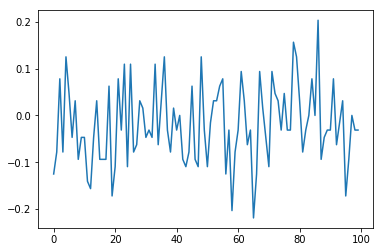

In [60]:
plt.plot(average_rewards)
plt.show()

In [124]:
num_subs = 2
env = DummyVecEnv([lambda: Environment(num_subs)])
model = PPO2_0(MlpPolicy, env, verbose=1)
model.learn(1000)

Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 0 1

Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 

Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 0 0.0
Env S,A: 1 0.0
Env R: 0.0
Env S,A: 0 

Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 0

Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 1 0.0
Env S,A: 1 0.0
Env R: -1.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 0

Env S,A: 0 1.0
Env S,A: 1 0.0
Env R: -1.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 1 1.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 0 1.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 1 0.0
Env S,A: 1 1.0
Env R: 0.0
Env S,A: 0 1.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 1 0.0
Env S,A: 0 1.0
Env R: -1.0
Env S,A: 0 1.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 0.0
Env S,A: 0 0.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
Env S,A: 1 1.0
Env S,A: 1 0.0
Env R: 0.0
Env S,A: 0 0.0
Env S,A: 0 1.0
Env R: 0.0
Env S,A: 0 

In [125]:
# Test Model

obs = env.reset()
total_reward = 0
for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    print("AP", model.action_probability(obs))
    print(obs, action)
    obs, rewards, dones, info = env.step(action)
    total_reward += rewards
    
print(total_reward)

AP [[-0.05869639  0.4926863 ]]
[[0 1]] [[0. 1.]]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
AP [[ 0.555927   -0.01764111]]
[[1 0]] [[1. 0.]]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
AP [[-0.01404518 -0.01468572]]
[[0 0]] [[0. 0.]]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
AP [[-0.01404518 -0.01468572]]
[[0 0]] [[0. 0.]]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
AP [[-0.01404518 -0.01468572]]
[[0 0]] [[0. 0.]]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
AP [[ 0.555927   -0.01764111]]
[[1 0]] [[1. 0.]]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
AP [[0.46142542 0.4596607 ]]
[[1 1]] [[1. 1.]]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
AP [[-0.05869639  0.4926863 ]]
[[0 1]] [[0. 1.]]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
AP [[-0.01404518 -0.01468572]]
[[0 0]] [[0. 0.]]
Env S,A: 0 0.0
Env S,A: 0 0.0
Env R: 1.0
AP [[ 0.555927   -0.01764111]]
[[1 0]] [[1. 0.]]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
AP [[-0.05869639  0.4926863 ]]
[[0 1]] [[0. 1.]]
Env S,A: 0 0.0
Env S,A: 1 1.0
Env R: 1.0
AP [[0.46142

AP [[0.46142542 0.4596607 ]]
[[1 1]] [[1. 1.]]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
AP [[0.46142542 0.4596607 ]]
[[1 1]] [[1. 1.]]
Env S,A: 1 1.0
Env S,A: 1 1.0
Env R: 1.0
AP [[ 0.555927   -0.01764111]]
[[1 0]] [[1. 0.]]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
AP [[ 0.555927   -0.01764111]]
[[1 0]] [[1. 0.]]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
AP [[ 0.555927   -0.01764111]]
[[1 0]] [[1. 0.]]
Env S,A: 1 1.0
Env S,A: 0 0.0
Env R: 1.0
[100.]
